# [Fe/H] < -2.2

# 11 Sep 2024
# This is the definitive solution to the selection of N-Al-rich stars
# Method similar to that adopted to select stars for the training sets
# Sample is split in 0.3 dex [Fe/H] bins and 2G stars are selected using the same methods done for training set stars
# Stars from GCs with mean [Fe/H] within that range are used as a guide, and adapting limits for the case of field stars. 
# It's working surprisingly well


In [1]:
from astropy.table import Table
from astropy.io import fits 
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import pylab as plt 
import numpy as np
import math
from scipy import stats



# Define Metallicity interval

In [2]:
fmin = -10
fmax = -2.2

# Read VAC

In [3]:
#Reading the VAC catalogue of GC stars.  This list contains stars within a 
#wide range of metallicities from the mean GC value
#gc = fits.open('../GC_members/Danny_large_GCsample_ids.fits')
#gcid = gc[1].data['col1']
#gc = fits.open('../GC_members/GC_final_Baumgardt_selection_ultimo.fits')
g = fits.open('../VAC/Final_May2022/VAC_for_export/VAC_GC_DR17_synspec_rev1-v1_1.fits')

gc_name = g[1].data['GC_NAME']
gc_id = g[1].data['APOGEE_ID']
gc_tid = g[1].data['TARGET_ID']
gc_gid = g[1].data['GAIAEDR3_SOURCE_ID']
gc_ra = g[1].data['RA']
gc_dec = g[1].data['DEC']
gc_glon = g[1].data['GLON']
gc_glat = g[1].data['GLAT']
gc_vscat = g[1].data['VSCATTER']
gc_nvis = g[1].data['NVISITS']
gc_teff = g[1].data['TEFF']
gc_teff_e = g[1].data['TEFF_ERR']
gc_logg = g[1].data['LOGG']
gc_logg_e = g[1].data['LOGG_ERR']
gc_sn = g[1].data['SNR']
gc_rv = g[1].data['VHELIO_AVG']


gc_feh = g[1].data['Fe_H']
gc_mgfe = g[1].data['Mg_Fe']
gc_cfe = g[1].data['C_Fe']
gc_cife = g[1].data['CI_Fe']
gc_ofe = g[1].data['O_Fe']
gc_nfe = g[1].data['N_Fe']
gc_cafe = g[1].data['Ca_Fe']
gc_sife = g[1].data['Si_Fe']
gc_nife = g[1].data['Ni_Fe']
gc_alfe = g[1].data['Al_Fe']
gc_tife = g[1].data['Ti_Fe']
gc_cofe = g[1].data['Co_Fe']
gc_sfe = g[1].data['S_Fe']
gc_kfe = g[1].data['K_Fe']
gc_pfe = g[1].data['P_Fe']
gc_cefe = g[1].data['Ce_Fe']
gc_vfe = g[1].data['V_Fe']
gc_crfe = g[1].data['Cr_Fe']
gc_nafe = g[1].data['Na_Fe']
gc_mnfe = g[1].data['Mn_Fe']
gc_cufe = g[1].data['Cu_Fe']
gc_sflag = g[1].data['STARFLAG']
gc_aflag = g[1].data['ASPCAPFLAG']
gc_saflag = g[1].data['ASPCAPFLAGS']
gc_ealfe = g[1].data['Al_FE_ERR']
gc_emgfe = g[1].data['MG_FE_ERR']
gc_emnfe = g[1].data['MN_FE_ERR']
gc_enfe = g[1].data['N_FE_ERR']
gc_enife = g[1].data['NI_FE_ERR']
gc_esife = g[1].data['SI_FE_ERR']
gc_ecfe = g[1].data['C_FE_ERR']


print(len(gc_id))
#print(len(mask_nogcs))

#print(gcid[0])


7737


# Eliminate duplicates using a Pandas data frame, but first sort them in order of decreasing S/N

In [4]:
from astropy.table import Table
import pandas as pd 
from pandas import DataFrame 

print(np.shape(gc_id))

#Create a data frame with all the variables of interest
glisttup=list(zip(gc_id, gc_tid, gc_gid, gc_ra, gc_dec, gc_glon, gc_glat, gc_vscat, gc_nvis, \
            gc_teff, gc_teff_e, gc_logg, gc_logg_e, gc_sn, gc_rv, gc_feh, gc_mgfe, \
            gc_cfe, gc_cife, gc_ofe, gc_nfe, gc_cafe, gc_sife, gc_nife, gc_alfe, gc_tife, \
            gc_cofe, gc_sfe, gc_kfe, gc_pfe, gc_cefe, gc_vfe, gc_crfe, gc_nafe, gc_mnfe, \
            gc_cufe, gc_sflag, gc_aflag, gc_ecfe, gc_enfe, gc_enife, gc_esife, gc_emnfe, \
            gc_emgfe, gc_ealfe, gc_name, gc_saflag))

g_df=pd.DataFrame(glisttup, \
        columns=['gc_id', 'gc_tid', 'gc_gid', 'gc_ra', 'gc_dec', 'gc_glon', 'gc_glat', \
        'gc_vscat', 'gc_nvis', 'gc_teff', 'gc_teff_e', 'gc_logg', 'gc_logg_e', \
		'gc_sn', 'gc_rv', 'gc_feh', 'gc_mgfe', 'gc_cfe', 'gc_cife', 'gc_ofe', 'gc_nfe', \
        'gc_cafe', 'gc_sife', 'gc_nife', 'gc_alfe', 'gc_tife', 'gc_cofe', 'gc_sfe', 'gc_kfe', \
        'gc_pfe', 'gc_cefe', 'gc_vfe', 'gc_crfe', 'gc_nafe', 'gc_mnfe', 'gc_cufe', 'gc_sflag', \
		'gc_aflag', 'gc_ecfe', 'gc_enfe', 'gc_enife', 'gc_esife', 'gc_emnfe', 'gc_emgfe', \
        'gc_ealfe', 'gc_name', 'gc_saflag'])

#remove duplicates, keeping the records with the highest SNR value
print('Number of stars before removing duplicates: '+str(len(g_df)))
g_df=g_df.sort_values(by=['gc_id','gc_sn'],ascending=False)
g_df=g_df[~g_df['gc_id'].duplicated(keep='first')]
print('Number of stars after removing duplicates: '+str(len(g_df)))

g_df=g_df.reset_index(drop=True)

#g_df['class'] = np.where((np.abs(g_df['GLAT'])<20) & ((g_df['GLON']<20) | \
#                (g_df['GLON']>340)) & (g_df['GAIAEDR3_R_MED_PHOTOGEO']>5000) \
#                & (g_df['GAIAEDR3_R_MED_PHOTOGEO']<11000),'Bulge','Field' )


(7737,)
Number of stars before removing duplicates: 7737
Number of stars after removing duplicates: 6424


# Convert pandas dataframes back to numpy arrays, now without duplication

In [5]:
gc_name = g_df['gc_name'].to_numpy()
gc_id = g_df['gc_id'].to_numpy()
gc_ra = g_df['gc_ra'].to_numpy()
gc_dec = g_df['gc_dec'].to_numpy()
gc_glon = g_df['gc_glon'].to_numpy()
gc_glat = g_df['gc_glat'].to_numpy()
gc_vscat = g_df['gc_vscat'].to_numpy()
gc_nvis = g_df['gc_nvis'].to_numpy()
gc_teff = g_df['gc_teff'].to_numpy()
gc_logg = g_df['gc_logg'].to_numpy()
gc_sn = g_df['gc_sn'].to_numpy()
gc_rv = g_df['gc_rv'].to_numpy()
gc_feh = g_df['gc_feh'].to_numpy()
gc_mgfe = g_df['gc_mgfe'].to_numpy()
gc_cfe = g_df['gc_cfe'].to_numpy()
gc_cife = g_df['gc_cife'].to_numpy()
gc_ofe = g_df['gc_ofe'].to_numpy()
gc_nfe = g_df['gc_nfe'].to_numpy()
gc_cafe = g_df['gc_cafe'].to_numpy()
gc_sife = g_df['gc_sife'].to_numpy()
gc_nife = g_df['gc_nife'].to_numpy()
gc_alfe = g_df['gc_alfe'].to_numpy()
gc_tife = g_df['gc_tife'].to_numpy()
gc_cofe = g_df['gc_cofe'].to_numpy()
gc_sfe = g_df['gc_sfe'].to_numpy()
gc_kfe = g_df['gc_kfe'].to_numpy()
gc_pfe = g_df['gc_pfe'].to_numpy()
gc_cefe = g_df['gc_cefe'].to_numpy()
gc_vfe = g_df['gc_vfe'].to_numpy()
gc_crfe = g_df['gc_crfe'].to_numpy()
gc_nafe = g_df['gc_nafe'].to_numpy()
gc_mnfe = g_df['gc_mnfe'].to_numpy()
gc_cufe = g_df['gc_cufe'].to_numpy()
gc_sflag = g_df['gc_sflag'].to_numpy()
gc_aflag = g_df['gc_aflag'].to_numpy()
gc_saflag = g_df['gc_saflag'].to_numpy()

gc_ecfe = g_df['gc_ecfe'].to_numpy()  
gc_enfe = g_df['gc_enfe'].to_numpy()
gc_enife = g_df['gc_enife'].to_numpy()
gc_esife = g_df['gc_esife'].to_numpy()
gc_emnfe = g_df['gc_emnfe'].to_numpy()  
gc_emgfe = g_df['gc_emgfe'].to_numpy()  
gc_ealfe = g_df['gc_ealfe'].to_numpy()  


print(len(gc_glat))

6424


# Identify relevant NaNs and remove them in next cell

In [6]:

###############################
#Remove NaNs

#mask_nan = [np.isfinite(i) for i in [feh_al, nife_al, \
#                    simn_al, peak_al]]

mask_nan = (np.isfinite(gc_alfe) & np.isfinite(gc_feh) & np.isfinite(gc_nfe) \
            & np.isfinite(gc_cfe) & np.isfinite(gc_mgfe))


count = gc_feh[mask_nan]

print(len(count))

5957


# DEFINE WORKING SAMPLE FOR ABUNDANCE COMPARISONS.
# Also remove NaNs

In [7]:


mask_g = ( (gc_sn >= 50) & (gc_teff > 3500) & (gc_teff < 5000) & \
        (gc_logg < 3.6) & (gc_logg > -1) )

name_g = gc_name[mask_g&mask_nan]
ids_g = gc_id[mask_g&mask_nan]
teff_g = gc_teff[mask_g&mask_nan]
logg_g = gc_logg[mask_g&mask_nan]
sn_g = gc_sn[mask_g&mask_nan]
mgfe_g = gc_mgfe[mask_g&mask_nan]
nfe_g = gc_nfe[mask_g&mask_nan]
nife_g = gc_nife[mask_g&mask_nan]
feh_g = gc_feh[mask_g&mask_nan]
cafe_g = gc_cafe[mask_g&mask_nan]
cfe_g = gc_cfe[mask_g&mask_nan]
cife_g = gc_cife[mask_g&mask_nan]
ofe_g = gc_ofe[mask_g&mask_nan]
sife_g = gc_sife[mask_g&mask_nan]
nife_g = gc_nife[mask_g&mask_nan]
nafe_g = gc_nafe[mask_g&mask_nan]
alfe_g = gc_alfe[mask_g&mask_nan]
tife_g = gc_tife[mask_g&mask_nan]
kfe_g = gc_kfe[mask_g&mask_nan]
vfe_g = gc_vfe[mask_g&mask_nan]
tife_g = gc_tife[mask_g&mask_nan]
mnfe_g = gc_mnfe[mask_g&mask_nan]
crfe_g = gc_crfe[mask_g&mask_nan]
cufe_g = gc_cufe[mask_g&mask_nan]
cefe_g = gc_cefe[mask_g&mask_nan]
cofe_g = gc_cofe[mask_g&mask_nan]
pfe_g = gc_pfe[mask_g&mask_nan]
sfe_g = gc_sfe[mask_g&mask_nan]
mgmn_g = gc_mgfe[mask_g&mask_nan] - gc_mnfe[mask_g&mask_nan]
simn_g = sife_g - mnfe_g

aflag_g = gc_aflag[mask_g&mask_nan]
saflag_g = gc_saflag[mask_g&mask_nan]

In [8]:
print(len(sfe_g))

4584


# Open VAC parameters file and select GCs in the right [Fe/H] range.  Stars from these GCs are used for the 2G star selection

In [9]:
p = fits.open('../VAC/Final_May2022/VAC_for_export/GC_parameters_VAC-v1_1.fits')
#columns = Table(p[1].data)
#columns

p_name = p[1].data['GC_name']
p_fem = p[1].data['Fe_H_med']
p_nst = p[1].data['Nstars']

target = ( (p_fem >=fmin) & (p_fem <fmax) & (p_name !='NGC5139') \
          & (p_name !='NGC6715')) 
print(p_name[target])
print(p_nst[target])

pt_name = p_name[target]
pt_nst = p_nst[target]
print(np.sum(p_nst[target]))

['NGC4590' 'NGC5053' 'NGC6341' 'NGC7078']
[ 41  17  80 155]
293


In [10]:
print(type(feh_g))

<class 'numpy.ndarray'>


# Stack stars from the above GCs into consistent abundance arrays.  
# These will be the models for 2G star selection in the field star selection

In [11]:
m=0
idt = []
fet = []
mgt = []
alt = []
ct = []
nt = []

for i in range(0,len(pt_name)):
    for l in range(0,len(name_g)):
        if name_g[l] == pt_name[i]:
            m+=1
            idt.append(ids_g[l])
            fet.append(feh_g[l])
            mgt.append(mgfe_g[l])
            alt.append(alfe_g[l])
            nt.append(nfe_g[l])
            ct.append(cfe_g[l])
#            fet[m] = feh_g[l]
#            mgt[m] = mgfe_g[l]
#            alt[m] = alfe_g[l]
#            nt[m] = nfe_g[l]
#            ct[m] = cfe_g[l]
#            m = m + 1

print('Difference between this number and the sum of p_nst')
print('is due to the removal of NaNs')
print(m)

idt = np.array(idt)
fet = np.array(fet)
mgt = np.array(mgt)
alt = np.array(alt)
ct = np.array(ct)
nt = np.array(nt)

Difference between this number and the sum of p_nst
is due to the removal of NaNs
183


In [12]:
print(type(mgt))

<class 'numpy.ndarray'>


# %%%%%%%%%%%%%%%%%%%%%
# Adjust lines that separate 2G from 1G stars, in N-C plane
# For stars in this metallicity range ([Fe/H] < -2.2), 2G stars are selected purely on the basis of the Mg-Al plane
# %%%%%%%%%%%%%%%%%%%%%

# First examine distribution of GC stars on the relevant abundance planes
# Experience from previous selection of training set makes this task quite easy
# %%%%%%%%%%%%%%%%%%%%%%

# First the N-C and Mg-Al planes

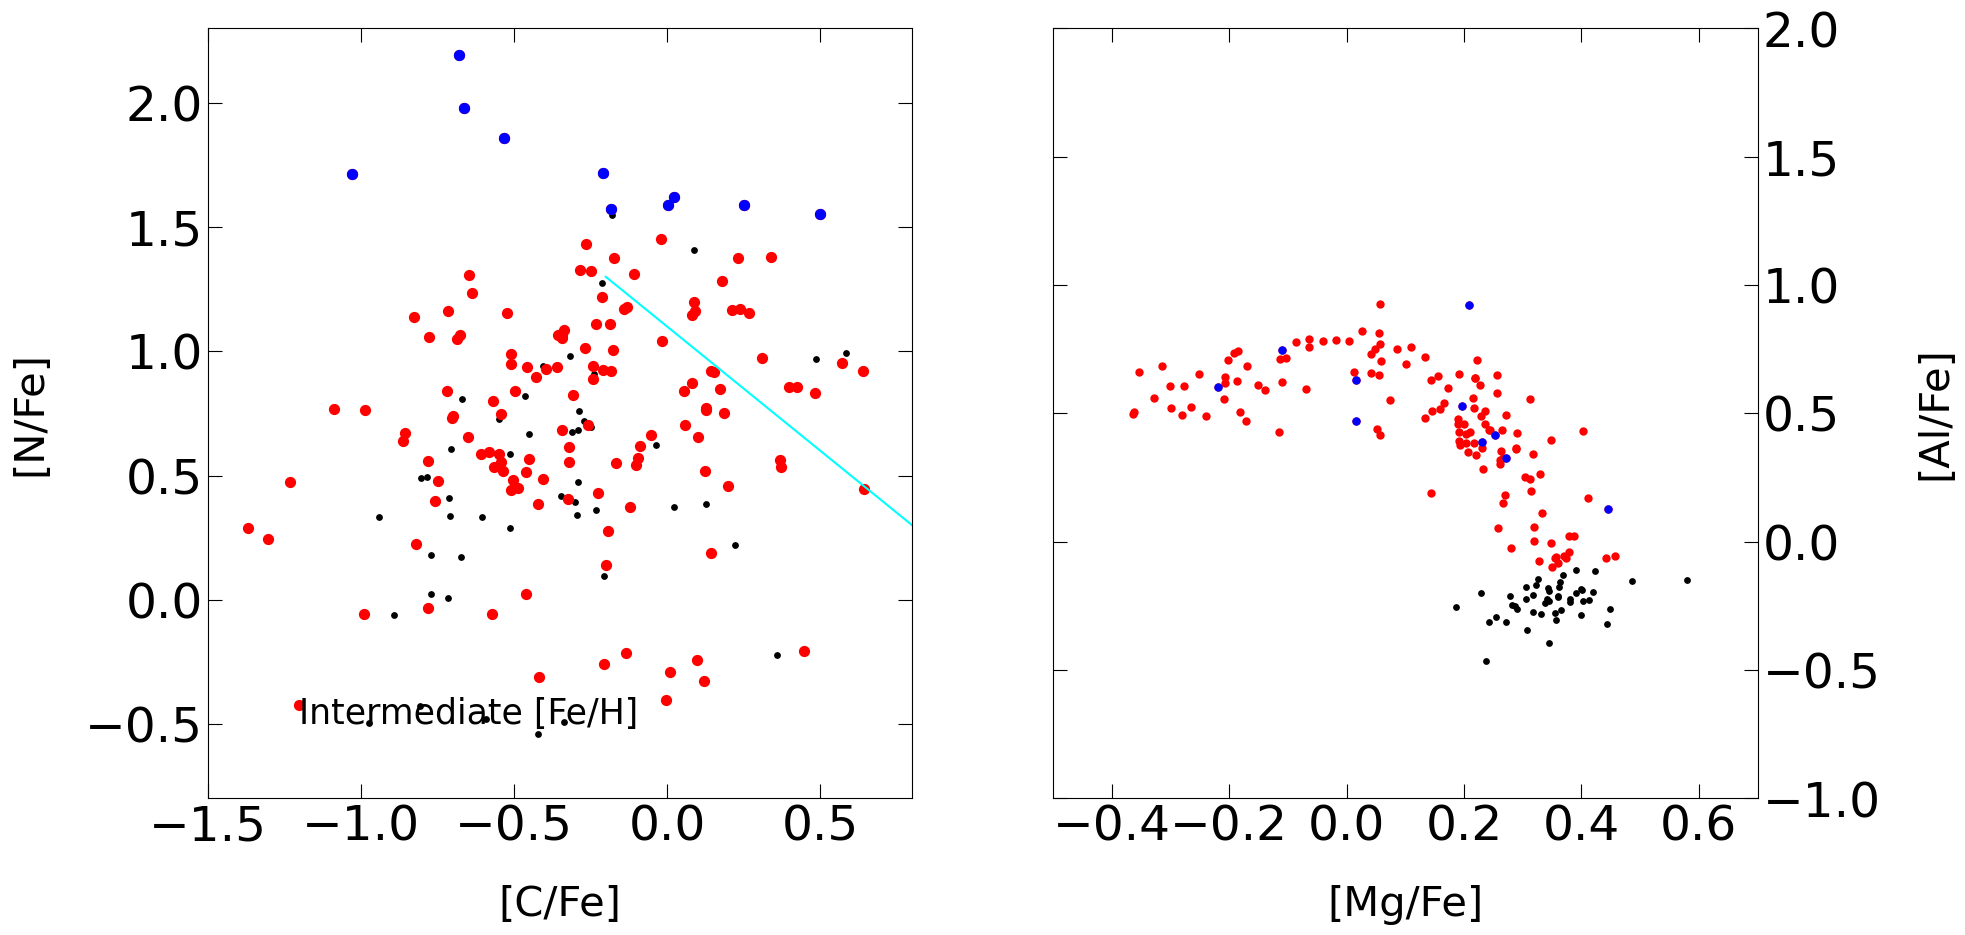

In [14]:
import matplotlib.gridspec as gridspec


# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35

#Definition of G2 stars 
lim = -0.1
G2 = (alt > lim) 

G3 = (nt > 1.5)


#fig= plt.figure(figsize=(15,30),constrained_layout=True)

gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.2, hspace=1) # set the spacing between axes. 


plt.subplot(gs[0])
plt.scatter(ct,nt,c='k',alpha=1,s=15)
plt.scatter(ct[G2],nt[G2],c='r',alpha=1,s=50)
plt.scatter(ct[G2&G3],nt[G2&G3],c='b',alpha=1,s=50)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.xlim(-1.5,0.8)
plt.ylim(-0.8,2.3)
plt.text(-1.2,-0.5,'Intermediate [Fe/H]',fontsize=25)
plt.tick_params(direction='in',right=True,top=True,length=10)

#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_n*x+b_n, c='blue')

#New definition of C-rich stars -- See "Consolidate_2G_stars"
#plt.plot([-2,2],[lim,lim])
x = np.arange(-0.2,1.5,0.1)
a=-1
b=1.1
plt.plot(x,a*x+b, c='cyan')


ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(mgt,alt,c='k',alpha=1,s=15)
plt.scatter(mgt[G2],alt[G2],c='r',alpha=1,s=25)
plt.scatter(mgt[G2&G3],alt[G2&G3],c='b',alpha=1,s=25)
plt.xticks((np.arange(-4,4,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlabel('[Mg/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.7)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelright=True,labelleft=False)
#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_al*x+b_al, c='blue')




#plt.savefig('train_'+ pt_name[ind] + '.png',format='png',dpi=300,bbox_inches='tight')




# Now N-Al and Mg-N planes

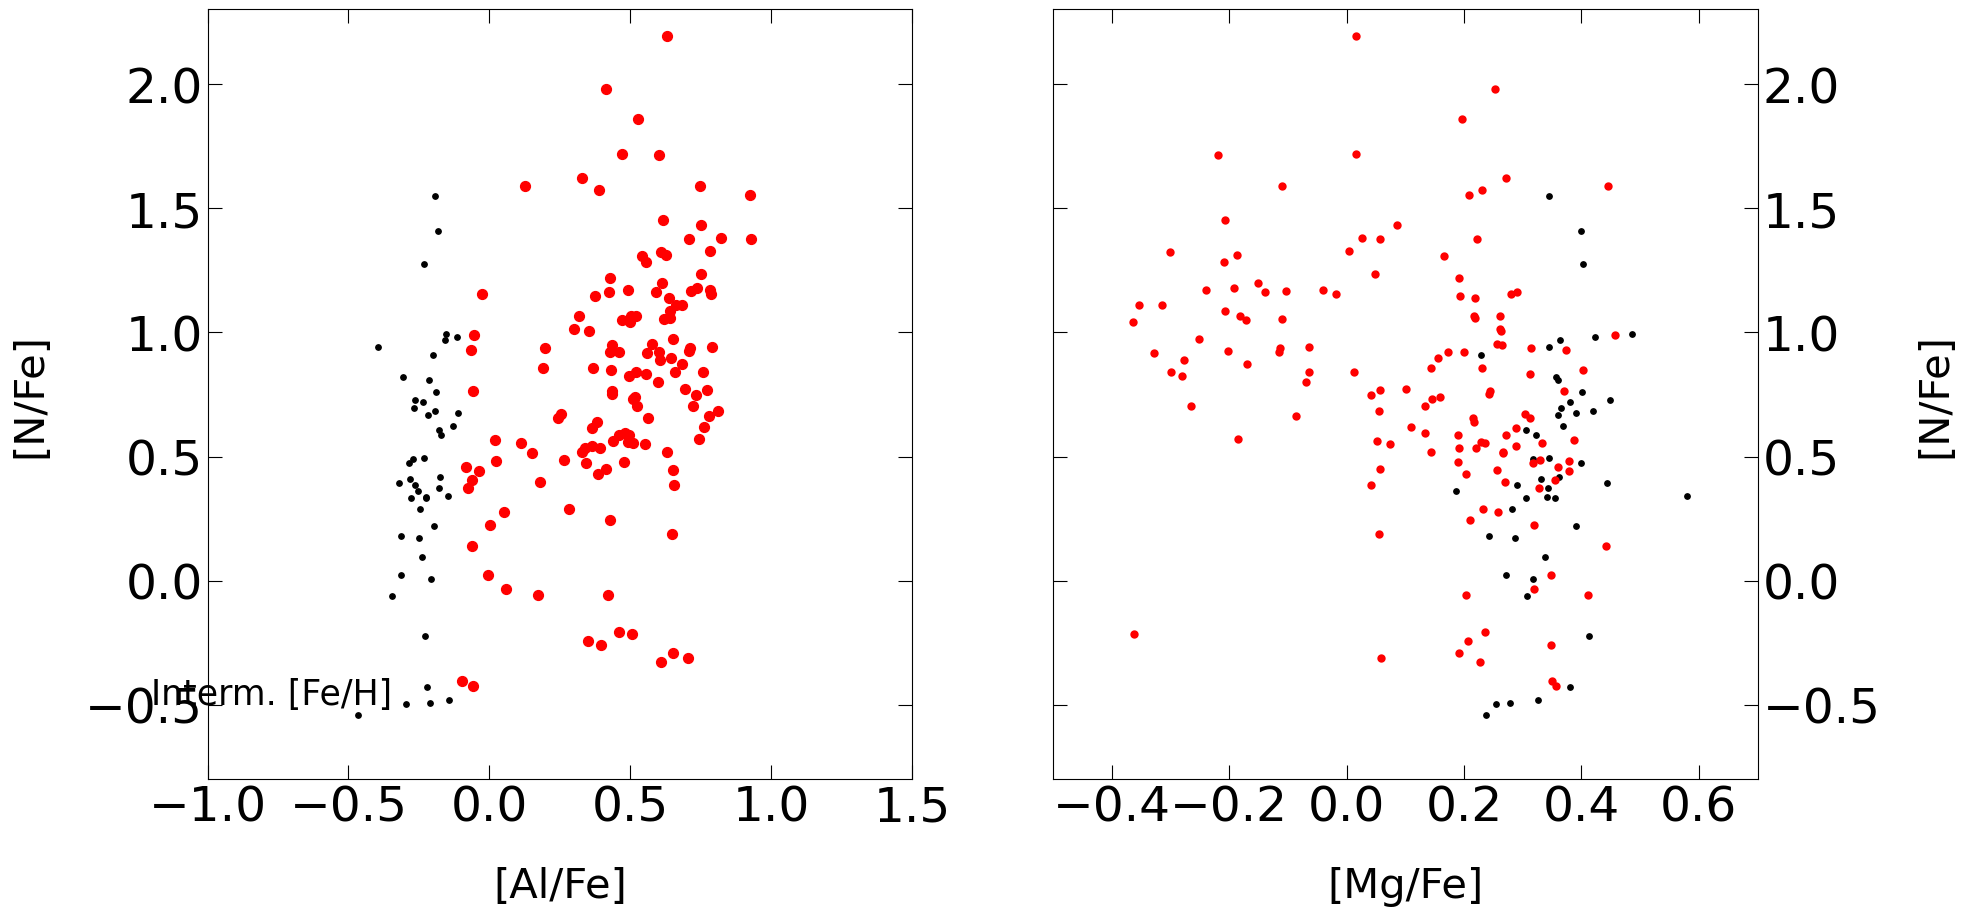

In [15]:
import matplotlib.gridspec as gridspec


# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35



gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.2, hspace=1) # set the spacing between axes. 


plt.subplot(gs[0])
plt.scatter(alt,nt,c='k',alpha=1,s=15)
plt.scatter(alt[G2],nt[G2],c='r',alpha=1,s=50)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlim(-1.,1.5)
plt.ylim(-0.8,2.3)
plt.text(-1.2,-0.5,'Interm. [Fe/H]',fontsize=25)
plt.tick_params(direction='in',right=True,top=True,length=10)

#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_n[ind]*x+b_n[ind], c='blue')



ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(mgt,nt,c='k',alpha=1,s=15)
plt.scatter(mgt[G2],nt[G2],c='r',alpha=1,s=25)
plt.xticks((np.arange(-4,4,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[Mg/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.7)
plt.ylim(-0.8,2.3)
plt.tick_params(direction='in',right=True,top=True,length=10,labelright=True,labelleft=False)
#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_al[ind]*x+b_al[ind], c='blue')




#plt.savefig('train_'+ pt_name[ind] + '.png',format='png',dpi=300,bbox_inches='tight')




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 [Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12'),
  Text(0, 14.0, '14'),
  Text(0, 16.0, '16'),
  Text(0, 18.0, '18')])

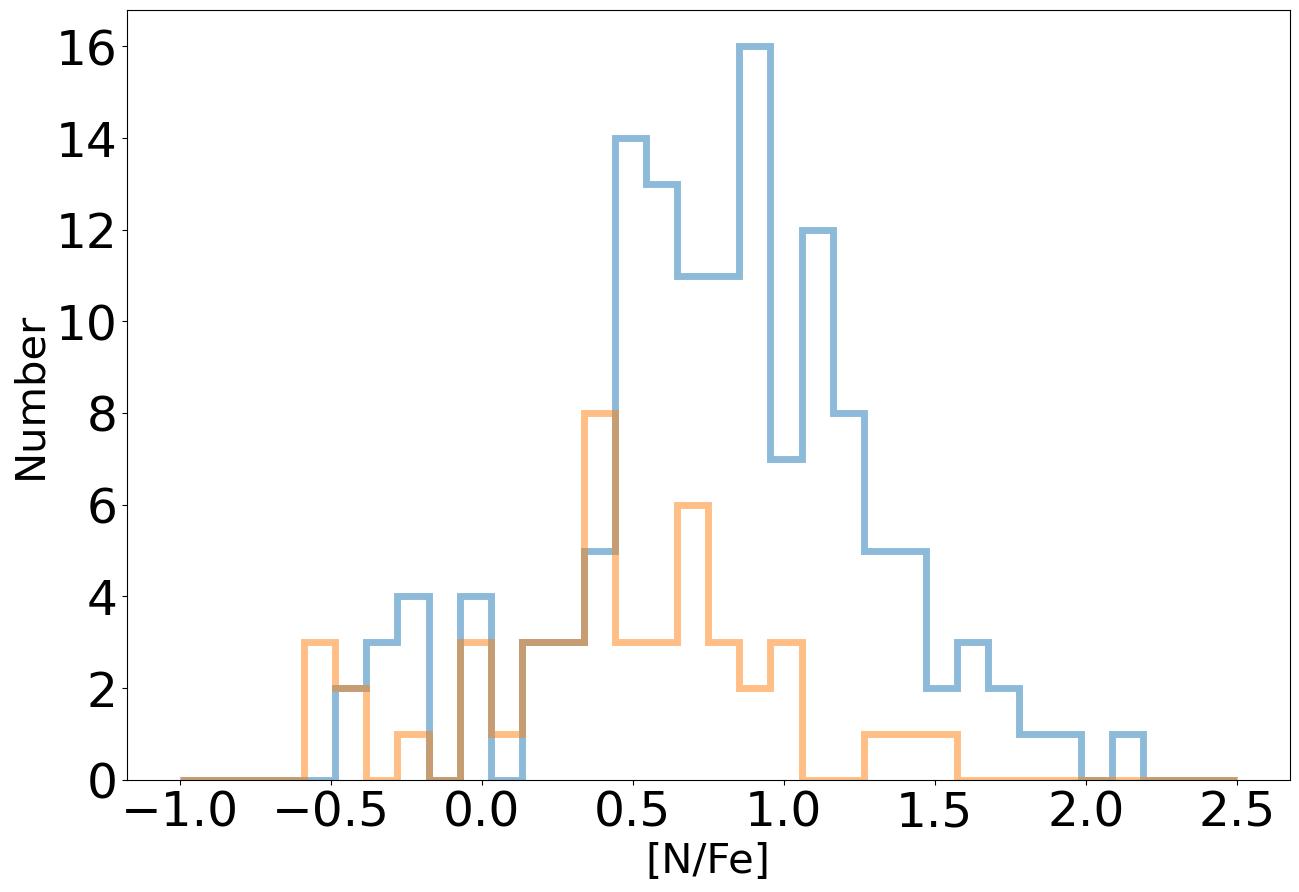

In [17]:
alrich = (alt > lim)
alpoor = (alt <= lim)

#Get current size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15 
fig_size[1] = 10

bins = np.linspace(-1,2.5,35)
plt.hist(nt[alrich], bins, alpha=0.5, histtype='step',linewidth=5, density=False)
plt.hist(nt[alpoor], bins, alpha=0.5, histtype='step',linewidth=5, density=False)
plt.xlabel('[N/Fe]',size=labs)
plt.ylabel('Number',size=labs)
plt.legend(frameon=False,fontsize=20,handletextpad=0.3,loc='upper left')
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)

#plt.savefig('hist_FeHs.png',format='png',bbox_inches='tight')



# %%%%%%%%%%%%%%%%%%%%%%
# Now apply the same method to the Field Stars
# Small tweaks to the abundance limits are needed in some cases
# %%%%%%%%%%%%%%%%%%%%%%


# Read the catalog

In [18]:
#READ THE DATA 
#
from astropy.table import Table
from astropy.io import fits 
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import pylab as plt 
import numpy as np
import math
from scipy import stats


# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 16 and height to 12
fig_size[0] = 20
fig_size[1] = 20

#Figure settings (font sizes of ticks and labels)
labs=35
tcks=30


#Reading the table containing DR16+ data
a = fits.open('../dr17_dr3_McMillan_astroNN_rev1.fits')
aid = a[1].data['APOGEE_ID_1']
atid = a[1].data['TARGET_ID']
agid = a[1].data['GAIAEDR3_SOURCE_ID']
ara = a[1].data['RA']
adec = a[1].data['DEC']
aglon = a[1].data['GLON']
aglat = a[1].data['GLAT']
avscat = a[1].data['VSCATTER']
anvis = a[1].data['NVISITS']
ateff = a[1].data['TEFF']
ateff_e = a[1].data['TEFF_ERR']
alogg = a[1].data['LOGG']
alogg_e = a[1].data['LOGG_ERR']
asn = a[1].data['SNR']
arv = a[1].data['VHELIO_AVG']

ajmag = a[1].data['J']
ahmag = a[1].data['H']
akmag = a[1].data['K']

afe = a[1].data['Fe_H']
amg = a[1].data['Mg_Fe']
ac = a[1].data['C_Fe']
aci = a[1].data['CI_Fe']
ao = a[1].data['O_Fe']
an = a[1].data['N_Fe']
aca = a[1].data['Ca_Fe']
asi = a[1].data['Si_Fe']
ani = a[1].data['Ni_Fe']
aal = a[1].data['Al_Fe']
ati = a[1].data['Ti_Fe']
aco = a[1].data['Co_Fe']
a_s = a[1].data['S_Fe']
ak = a[1].data['K_Fe']
ap = a[1].data['P_Fe']
ace = a[1].data['Ce_Fe']
av = a[1].data['V_Fe']
acr = a[1].data['Cr_Fe']
ana = a[1].data['Na_Fe']
amn = a[1].data['Mn_Fe']
acu = a[1].data['Cu_Fe']
asflag = a[1].data['STARFLAG']
aaflag = a[1].data['ASPCAPFLAG']
aeal = a[1].data['Al_FE_ERR']
aemg = a[1].data['MG_FE_ERR']
aemn = a[1].data['MN_FE_ERR']

ajmag = a[1].data['J']
ahmag = a[1].data['H']
akmag = a[1].data['K']
aa_k = a[1].data['AK_TARG']
aa_j = 2.5*aa_k
ai36 = a[1].data['IRAC_3_6']
ai45 = a[1].data['IRAC_4_5']
ai80 = a[1].data['IRAC_8_0']

adist = a[1].data['weighted_dist']
aedist = a[1].data['weighted_dist_error']
ae = a[1].data['ecc']
#ae_err = a[1].data['e_err']
azmax = a[1].data['zmax']
#azmax_err = a[1].data['zmax_err']
arperi = a[1].data['rperi']
#arperi_err = a[1].data['rperi_err']
ajr = a[1].data['jr']
#ajr_err = a[1].data['jr_err']
aLz = a[1].data['Lz']
#aLz_err = a[1].data['Lz_err']
ajz = a[1].data['jz']
#ajz_err = a[1].data['jz_err']
aEnergy = a[1].data['energy']
#aEnergy_err = a[1].data['Energy_err']

avr = a[1].data['Vr']*220.   
avt = a[1].data['vT']*220.   
avz = a[1].data['vZ']*220.   


# Eliminate duplicates using a Pandas data frame

In [1]:
from astropy.table import Table
import pandas as pd 
from pandas import DataFrame 

print(np.shape(aid))

#Create a data frame with all the variables of interest
listtup=list(zip(aid, atid, agid, ara, adec, aglon, aglat, avscat, anvis, ateff, \
            ateff_e, alogg, alogg_e, asn, arv, ajmag, ahmag, akmag, afe, amg, \
            ac, aci, ao, an, aca, asi, ani, aal, ati, aco, a_s, ak, ap, ace, \
            av, acr, ana, amn, acu, asflag, aaflag, aeal, aemg, aemn, ajmag, \
            ahmag, akmag, aa_k, aa_j, ai36, ai45, ai80, adist, aedist, ae, \
            azmax, arperi, ajr, aLz, ajz, aEnergy, avr, avt, avz))

s_df=pd.DataFrame(listtup, \
        columns=['aid', 'atid', 'agid', 'ara', 'adec', 'aglon', 'aglat', 'avscat', \
		'anvis', 'ateff', 'ateff_e', 'alogg', 'alogg_e', \
		'asn', 'arv', 'ajmag', 'ahmag', 'akmag', 'afe', \
		'amg', 'ac', 'aci', 'ao', 'an', 'aca', 'asi', \
		'ani', 'aal', 'ati', 'aco', 'a_s', 'ak', 'ap', \
		'ace', 'av', 'acr', 'ana', 'amn', 'acu', 'asflag', \
		'aaflag', 'aeal', 'aemg', 'aemn', 'ajmag', 'ahmag', \
		'akmag', 'aa_k', 'aa_j', 'ai36', 'ai45', 'ai80', \
		'adist', 'aedist', 'ae', 'azmax', 'arperi', 'ajr', \
		'aLz', 'ajz', 'aEnergy', 'avr', 'avt', 'avz'])


#Drop the duplicates
print("we now drop the duplicates and reset the index")
s_df=s_df.drop_duplicates(subset=['aid'])
s_df=s_df.reset_index()
print("\nstars_df:\n\n",s_df)

print(np.shape(s_df))

ModuleNotFoundError: No module named 'astropy'

# Convert pandas dataframes back to numpy arrays, now without duplication

In [20]:
aid = s_df['aid'].to_numpy()
atid = s_df['atid'].to_numpy()
agid = s_df['agid'].to_numpy()
ara = s_df['ara'].to_numpy()
adec = s_df['adec'].to_numpy()
aglon = s_df['aglon'].to_numpy()
aglat = s_df['aglat'].to_numpy()
avscat = s_df['avscat'].to_numpy()
anvis = s_df['anvis'].to_numpy()
ateff = s_df['ateff'].to_numpy()
ateff_e = s_df['ateff_e'].to_numpy()
alogg = s_df['alogg'].to_numpy()
alogg_e = s_df['alogg_e'].to_numpy()
asn = s_df['asn'].to_numpy()
arv = s_df['arv'].to_numpy()
ajmag = s_df['ajmag'].to_numpy()
ahmag = s_df['ahmag'].to_numpy()
akmag = s_df['akmag'].to_numpy()
afe = s_df['afe'].to_numpy()
amg = s_df['amg'].to_numpy()
ac = s_df['ac'].to_numpy()
aci = s_df['aci'].to_numpy()
ao = s_df['ao'].to_numpy()
an = s_df['an'].to_numpy()
aca = s_df['aca'].to_numpy()
asi = s_df['asi'].to_numpy()
ani = s_df['ani'].to_numpy()
aal = s_df['aal'].to_numpy()
ati = s_df['ati'].to_numpy()
aco = s_df['aco'].to_numpy()
a_s = s_df['a_s'].to_numpy()
ak = s_df['ak'].to_numpy()
ap = s_df['ap'].to_numpy()
ace = s_df['ace'].to_numpy()
av = s_df['av'].to_numpy()
acr = s_df['acr'].to_numpy()
ana = s_df['ana'].to_numpy()
amn = s_df['amn'].to_numpy()
acu = s_df['acu'].to_numpy()
asflag = s_df['asflag'].to_numpy()
aaflag = s_df['aaflag'].to_numpy()
aeal = s_df['aeal'].to_numpy()
aemg = s_df['aemg'].to_numpy()
aemn = s_df['aemn'].to_numpy()
ajmag = s_df['ajmag'].to_numpy()
ahmag = s_df['ahmag'].to_numpy()
akmag = s_df['akmag'].to_numpy()
aa_k = s_df['aa_k'].to_numpy()
aa_j = 2.5*aa_k
ai36 = s_df['aa_j'].to_numpy()
ai45 = s_df['ai45'].to_numpy()
ai80 = s_df['ai80'].to_numpy()
adist = s_df['adist'].to_numpy()
aedist = s_df['aedist'].to_numpy()
ae = s_df['ae'].to_numpy()
azmax = s_df['azmax'].to_numpy()
arperi = s_df['arperi'].to_numpy()
ajr = s_df['ajr'].to_numpy()
aLz = s_df['aLz'].to_numpy()
ajz = s_df['ajz'].to_numpy()
aEnergy = s_df['aEnergy'].to_numpy()
avr = s_df['avr'].to_numpy()*220.   
avt = s_df['avt'].to_numpy()*220.   
avz = s_df['avz'].to_numpy()*220.   


print(np.shape(aglat))


(657134,)


In [21]:

for i in range(0,len(aLz)):
    if aid[i]=='2M11583203-1703320':
        print(aLz[i],aEnergy[i])
        print(afe[i],an[i])

0.744359 -168660.976639
-1.2662 0.44028986


# Define field working sample

In [24]:
#Read IDs of Sgr members, sent by Sten Hasselquist in email from 1st April 2021
sgr = fits.open('SGR_final.fits')
xid = sgr[1].data['GAIAEDR3_SOURCE_ID']
#print(len(xid))

sgid_mask = np.isin(agid,xid,invert=True)
mask_nosgr = sgid_mask==True
mask_sgr = (sgid_mask==False)

print(len(agid),len(xid),len(agid[sgid_mask==True]))

gcid_mask = np.isin(agid,gc_gid,invert=True)

#For Mg-Al plane -- Different Teff range
mask_al = ( (asn >= 50) & (ateff > 3000) & (ateff < 5000) & \
        (alogg < 3.6) & (alogg > -1) & ((aedist/adist)<0.20) & \
        (gcid_mask==True) & (afe > -10) & (amg > -10) & (amn > -10) & \
        (aEnergy < 0.0) & (aLz < 1.e4) & (aLz > -1.e4) & \
        (asflag ==0 ) & (an < 10) & (an > -10) & (ac > -10) & \
        (ac < 10) & (aal > -10) & (aal < 10) & (sgid_mask==True)) 




ids_al = aid[mask_al]
teff_al = ateff[mask_al]
logg_al = alogg[mask_al]
mgfe_al = amg[mask_al]
nfe_al = an[mask_al]
nife_al = ani[mask_al]
feh_al = afe[mask_al]
cafe_al = aca[mask_al]
cfe_al = ac[mask_al]
cife_al = aci[mask_al]
ofe_al = ao[mask_al]
sife_al = asi[mask_al]
nife_al = ani[mask_al]
nafe_al = ana[mask_al]
alfe_al = aal[mask_al]
tife_al = ati[mask_al]
kfe_al = ak[mask_al]
vfe_al = av[mask_al]
tife_al = ati[mask_al]
mnfe_al = amn[mask_al]
crfe_al = acr[mask_al]
cufe_al = acu[mask_al]
cefe_al = ace[mask_al]
cofe_al = aco[mask_al]
pfe_al = ap[mask_al]
sfe_al = a_s[mask_al]
mgmn_al = amg[mask_al] - amn[mask_al]
simn_al = sife_al - mnfe_al

lz_al = aLz[mask_al]
ecc_al = ae[mask_al]
ener_al = aEnergy[mask_al]/1.e5
dist_al = adist[mask_al]/1.e3

657134 1478 656184


In [25]:
print(len(dist_al[feh_al<-2.2]))


15


# First the N-C and Mg-Al planes

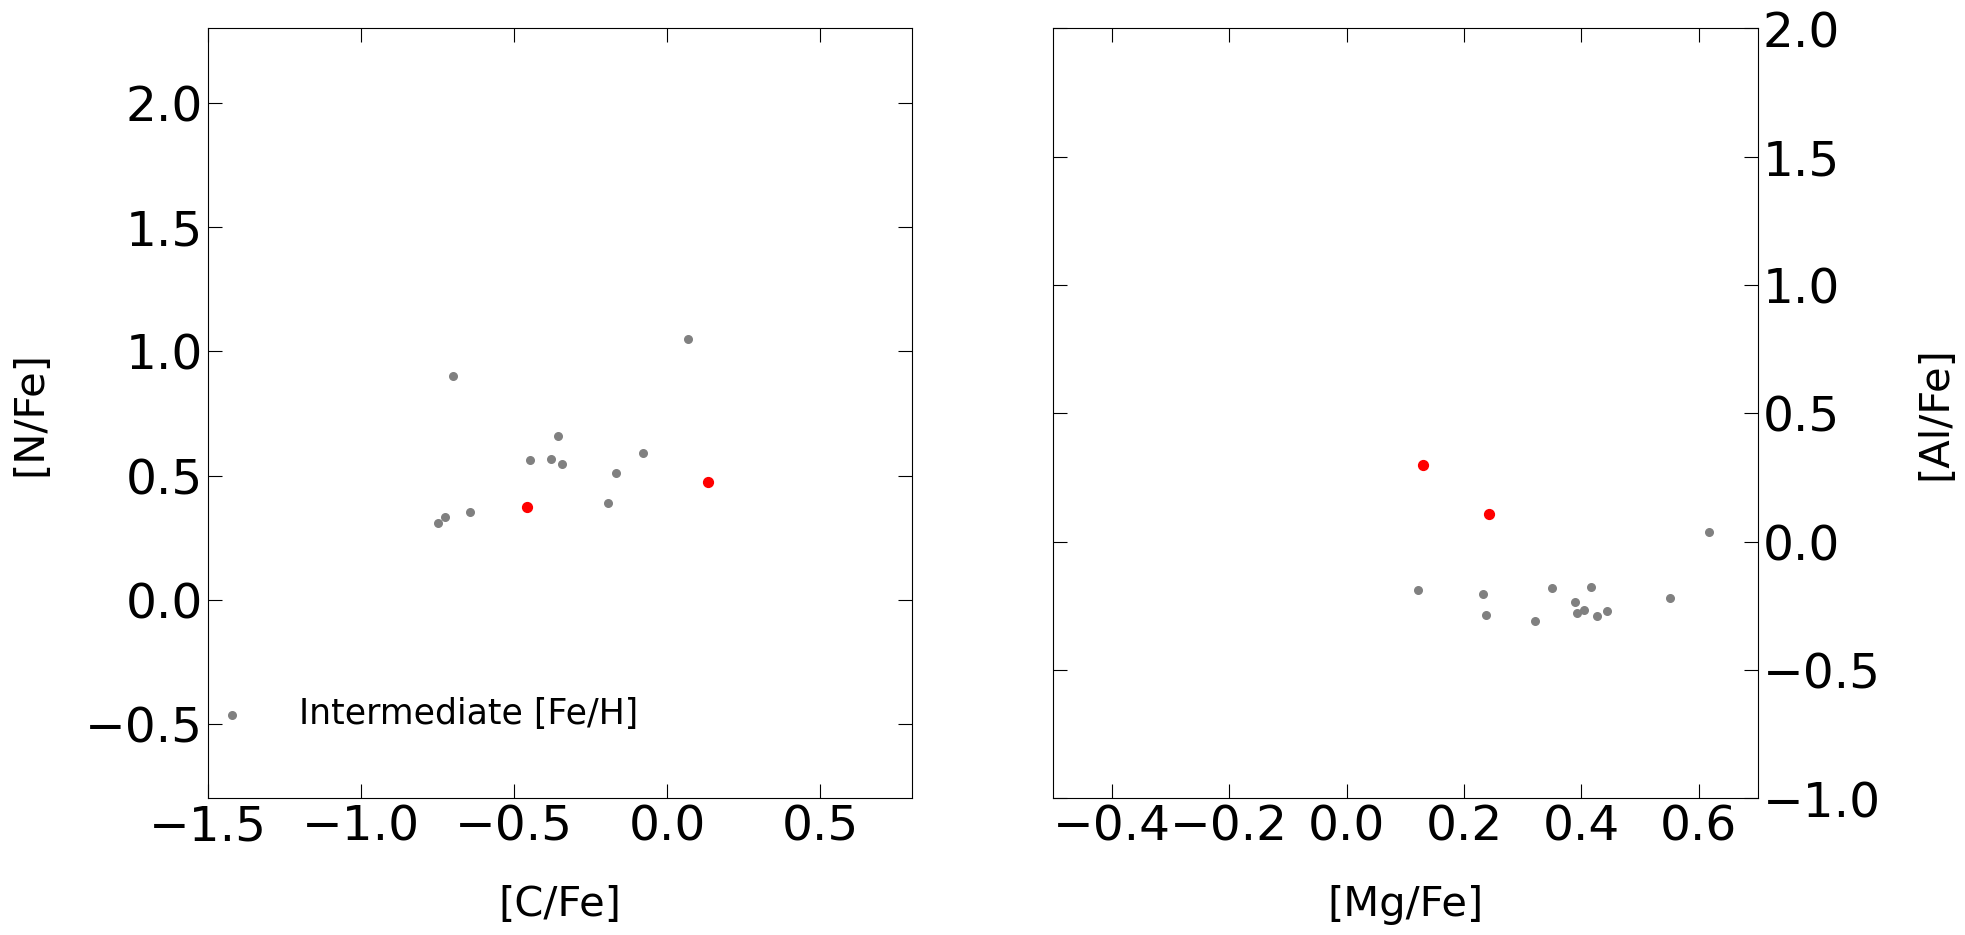

In [28]:
import matplotlib.gridspec as gridspec


# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35


#Definition of G2 stars 
lim=0.1
G2 = (alfe_al > lim) 

# These are stars with very high N abundances, absent from GC sample
# Likely debris from w Cen
G3 = nfe_al > 1.5

gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.2, hspace=1) # set the spacing between axes. 

met = ( (feh_al>fmin) & (feh_al < fmax) & (teff_al< 5000) )

plt.subplot(gs[0])
plt.scatter(cfe_al[met],nfe_al[met],c='gray',s=30)
plt.scatter(cfe_al[met&G2],nfe_al[met&G2],c='r',s=50)
plt.scatter(cfe_al[met&G3],nfe_al[met&G3],c='blue',s=50)
#plt.scatter(ct,nt,c='k',alpha=1,s=15)
#plt.scatter(ct[G2],nt[G2],c='r',alpha=1,s=50)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.xlim(-1.5,0.8)
plt.ylim(-0.8,2.3)
plt.text(-1.2,-0.5,'Intermediate [Fe/H]',fontsize=25)
plt.tick_params(direction='in',right=True,top=True,length=10)

#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_n*x+b_n, c='blue')



ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(mgfe_al[met],alfe_al[met],c='gray',s=30)
plt.scatter(mgfe_al[met&G2],alfe_al[met&G2],c='r',s=50)
plt.scatter(mgfe_al[met&G3],alfe_al[met&G3],c='blue',s=50)
#plt.scatter(mgt,alt,c='k',alpha=1,s=15)
#plt.scatter(mgt[G2],alt[G2],c='r',alpha=1,s=25)
plt.xticks((np.arange(-4,4,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlabel('[Mg/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.7)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelright=True,labelleft=False)
#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_al*x+b_al, c='blue')




#plt.savefig('train_'+ pt_name[ind] + '.png',format='png',dpi=300,bbox_inches='tight')




# Now examine other abundance planes

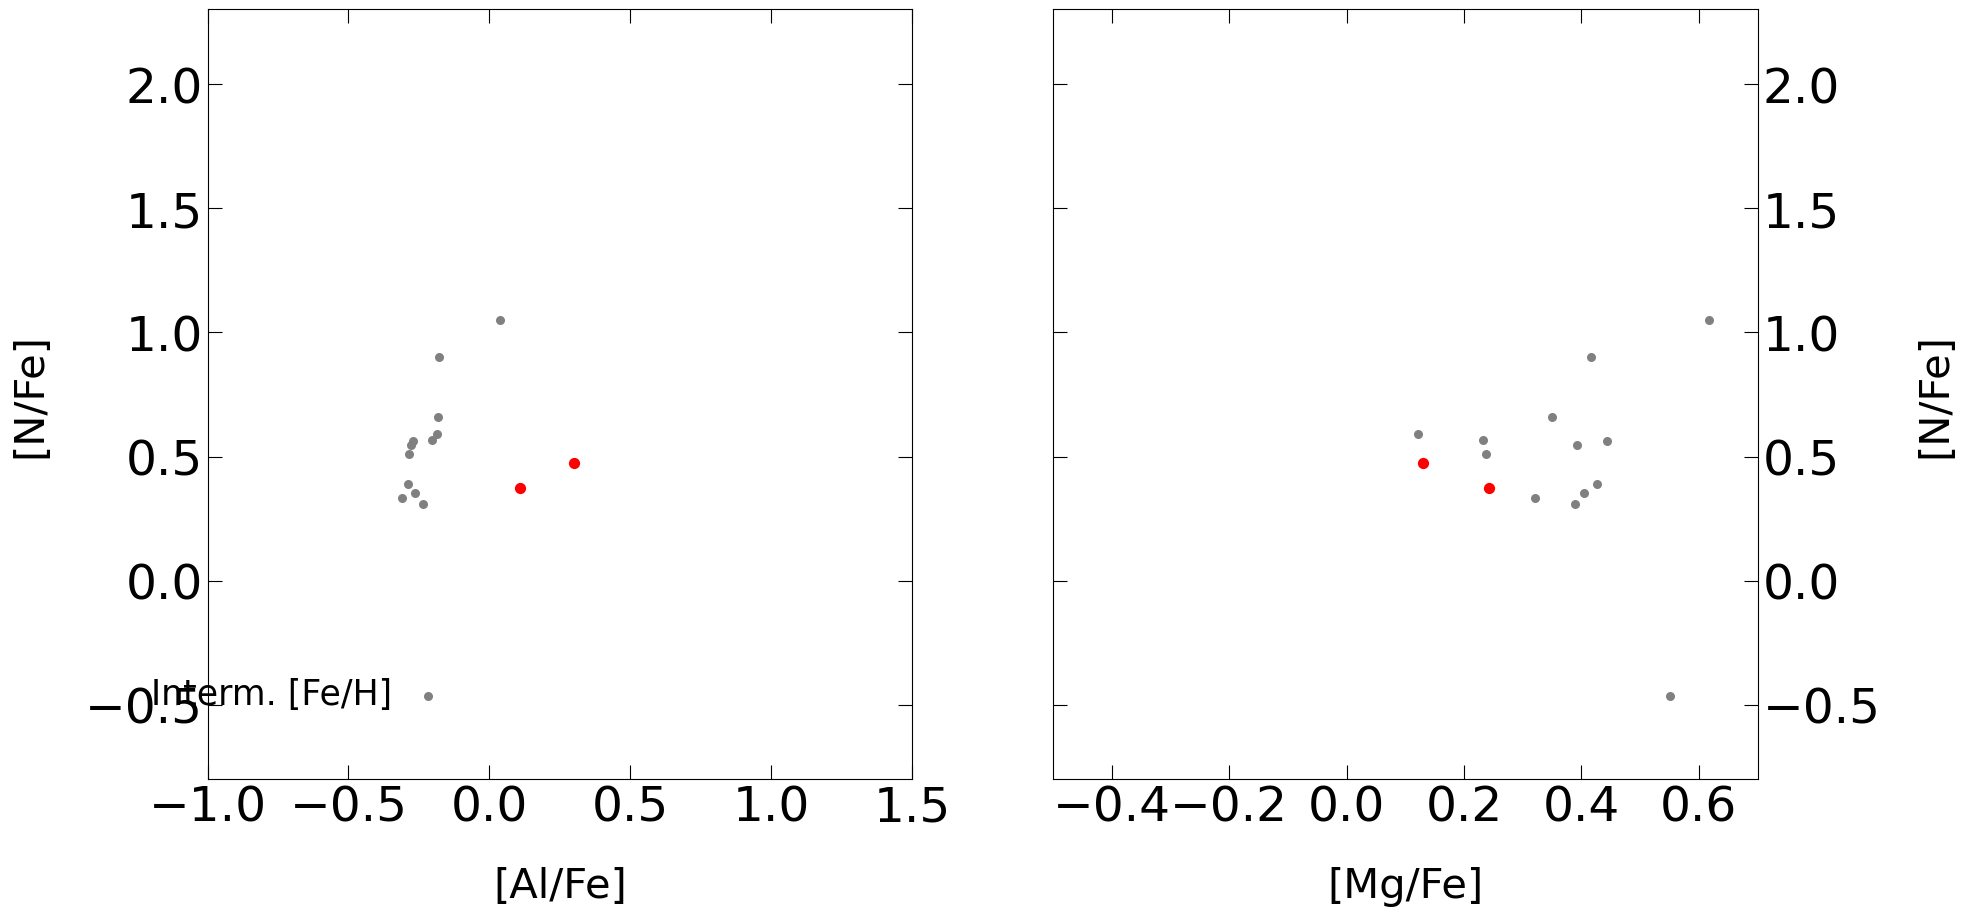

In [29]:
import matplotlib.gridspec as gridspec


# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35



gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.2, hspace=1) # set the spacing between axes. 


plt.subplot(gs[0])
plt.scatter(alfe_al[met],nfe_al[met],c='gray',s=30)
plt.scatter(alfe_al[met&G2],nfe_al[met&G2],c='r',s=50)
plt.scatter(alfe_al[met&G3],nfe_al[met&G3],c='blue',s=50)
#plt.scatter(alt,nt,c='k',alpha=1,s=15)
#plt.scatter(alt[G2],nt[G2],c='r',alpha=1,s=50)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlim(-1.,1.5)
plt.ylim(-0.8,2.3)
plt.text(-1.2,-0.5,'Interm. [Fe/H]',fontsize=25)
plt.tick_params(direction='in',right=True,top=True,length=10)

#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_n[ind]*x+b_n[ind], c='blue')



ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(mgfe_al[met],nfe_al[met],c='gray',s=30)
plt.scatter(mgfe_al[met&G2],nfe_al[met&G2],c='r',s=50)
plt.scatter(mgfe_al[met&G3],nfe_al[met&G3],c='blue',s=50)
#plt.scatter(mgt,nt,c='k',alpha=1,s=15)
#plt.scatter(mgt[G2],nt[G2],c='r',alpha=1,s=25)
plt.xticks((np.arange(-4,4,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[Mg/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.7)
plt.ylim(-0.8,2.3)
plt.tick_params(direction='in',right=True,top=True,length=10,labelright=True,labelleft=False)
#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_al[ind]*x+b_al[ind], c='blue')




#plt.savefig('train_'+ pt_name[ind] + '.png',format='png',dpi=300,bbox_inches='tight')




In [30]:
print(len(nfe_al[met&G2]))

2


# Save IDs

In [26]:
#Save high-alpha star IDs to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
col1 = fits.Column(name='APOGEE_ID', array=ids_al[met&G2], format='30A')
cols = fits.ColDefs([col1])
hdu = fits.BinTableHDU.from_columns(cols)
hdu.writeto('IDs_2G_mpoor0.fits')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000., 45000.]),
 [Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000'),
  Text(0, 20000.0, '20000'),
  Text(0, 25000.0, '25000'),
  Text(0, 30000.0, '30000'),
  Text(0, 35000.0, '35000'),
  Text(0, 40000.0, '40000'),
  Text(0, 45000.0, '45000')])

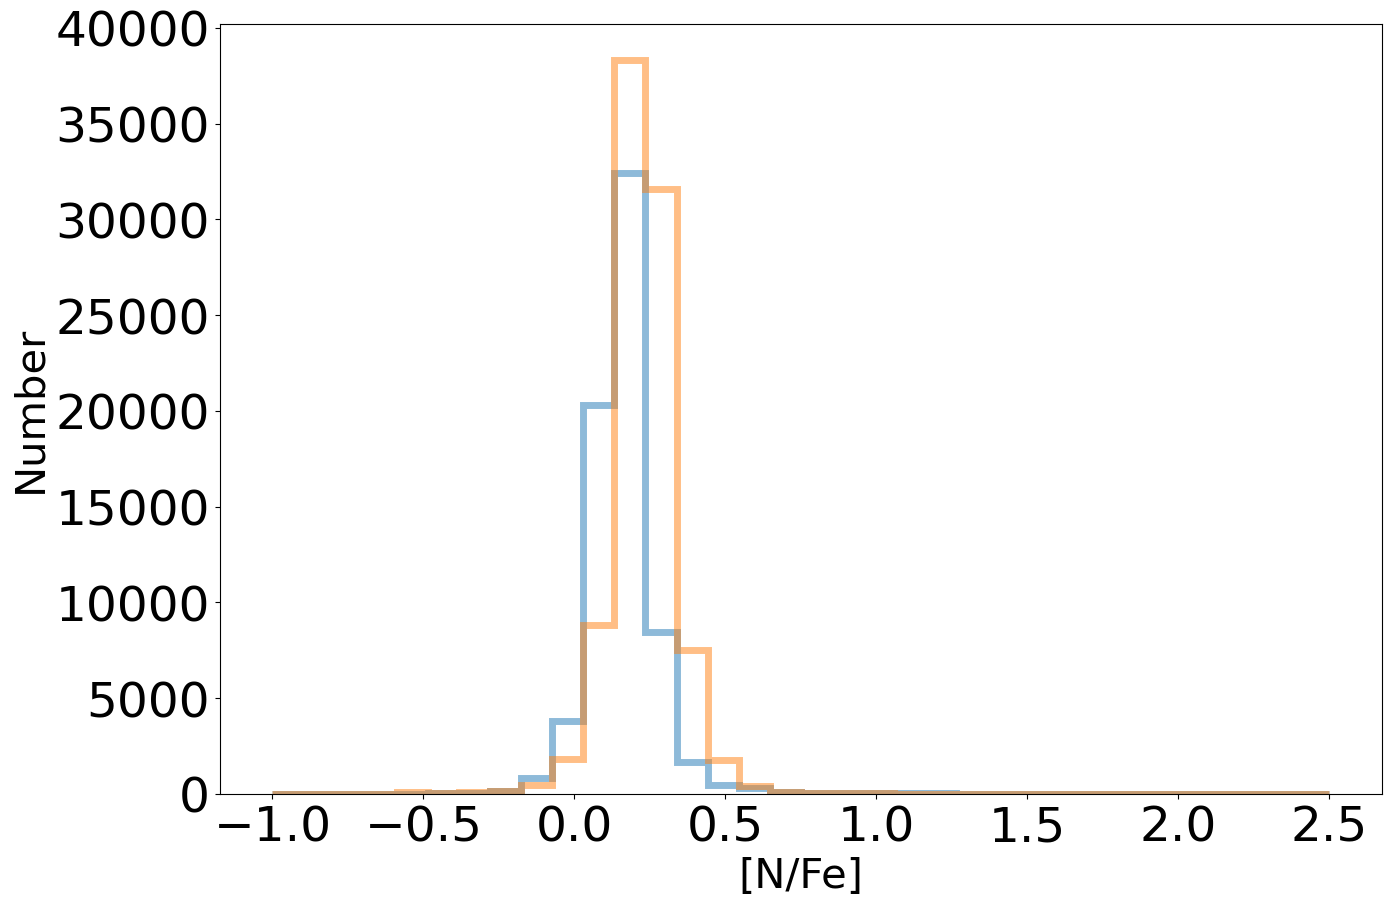

In [32]:
alrich = (alfe_al > lim)
alpoor = (alfe_al <= lim)

#Get current size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15 
fig_size[1] = 10

bins = np.linspace(-1,2.5,35)
plt.hist(nfe_al[alrich], bins, alpha=0.5, histtype='step',linewidth=5, density=False)
plt.hist(nfe_al[alpoor], bins, alpha=0.5, histtype='step',linewidth=5, density=False)
plt.xlabel('[N/Fe]',size=labs)
plt.ylabel('Number',size=labs)
plt.legend(frameon=False,fontsize=20,handletextpad=0.3,loc='upper left')
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)

#plt.savefig('hist_FeHs.png',format='png',bbox_inches='tight')



# Testing Area Below

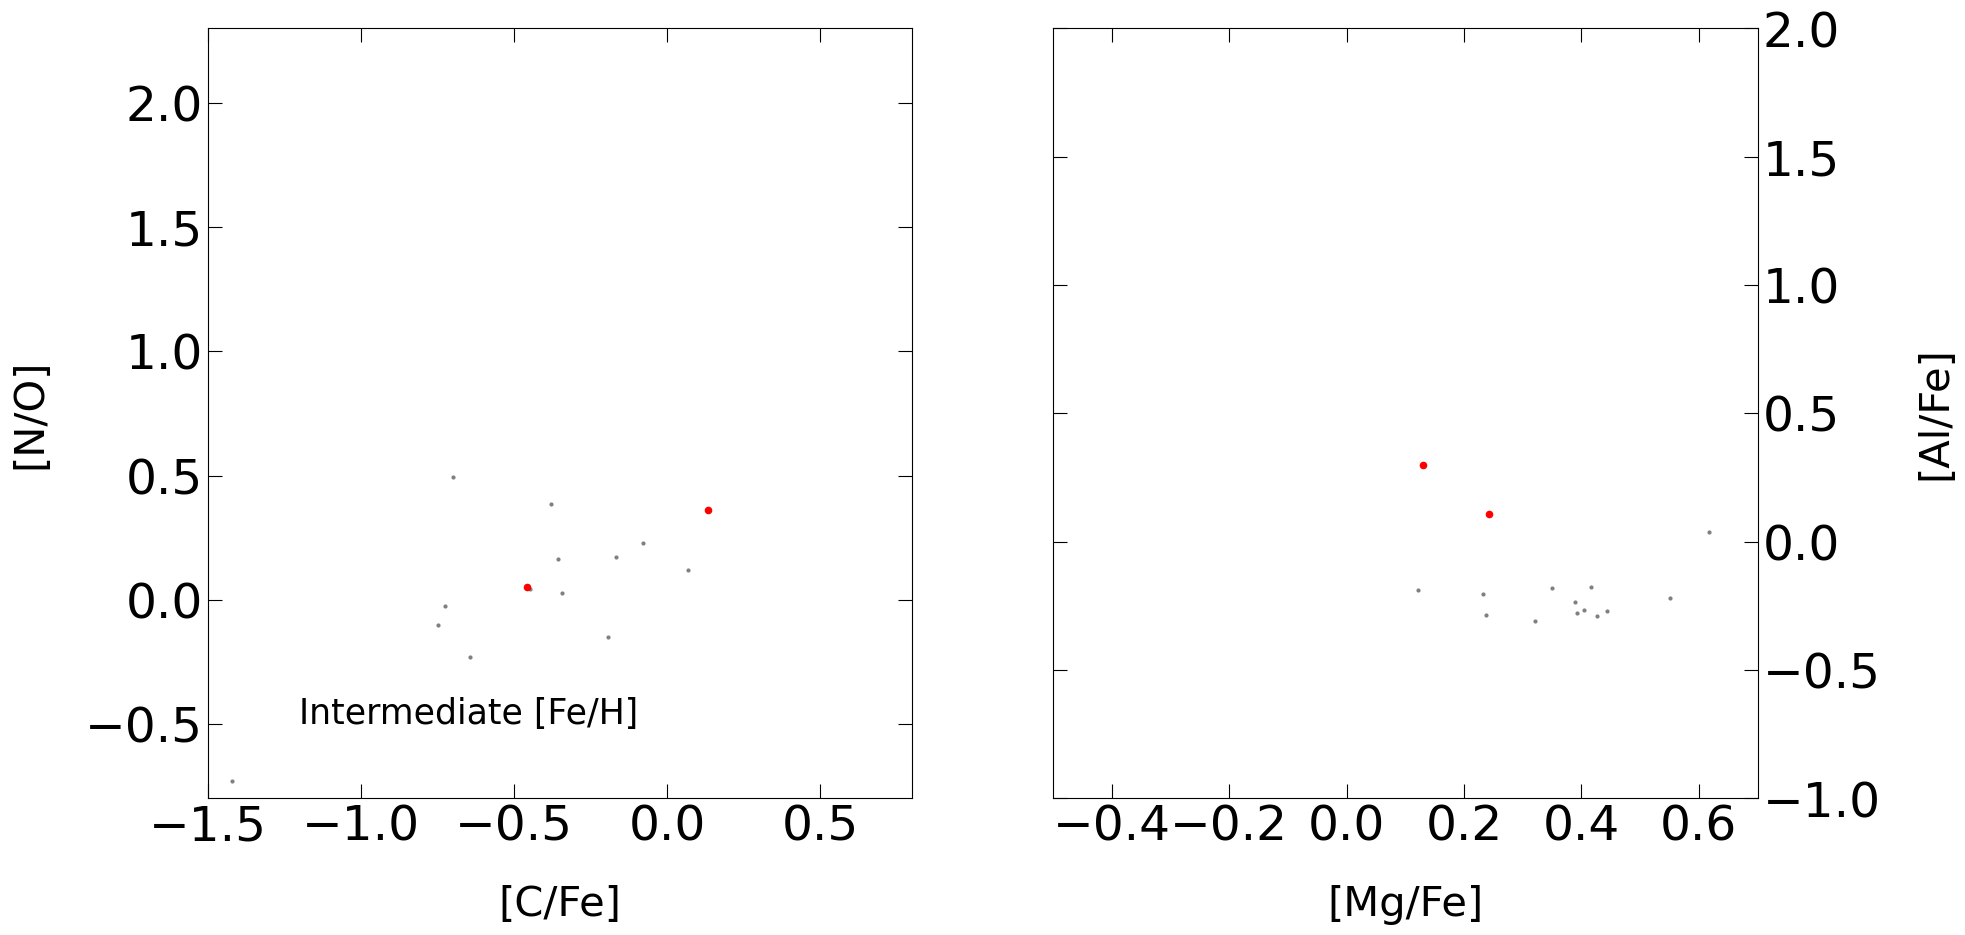

In [24]:
import matplotlib.gridspec as gridspec


# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35


#Definition of G2 stars 
lim=0.1

G2 = (alfe_al > lim) 

# These are stars with very high N abundances, absent from GC sample
# Likely debris from w Cen
G3 = nfe_al > 1.5

no_al = nfe_al - ofe_al

gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.2, hspace=1) # set the spacing between axes. 

met = ( (feh_al>fmin) & (feh_al < fmax) & (teff_al< 5000) )

plt.subplot(gs[0])
plt.scatter(cfe_al[met],no_al[met],c='gray',s=4)
plt.scatter(cfe_al[met&G2],no_al[met&G2],c='r',s=20)
plt.scatter(cfe_al[met&G3],no_al[met&G3],c='blue',s=20)
#plt.scatter(ct,nt,c='k',alpha=1,s=15)
#plt.scatter(ct[G2],nt[G2],c='r',alpha=1,s=50)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/O]',size=labs,labelpad=25)
plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.xlim(-1.5,0.8)
plt.ylim(-0.8,2.3)
plt.text(-1.2,-0.5,'Intermediate [Fe/H]',fontsize=25)
plt.tick_params(direction='in',right=True,top=True,length=10)

#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_n*x+b_n, c='blue')



ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(mgfe_al[met],alfe_al[met],c='gray',s=4)
plt.scatter(mgfe_al[met&G2],alfe_al[met&G2],c='r',s=20)
plt.scatter(mgfe_al[met&G3],alfe_al[met&G3],c='blue',s=20)
#plt.scatter(mgt,alt,c='k',alpha=1,s=15)
#plt.scatter(mgt[G2],alt[G2],c='r',alpha=1,s=25)
plt.xticks((np.arange(-4,4,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlabel('[Mg/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.7)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelright=True,labelleft=False)
#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_al*x+b_al, c='blue')




#plt.savefig('train_'+ pt_name[ind] + '.png',format='png',dpi=300,bbox_inches='tight')




In [25]:
mask_no = ( (no_al > 0.55) & (alfe_al > -0.1) )
print(len(nfe_al[met&G2]),len(nfe_al[met&G2&mask_no]))

2 0


# Generate final set for saving

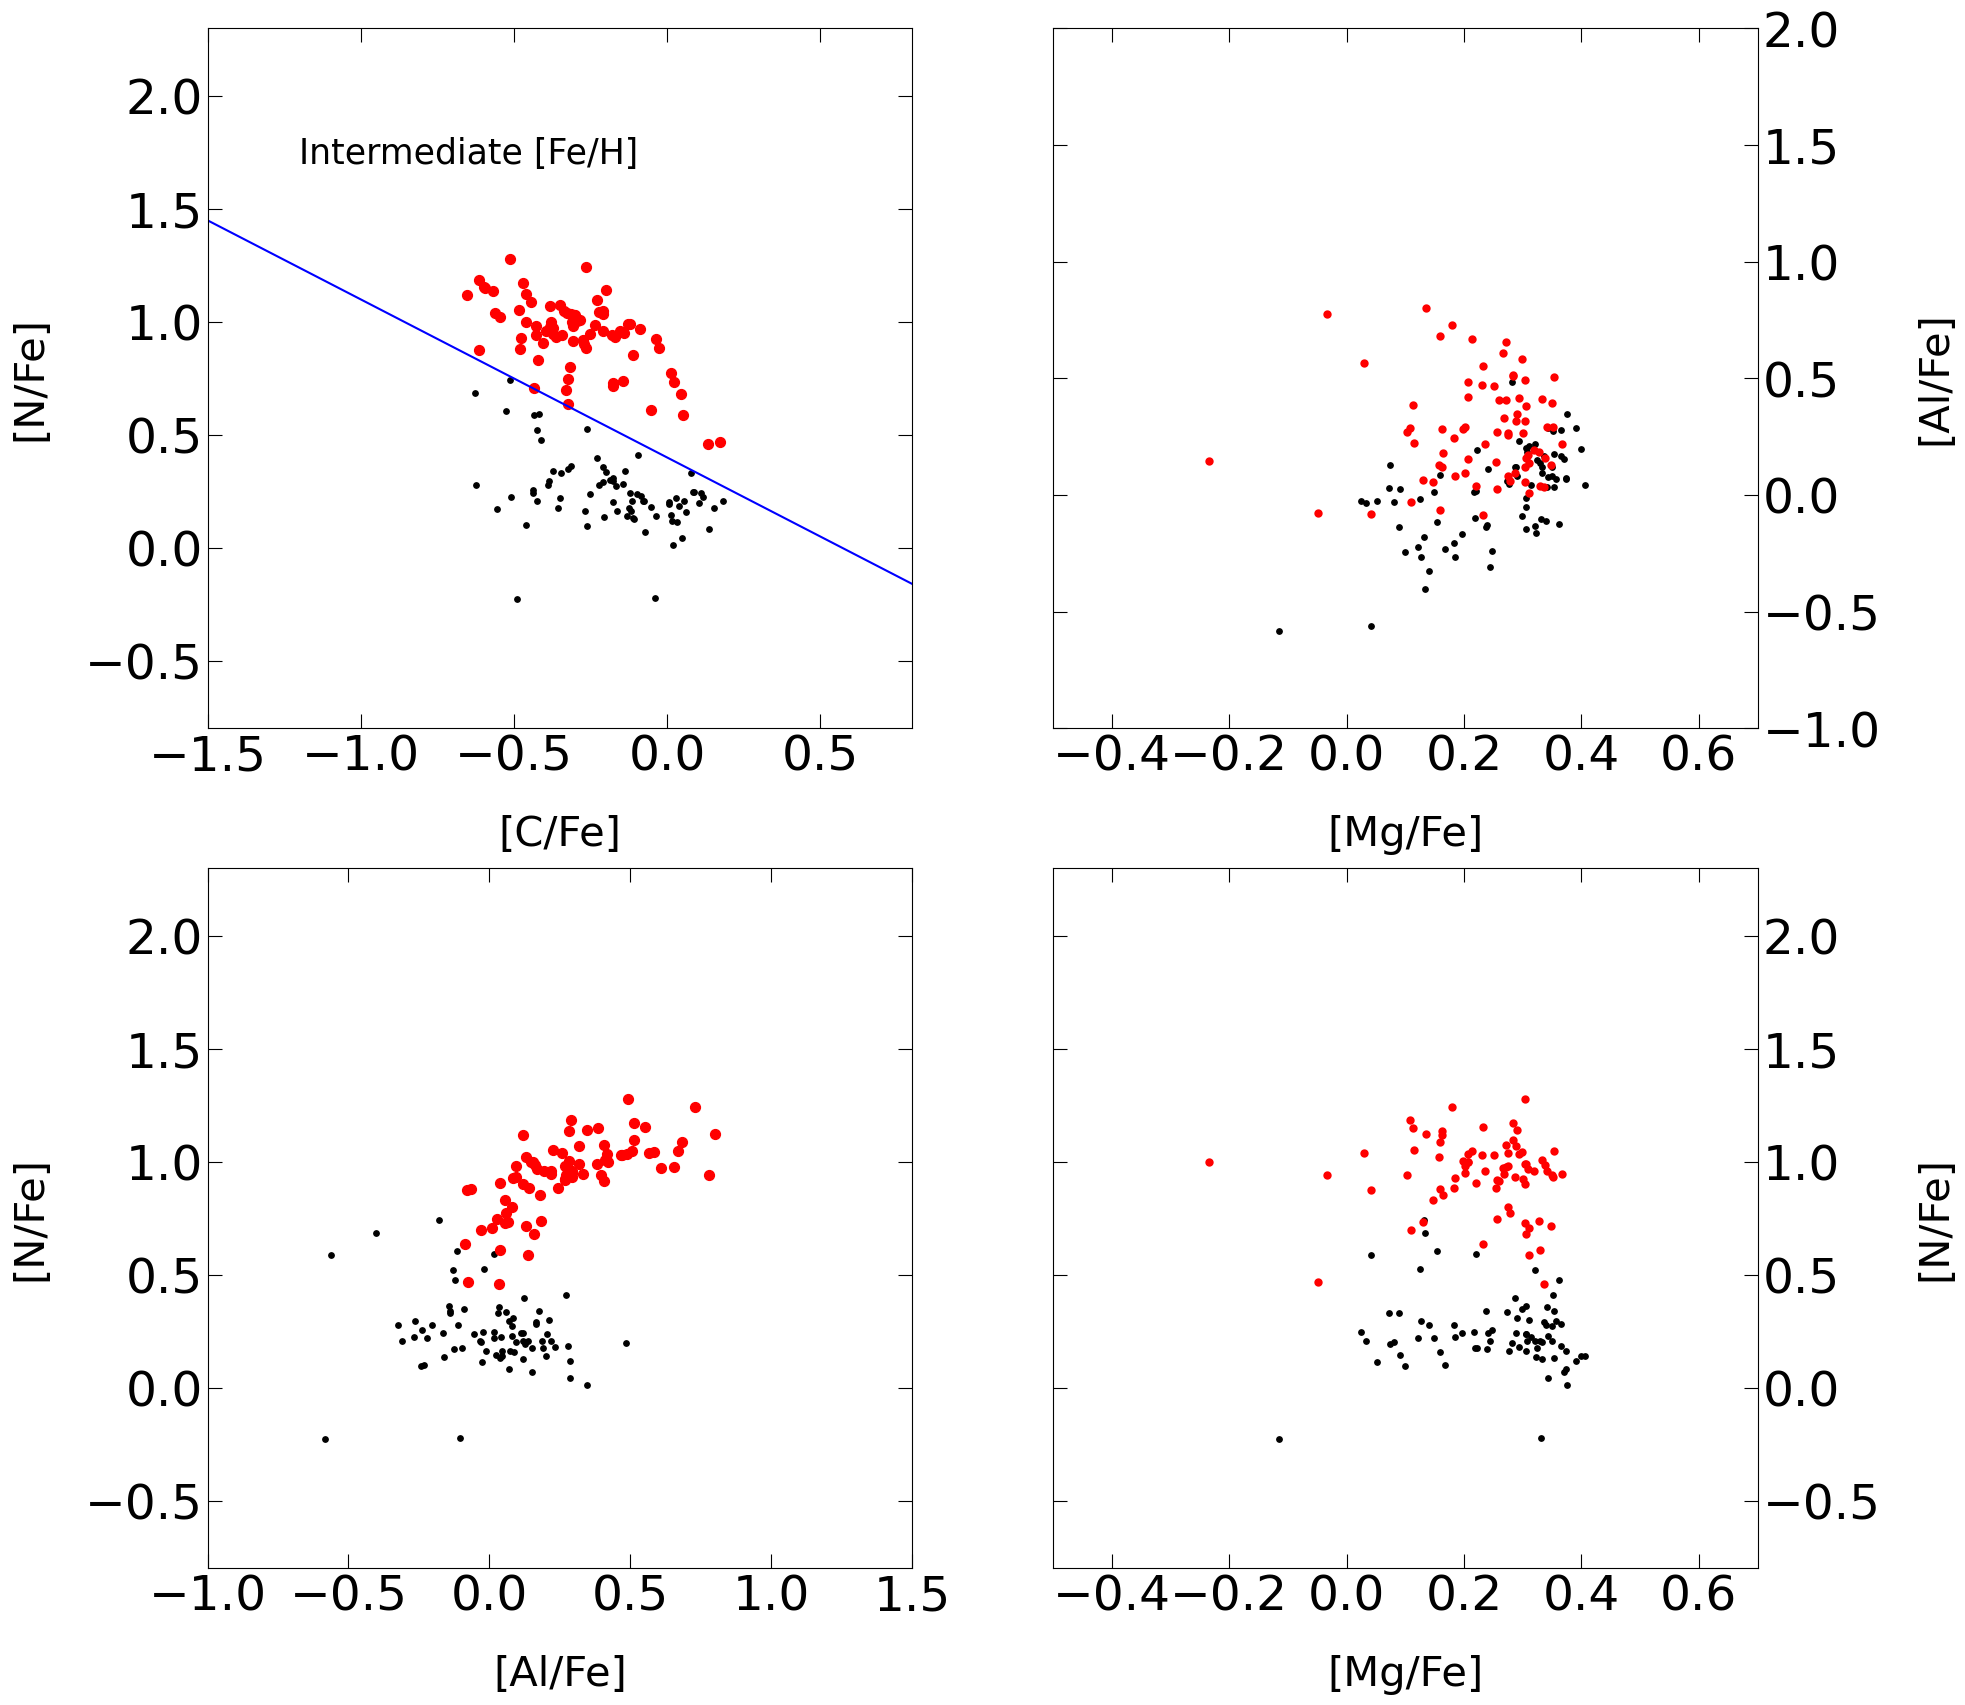

In [15]:
mask_final =  (nt > lim_n)
#mask_remove = ( (alt>0.5) & (nt<0.25) )  # Remove a few big outliers

#mask_final = mask_final & (mask_remove==False)

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 20

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35



gs = gridspec.GridSpec(2,2)
gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes. 



plt.subplot(gs[0])
plt.scatter(ct,nt,c='k',alpha=1,s=15)
plt.scatter(ct[mask_final],nt[mask_final],c='r',alpha=1,s=50)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.xlim(-1.5,0.8)
plt.ylim(-0.8,2.3)
plt.text(-1.2,1.7,'Intermediate [Fe/H]',fontsize=25)
plt.tick_params(direction='in',right=True,top=True,length=10)

#plt.plot([-2,2],[lim,lim])
x = np.arange(-1.5,1,0.1)
plt.plot(x,a_n*x+b_n, c='blue')



ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(mgt,alt,c='k',alpha=1,s=15)
plt.scatter(mgt[mask_final],alt[mask_final],c='r',alpha=1,s=25)
plt.xticks((np.arange(-4,4,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlabel('[Mg/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.7)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelright=True,labelleft=False)
#plt.plot([-2,2],[lim,lim])
x = np.arange(-1.5,1,0.1)
plt.plot(x,a_al*x+b_al, c='blue')



plt.subplot(gs[2])
plt.scatter(alt,nt,c='k',alpha=1,s=15)
plt.scatter(alt[mask_final],nt[mask_final],c='r',alpha=1,s=50)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlim(-1.,1.5)
plt.ylim(-0.8,2.3)
plt.tick_params(direction='in',right=True,top=True,length=10)

#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_n[ind]*x+b_n[ind], c='blue')



ax = plt.subplot(gs[3])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(mgt,nt,c='k',alpha=1,s=15)
plt.scatter(mgt[mask_final],nt[mask_final],c='r',alpha=1,s=25)
plt.xticks((np.arange(-4,4,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[Mg/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.7)
plt.ylim(-0.8,2.3)
plt.tick_params(direction='in',right=True,top=True,length=10,labelright=True,labelleft=False)
#plt.plot([-2,2],[lim,lim])
#x = np.arange(-1.5,1,0.1)
#plt.plot(x,a_al[ind]*x+b_al[ind], c='blue')




plt.savefig('train_OtherMetalPoor.png',format='png',dpi=300,bbox_inches='tight')




In [16]:
print(len(idt[mask_final]))

76


In [18]:
#Save high-alpha star IDs to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
col1 = fits.Column(name='APOGEE_ID', array=idt[mask_final], format='30A')
col2 = fits.Column(name='FE_H', array=fet[mask_final], format='F')
col3 = fits.Column(name='C_FE', array=ct[mask_final], format='F')
col4 = fits.Column(name='N_FE', array=nt[mask_final], format='F')
col5 = fits.Column(name='MG_FE', array=mgt[mask_final], format='F')
col6 = fits.Column(name='AL_FE', array=alt[mask_final], format='F')
cols = fits.ColDefs([col1,col2,col3,col4,col5,col6])
hdu = fits.BinTableHDU.from_columns(cols)
hdu.writeto('trainset_add_minter.fits')



In [9]:
nt = fits.open('trainset_NGC0288.fits')
newset_id = nt[1].data['APOGEE ID']
nt.close()

for i in range(1,14):
    nt = fits.open('trainset_'+pt_name[i]+'.fits')
    inter = nt[1].data['APOGEE ID']
    newset_id = np.concatenate((newset_id,inter))
    nt.close()

    

In [10]:
frange = ( (ts_fe>-1.6) & (ts_fe< -0.9) )
print(len(newset_id),len(ts_aid[frange]))

981 1464


In [13]:
aa = np.zeros(15)
bb = np.zeros(15)
#print(len(lim))

aa[0] = 0
bb[0] = 0.55

aa[1] = -0.7
bb[1] = 0.1

aa[2] = aa[1]
bb[2] = bb[1]

aa[0] = 0
bb[0] = 0.5

aa[4] = aa[1]
bb[4] = bb[1]

aa[5] = -0.7
bb[5] = 0.2

aa[6] = -0.5
bb[6] = 0.2

aa[7] = -0.5
bb[7] = 0.3

aa[8] = -0.5
bb[8] = 0.4

aa[9] = -0.7
bb[9] = 0.4

aa[10] = -0.4
bb[10] = 0.4

aa[11] = -0.4
bb[11] = 0.3

aa[12] = aa[11]
bb[12] = bb[11]

aa[13] = -0.7
bb[13] = 0.3

aa[14] = -0.7
bb[14] = 0.35

mask = name_g==pt_name[0]
lim = aa[0]*cfe_g + bb[0]
G2 = nfe_g > lim

nts_fe = feh_g[mask&G2]
nts_c = cfe_g[mask&G2]
nts_n = nfe_g[mask&G2]
nts_al = alfe_g[mask&G2]
nts_mg = mgfe_g[mask&G2]
nts_gc = name_g[mask&G2]
nts_aid = ids_g[mask&G2]

print(len(lim[mask&G2]),len(nts_fe))

for i in range(1,15):
    mask = (name_g==pt_name[i])
    print(pt_name[i])
    lim = aa[i] * cfe_g + bb[i]
    G2 = (nfe_g > lim)
    nts_fe = np.concatenate((nts_fe,feh_g[mask&G2]))
    nts_c = np.concatenate((nts_c,cfe_g[mask&G2]))
    nts_n = np.concatenate((nts_n,nfe_g[mask&G2]))
    nts_al = np.concatenate((nts_al,alfe_g[mask&G2]))
    nts_mg = np.concatenate((nts_mg,mgfe_g[mask&G2]))
    nts_gc = np.concatenate((nts_gc,name_g[mask&G2]))
    nts_aid = np.concatenate((nts_aid,ids_g[mask&G2]))




17 17
NGC0362
NGC1851
NGC1904
NGC2808
NGC3201
NGC5272
NGC5904
NGC6121
NGC6171
NGC6205
NGC6218
NGC6254
NGC6752
NGC7089


In [14]:
print(len(nts_gc))

1008


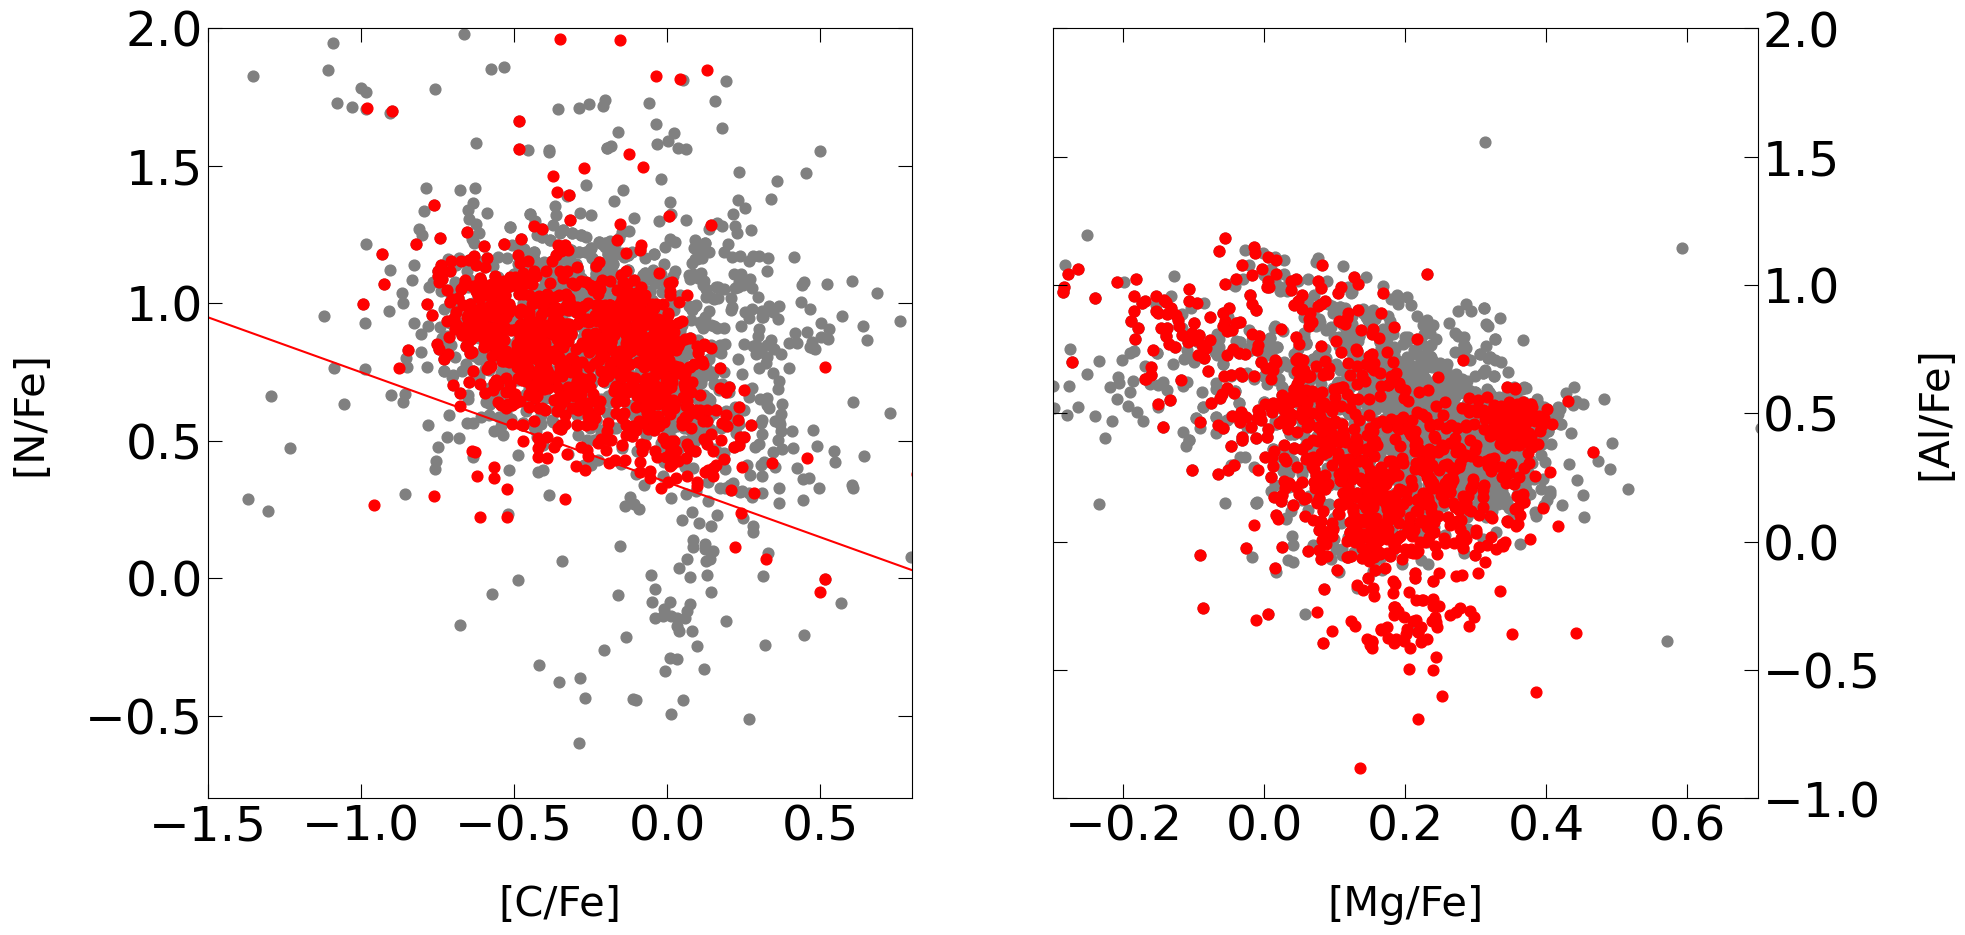

In [16]:
import matplotlib.gridspec as gridspec


# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35

#fig= plt.figure(figsize=(15,30),constrained_layout=True)

gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.2, hspace=1) # set the spacing between axes. 


plt.subplot(gs[0])
plt.scatter(ts_c,ts_n,c='gray',alpha=1,s=60)
plt.scatter(nts_c,nts_n,c='r',alpha=1,s=60)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.xlim(-1.5,0.8)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10)

#plt.plot([-2,2],[lim,lim])
x = np.arange(-1.5,1,0.1)
plt.plot(x,-0.4*x+0.35, c='red')



ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(ts_mg,ts_al,c='gray',alpha=1,s=60)
plt.scatter(nts_mg,nts_al,c='r',alpha=1,s=60)
plt.xticks((np.arange(-4,4,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlabel('[Mg/Fe]',size=labs,labelpad=25)
plt.xlim(-0.3,0.7)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelright=True,labelleft=False)



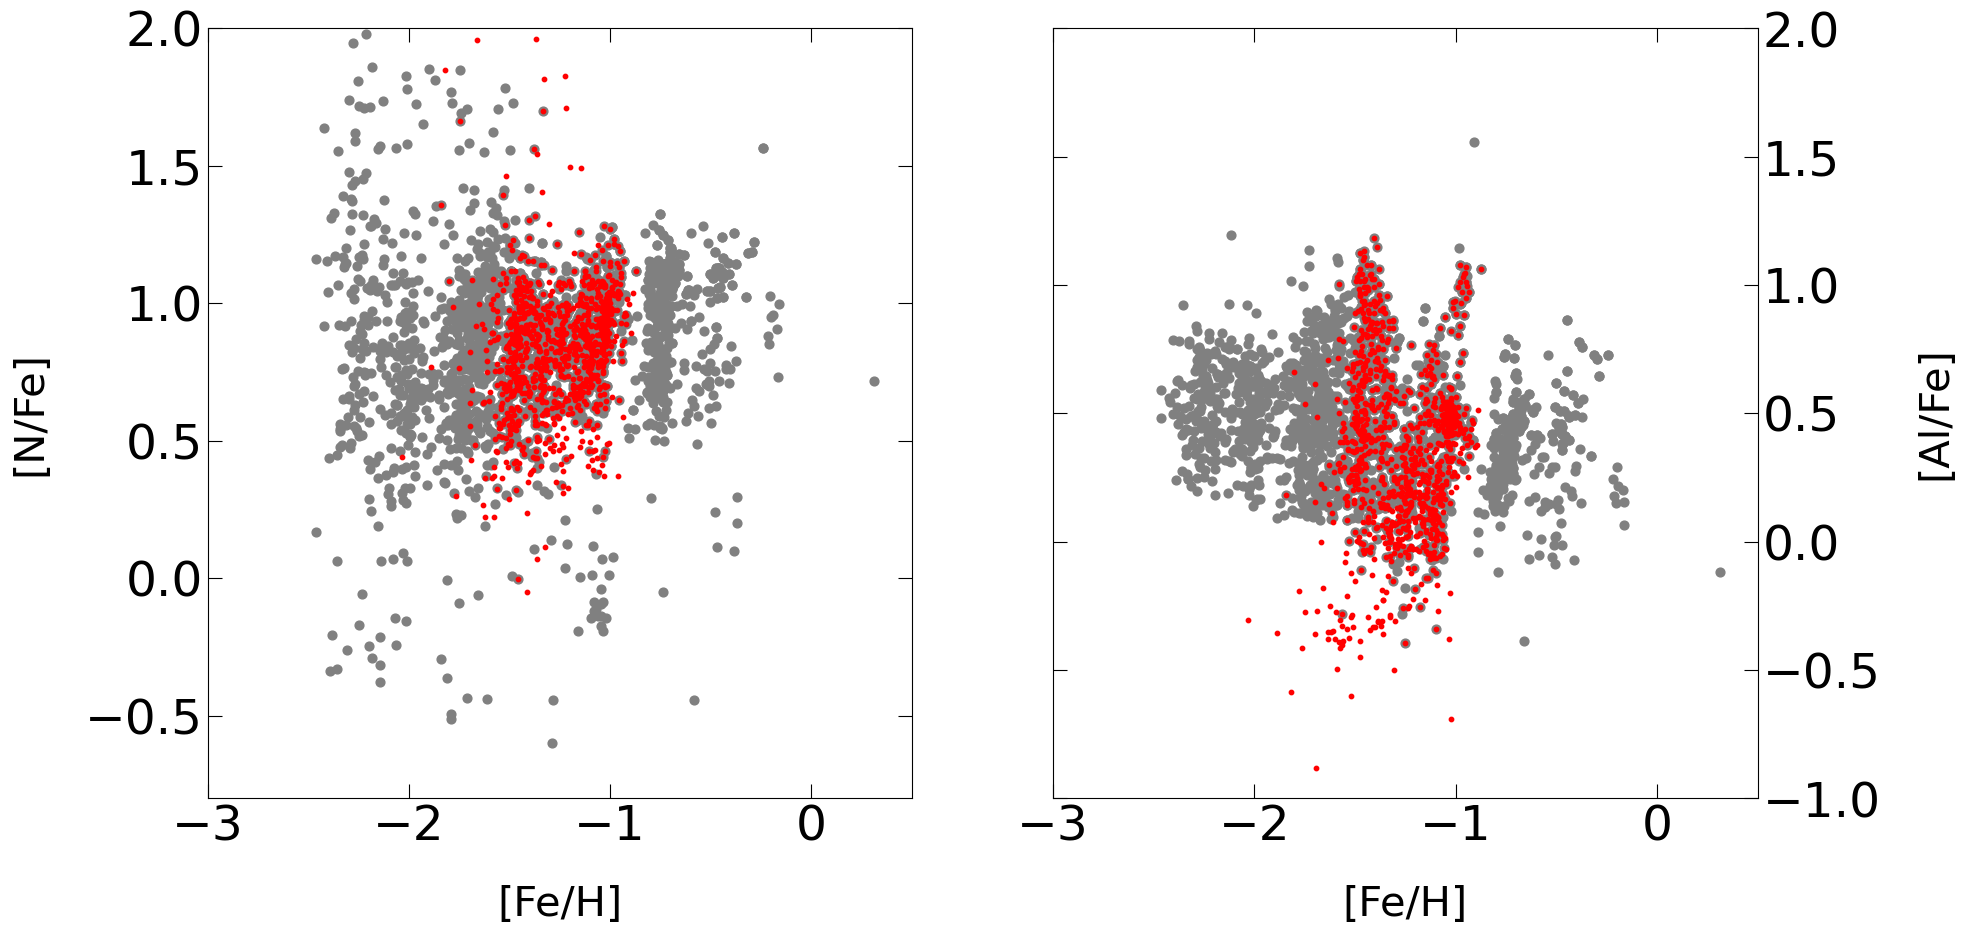

In [20]:
import matplotlib.gridspec as gridspec


# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35

#fig= plt.figure(figsize=(15,30),constrained_layout=True)

gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.2, hspace=1) # set the spacing between axes. 


plt.subplot(gs[0])
plt.scatter(ts_fe,ts_n,c='gray',alpha=1,s=40)
plt.scatter(nts_fe,nts_n,c='r',alpha=1,s=10)
plt.xticks((np.arange(-4,4,step=1)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[Fe/H]',size=labs,labelpad=25)
plt.xlim(-3,0.5)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10)


ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(ts_fe,ts_al,c='gray',alpha=1,s=40)
plt.scatter(nts_fe,nts_al,c='r',alpha=1,s=10)
plt.xticks((np.arange(-4,4,step=1)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlabel('[Fe/H]',size=labs,labelpad=25)
plt.xlim(-3,0.5)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelright=True,labelleft=False)



NameError: name 'n_cfe' is not defined

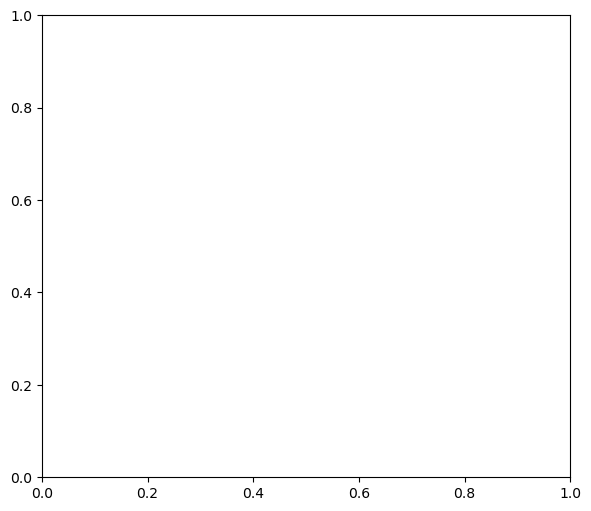

In [27]:
import matplotlib.gridspec as gridspec


# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35

fig= plt.figure(figsize=(15,30),constrained_layout=True)

gs = gridspec.GridSpec(5,2)
gs.update(wspace=0.2, hspace=0) # set the spacing between axes. 

plt.subplot(gs[0])
plt.scatter(n_cfe[(n_pred<pmax)&(n_pred>=pmin)],n_nfe[(n_pred<pmax)&(n_pred>=pmin)],c='red',alpha=0.6,s=5)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlim(-1.5,0.8)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(n_mgfe[(n_pred<pmax)&(n_pred>=pmin)],n_alfe[(n_pred<pmax)&(n_pred>=pmin)],c='red',alpha=0.6,s=5)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.9)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)


pmin=0.2
pmax=0.4

plt.subplot(gs[2])
plt.scatter(n_cfe[(n_pred<pmax)&(n_pred>=pmin)],n_nfe[(n_pred<pmax)&(n_pred>=pmin)],c='red',alpha=0.6,s=5)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlim(-1.5,0.8)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[3])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(n_mgfe[(n_pred<pmax)&(n_pred>=pmin)],n_alfe[(n_pred<pmax)&(n_pred>=pmin)],c='red',alpha=0.6,s=5)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.9)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)


pmin=0.85
pmax=0.9

plt.subplot(gs[4])
plt.scatter(n_cfe[(n_pred<pmax)&(n_pred>=pmin)],n_nfe[(n_pred<pmax)&(n_pred>=pmin)],c='red',alpha=0.6,s=5)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlim(-1.5,0.8)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[5])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(n_mgfe[(n_pred<pmax)&(n_pred>=pmin)],n_alfe[(n_pred<pmax)&(n_pred>=pmin)],c='red',alpha=0.6,s=5)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.9)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)



pmin=0.9
pmax=0.95



plt.subplot(gs[6])
plt.scatter(n_cfe[(n_pred<pmax)&(n_pred>=pmin)],n_nfe[(n_pred<pmax)&(n_pred>=pmin)],c='red',alpha=0.6,s=5)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlim(-1.5,0.8)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[7])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(n_mgfe[(n_pred<pmax)&(n_pred>=pmin)],n_alfe[(n_pred<pmax)&(n_pred>=pmin)],c='red',alpha=0.6,s=5)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.9)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)


pmin=0.95
pmax=1.0



plt.subplot(gs[8])
plt.scatter(n_cfe[(n_pred<pmax)&(n_pred>=pmin)],n_nfe[(n_pred<pmax)&(n_pred>=pmin)],c='red',alpha=0.6,s=5)
#plt.scatter(tal_c[tal_teff<9750],tal_n[tal_teff<9750],c='blue',alpha=0.6,s=6)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.xlim(-1.5,0.8)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True)

ax = plt.subplot(gs[9])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(n_mgfe[(n_pred<pmax)&(n_pred>=pmin)],n_alfe[(n_pred<pmax)&(n_pred>=pmin)],c='red',alpha=0.6,s=5)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlabel('[Mg/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.9)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True,labelright=True,labelleft=False)


plt.savefig('anticors_pred_c1.png',format='png',dpi=300,bbox_inches='tight')




['NGC4590' 'NGC4590' 'NGC5024' 'NGC5024' 'NGC6121' 'NGC6121' 'NGC6121'
 'NGC6254' 'NGC6273' 'NGC6273' 'NGC6273' 'NGC6273' 'NGC6273' 'NGC6273'
 'NGC6273' 'NGC6273' 'NGC6273' 'NGC6273' 'NGC6273' 'NGC6273' 'NGC6273'
 'NGC6273' 'NGC6293' 'NGC6293' 'NGC6293' 'NGC6293' 'NGC6341' 'NGC6341'
 'NGC6341' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656'
 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656'
 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656'
 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656'
 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6752' 'NGC6752' 'NGC6752' 'NGC6809'
 'NGC6809' 'NGC6809' 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7078'
 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7078'
 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7078'
 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7078' 'NGC7089' 'Ter9']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


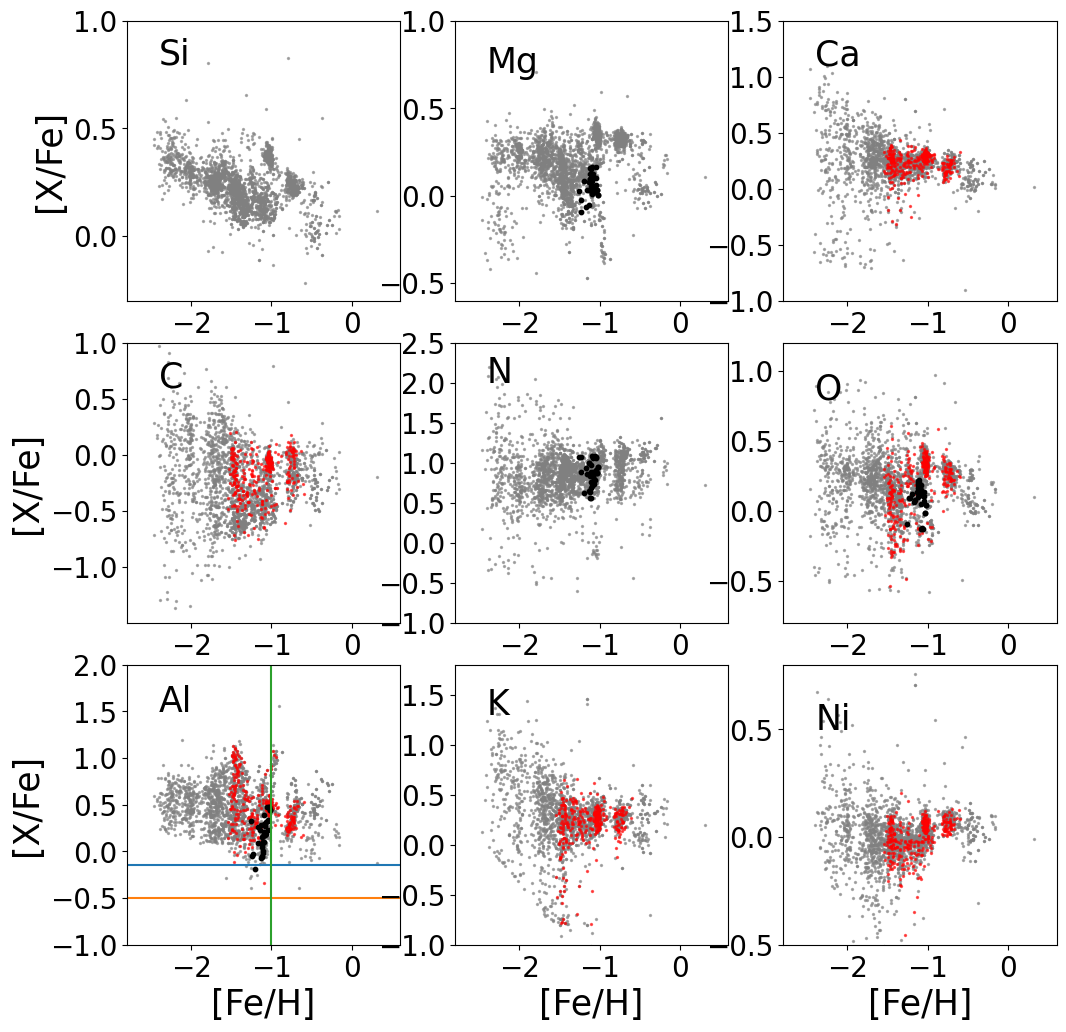

In [21]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 16 and height to 12
fig_size[0] = 12
fig_size[1] = 12

labs = 25
tcks = 20


#Calculate mean errors
#errfe = np.mean(e_feh)
#errmg = np.mean(e_mgfe)
#errmn = np.mean(e_mnfe)
#erral = np.mean(e_alfe)
#errca = np.mean(e_cafe)
#errcr = np.mean(e_crfe)
#errcu = np.mean(e_cufe)
#errsi = np.mean(e_sife)
#errti = np.mean(e_tife)
#errni = np.mean(e_nife)
#erro = np.mean(e_ofe)
#errc = np.mean(e_cfe)
#errv = np.mean(e_vfe)
#errce = np.mean(e_cefe)
#errk = np.mean(e_kfe)
#errn = np.mean(e_nfe)


gs = gridspec.GridSpec(3,3)
gs.update(wspace=0.2, hspace=0.15) # set the spacing between axes. 

pmin = 0.98
pmax = 1.0

mcut = (tal_n > -(1/3.)*tal_c+(1.1/3.))



#Identify C-rich stars
mask_hc = (tal_c > 0.6*tal_fe + 0.6)
print(tal_gc[mask_hc&(tal_teff<4750)])

pick_al = tal_gc=='NGC0362'
pick_n = tn_gc=='NGC0362'
pick_h = th_gc=='NGC0362'


plt.subplot(gs[0])
plt.scatter(tal_fe,tal_si,c='gray',alpha=0.6,s=2)
plt.scatter(tn_fe,tn_si,c='gray',alpha=0.6,s=2)
plt.scatter(th_fe,th_si,c='gray',alpha=0.6,s=2)
#plt.scatter(tal_fe[tal_teff<4750],tal_si[tal_teff<4750],c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[mask_hc&(tal_teff<4750)],tal_si[mask_hc&(tal_teff<4750)],c='blue',alpha=0.6,s=2)
plt.ylabel('[X/Fe]',size=labs)
plt.text(-2.4,0.8,'Si',fontsize=25)
plt.xticks((np.arange(-4,1,step=1)),fontsize=tcks)
plt.yticks((np.arange(-1,2.5,step=0.5)),fontsize=tcks)
plt.xlim(-2.8,0.6)
plt.ylim(-0.3,1)

#plt.plot([0-errfe,0+errfe],[0.8,0.8],c='black')
#plt.plot([0,0],[0.8-errsi,0.8+errsi],c='black')


plt.subplot(gs[1])
plt.scatter(tal_fe,tal_mg,c='gray',alpha=0.6,s=2)
plt.scatter(tn_fe,tn_mg,c='gray',alpha=0.6,s=2)
plt.scatter(th_fe,th_mg,c='gray',alpha=0.6,s=2)
plt.scatter(tal_fe[pick_al],tal_mg[pick_al],c='k',alpha=1,s=10)
plt.scatter(tn_fe[pick_n],tn_mg[pick_n],c='k',alpha=1,s=10)
plt.scatter(th_fe[pick_h],th_mg[pick_h],c='k',alpha=1,s=10)
#plt.scatter(tal_fe[tal_teff<4750],tal_mg[tal_teff<4750],c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[mask_hc&(tal_teff<4750)],tal_mg[mask_hc&(tal_teff<4750)],c='blue',alpha=0.6,s=2)
plt.text(-2.4,0.7,'Mg',fontsize=25)
plt.xticks((np.arange(-4,1,step=1)),fontsize=tcks)
plt.yticks((np.arange(-1,2.5,step=0.5)),fontsize=tcks)
plt.xlim(-2.8,0.6)
plt.ylim(-0.6,1)

#plt.plot([0-errfe,0+errfe],[0.8,0.8],c='black')
#plt.plot([0,0],[0.8-errmg,0.8+errmg],c='black')



plt.subplot(gs[2])
plt.scatter(tal_fe,tal_ca,c='gray',alpha=0.6,s=2)
plt.scatter(tn_fe,tn_ca,c='gray',alpha=0.6,s=2)
plt.scatter(th_fe,th_ca,c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[tal_teff<4750],tal_ca[tal_teff<4750],c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[mask_hc&(tal_teff<4750)],tal_ca[mask_hc&(tal_teff<4750)],c='blue',alpha=0.6,s=2)
plt.text(-2.4,1.1,'Ca',fontsize=25)
plt.xticks((np.arange(-4,1,step=1)),fontsize=tcks)
plt.yticks((np.arange(-1,2.5,step=0.5)),fontsize=tcks)
plt.xlim(-2.8,0.6)
plt.ylim(-1,1.5)

#plt.plot([0-errfe,0+errfe],[1.2,1.2],c='black')
#plt.plot([0,0],[1.2-errca,1.2+errca],c='black')



plt.subplot(gs[3])
plt.scatter(tal_fe,tal_c,c='gray',alpha=0.6,s=2)
plt.scatter(tn_fe,tn_c,c='gray',alpha=0.6,s=2)
plt.scatter(th_fe,th_c,c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[(tal_teff<4750)],tal_c[(tal_teff<4750)],c='gray',alpha=0.6,s=2)
#plt.scatter(tal_fe[(tal_teff<4750)&mcut],tal_c[(tal_teff<4750)&mcut],c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[mask_hc&(tal_teff<4750)],tal_c[mask_hc&(tal_teff<4750)],c='blue',alpha=0.6,s=2)
plt.ylabel('[X/Fe]',size=labs)
plt.text(-2.4,0.6,'C',fontsize=25)
plt.xticks((np.arange(-4,1,step=1)),fontsize=tcks)
plt.yticks((np.arange(-1,2.5,step=0.5)),fontsize=tcks)
plt.xlim(-2.8,0.6)
plt.ylim(-1.5,1)



#plt.plot([0-errfe,0+errfe],[0.6,0.6],c='black')
#plt.plot([0,0],[0.6-errc,0.6+errc],c='black')


plt.subplot(gs[4])
plt.scatter(tal_fe,tal_n,c='gray',alpha=0.6,s=2)
plt.scatter(tn_fe,tn_n,c='gray',alpha=0.6,s=2)
plt.scatter(th_fe,th_n,c='gray',alpha=0.6,s=2)
plt.scatter(tal_fe[pick_al],tal_n[pick_al],c='k',alpha=1,s=10)
plt.scatter(tn_fe[pick_n],tn_n[pick_n],c='k',alpha=1,s=10)
plt.scatter(th_fe[pick_h],th_n[pick_h],c='k',alpha=1,s=10)
#plt.scatter(tal_fe[(tal_teff<4750)],tal_n[(tal_teff<4750)],c='gray',alpha=0.6,s=2)
#plt.scatter(tal_fe[(tal_teff<4750)&mcut],tal_n[(tal_teff<4750)&mcut],c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[tal_teff<4750&(n_cfe>0.0)],tal_n[tal_teff<4750&(n_cfe>0.0)],c='black',alpha=0.6,s=5)
#plt.scatter(tal_fe[mask_hc&(tal_teff<4750)],tal_n[mask_hc&(tal_teff<4750)],c='blue',alpha=0.6,s=2)
plt.text(-2.4,2,'N',fontsize=25)
plt.xticks((np.arange(-4,1,step=1)),fontsize=tcks)
plt.yticks((np.arange(-1,3.0,step=0.5)),fontsize=tcks)
plt.xlim(-2.8,0.6)
plt.ylim(-1,2.5)

#plt.plot([0-errfe,0+errfe],[1.95,1.95],c='black')
#plt.plot([0,0],[1.95-errn,1.95+errn],c='black')


plt.subplot(gs[5])
plt.scatter(tal_fe,tal_o,c='gray',alpha=0.6,s=2)
plt.scatter(tn_fe,tn_o,c='gray',alpha=0.6,s=2)
plt.scatter(th_fe,th_o,c='red',alpha=0.6,s=2)
plt.scatter(tal_fe[pick_al],tal_o[pick_al],c='k',alpha=1,s=10)
plt.scatter(tn_fe[pick_n],tn_o[pick_n],c='k',alpha=1,s=10)
plt.scatter(th_fe[pick_h],th_o[pick_h],c='k',alpha=1,s=10)
#plt.scatter(tal_fe[tal_teff<4750],tal_o[tal_teff<4750],c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[mask_hc&(tal_teff<4750)],tal_o[mask_hc&(tal_teff<4750)],c='blue',alpha=0.6,s=2)
plt.text(-2.4,0.8,'O',fontsize=25)
plt.xticks((np.arange(-4,1,step=1)),fontsize=tcks)
plt.yticks((np.arange(-1,2.5,step=0.5)),fontsize=tcks)
plt.xlim(-2.8,0.6)
plt.ylim(-0.8,1.2)

#plt.plot([0-errfe,0+errfe],[0.9,0.9],c='black')
#plt.plot([0,0],[0.9-erro,0.9+erro],c='black')


plt.subplot(gs[6])
plt.scatter(tal_fe,tal_al,c='gray',alpha=0.6,s=2)
plt.scatter(tn_fe,tn_al,c='gray',alpha=0.6,s=2)
plt.scatter(th_fe,th_al,c='red',alpha=0.6,s=2)
plt.scatter(tal_fe[pick_al],tal_al[pick_al],c='k',alpha=1,s=10)
plt.scatter(tn_fe[pick_n],tn_al[pick_n],c='k',alpha=1,s=10)
plt.scatter(th_fe[pick_h],th_al[pick_h],c='k',alpha=1,s=10)
#plt.scatter(tal_fe[tal_teff<4750],tal_al[tal_teff<4750],c='gray',alpha=0.6,s=2)
#plt.scatter(tal_fe[(tal_teff<4750)&mcut],tal_al[(tal_teff<4750)&mcut],c='red',alpha=0.6,s=2)
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[X/Fe]',size=labs)
plt.text(-2.4,1.5,'Al',fontsize=25)
plt.xticks((np.arange(-4,1,step=1)),fontsize=tcks)
plt.yticks((np.arange(-1,2.5,step=0.5)),fontsize=tcks)
plt.xlim(-2.8,0.6)
plt.ylim(-1,2)
plt.plot([-5,5],[-0.15,-0.15])
plt.plot([-5,5],[-0.5,-0.5])
plt.plot([-1,-1],[-5,5])

#plt.plot([0-errfe,0+errfe],[1.5,1.5],c='black')
#plt.plot([0,0],[1.5-erral,1.5+erral],c='black')


plt.subplot(gs[7])
plt.scatter(tal_fe,tal_k,c='gray',alpha=0.6,s=2)
plt.scatter(tn_fe,tn_k,c='gray',alpha=0.6,s=2)
plt.scatter(th_fe,th_k,c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[tal_teff<4750],tal_k[tal_teff<4750],c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[mask_hc&(tal_teff<4750)],tal_k[mask_hc&(tal_teff<4750)],c='blue',alpha=0.6,s=2)
plt.xlabel('[Fe/H]',size=labs)
plt.text(-2.4,1.3,'K',fontsize=25)
plt.xticks((np.arange(-4,1,step=1)),fontsize=tcks)
plt.yticks((np.arange(-1,2.5,step=0.5)),fontsize=tcks)
plt.xlim(-2.8,0.6)
plt.ylim(-1,1.8)

#plt.plot([0-errfe,0+errfe],[1.35,1.35],c='black')
#plt.plot([0,0],[1.35-errk,1.35+errk],c='black')


plt.subplot(gs[8])
plt.scatter(tal_fe,tal_ni,c='gray',alpha=0.6,s=2)
plt.scatter(tn_fe,tn_ni,c='gray',alpha=0.6,s=2)
plt.scatter(th_fe,th_ni,c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[tal_teff<4750],tal_ni[tal_teff<4750],c='red',alpha=0.6,s=2)
#plt.scatter(tal_fe[mask_hc&(tal_teff<4750)],tal_ni[mask_hc&(tal_teff<4750)],c='blue',alpha=0.6,s=2)
plt.xlabel('[Fe/H]',size=labs)
plt.text(-2.4,0.5,'Ni',fontsize=25)
plt.xticks((np.arange(-4,1,step=1)),fontsize=tcks)
plt.yticks((np.arange(-1,2.5,step=0.5)),fontsize=tcks)
plt.xlim(-2.8,0.6)
plt.ylim(-0.5,0.8)

#plt.plot([0-errfe,0+errfe],[0.6,0.6],c='black')
#plt.plot([0,0],[0.6-errni,0.6+errni],c='black')



plt.savefig('abunds.eps',format='eps',dpi=300,bbox_inches='tight')



(4.0, -0.3)

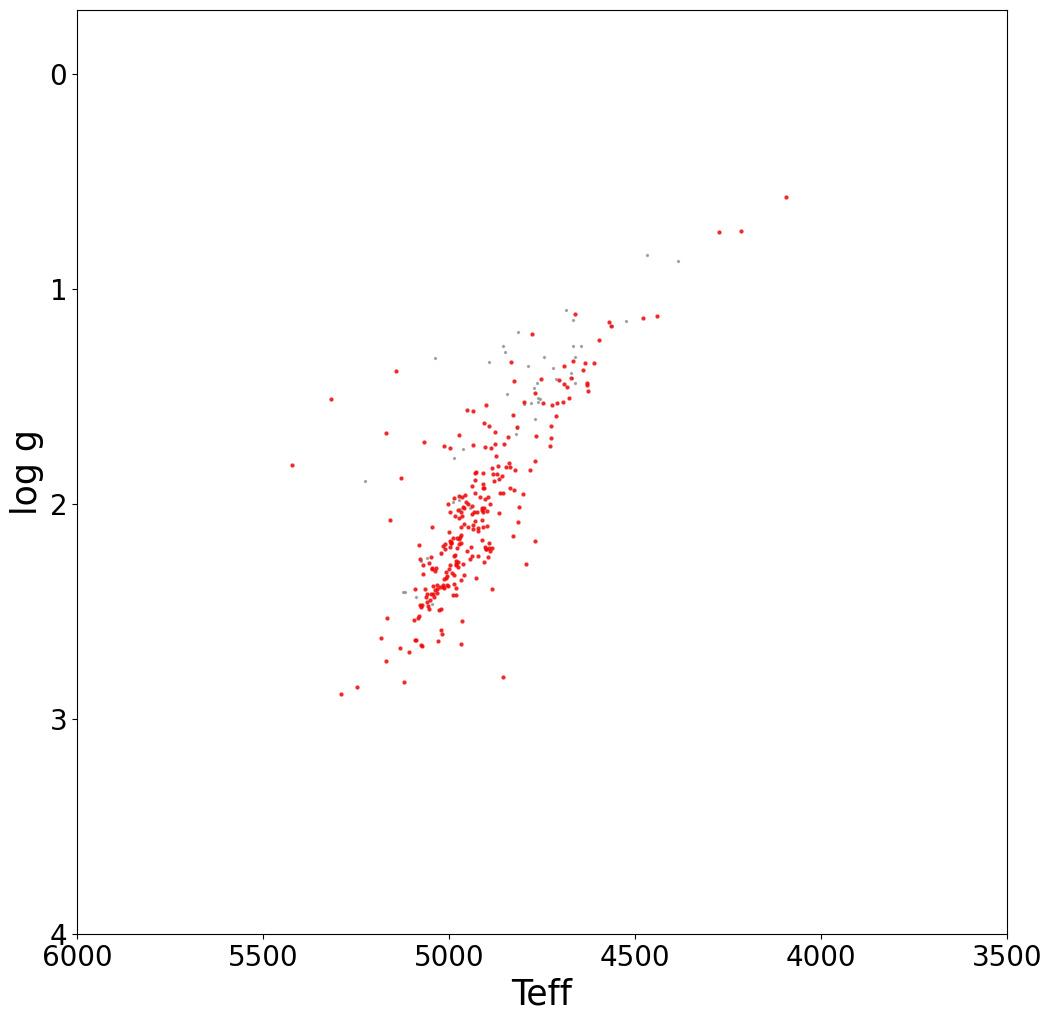

In [6]:
plt.scatter(tal_teff[(tal_gc=='NGC6656')&(tal_teff<9750)],tal_logg[(tal_gc=='NGC6656')&(tal_teff<9750)],c='gray',alpha=0.6,s=2)
plt.scatter(tal_teff[(tal_gc=='NGC6656')&mask_hc&(tal_teff<9750)],tal_logg[(tal_gc=='NGC6656')&mask_hc&(tal_teff<9750)],c='red',alpha=0.6,s=5)
#plt.scatter(tal_teff[(tal_gc=='NGC7078')&(tal_teff<9750)],tal_logg[(tal_gc=='NGC7078')&(tal_teff<9750)],c='blue',alpha=0.6,s=2)
#plt.scatter(tal_teff[(tal_gc=='NGC7078')&mask_hc&(tal_teff<9750)],tal_logg[(tal_gc=='NGC7078')&mask_hc&(tal_teff<9750)],c='red',alpha=0.6,s=5)
plt.ylabel('log g',size=labs)
plt.xlabel('Teff',size=labs)
plt.xticks((np.arange(7000,2000,step=-500)),fontsize=tcks)
plt.yticks((np.arange(5,-2,step=-1)),fontsize=tcks)
plt.xlim(6000,3500)
plt.ylim(4,-0.3)



# The conclusion here is that the Al-rich, N-rich, C-rich stars at low metallicity are not AGB stars.

/Users/astrschi/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)


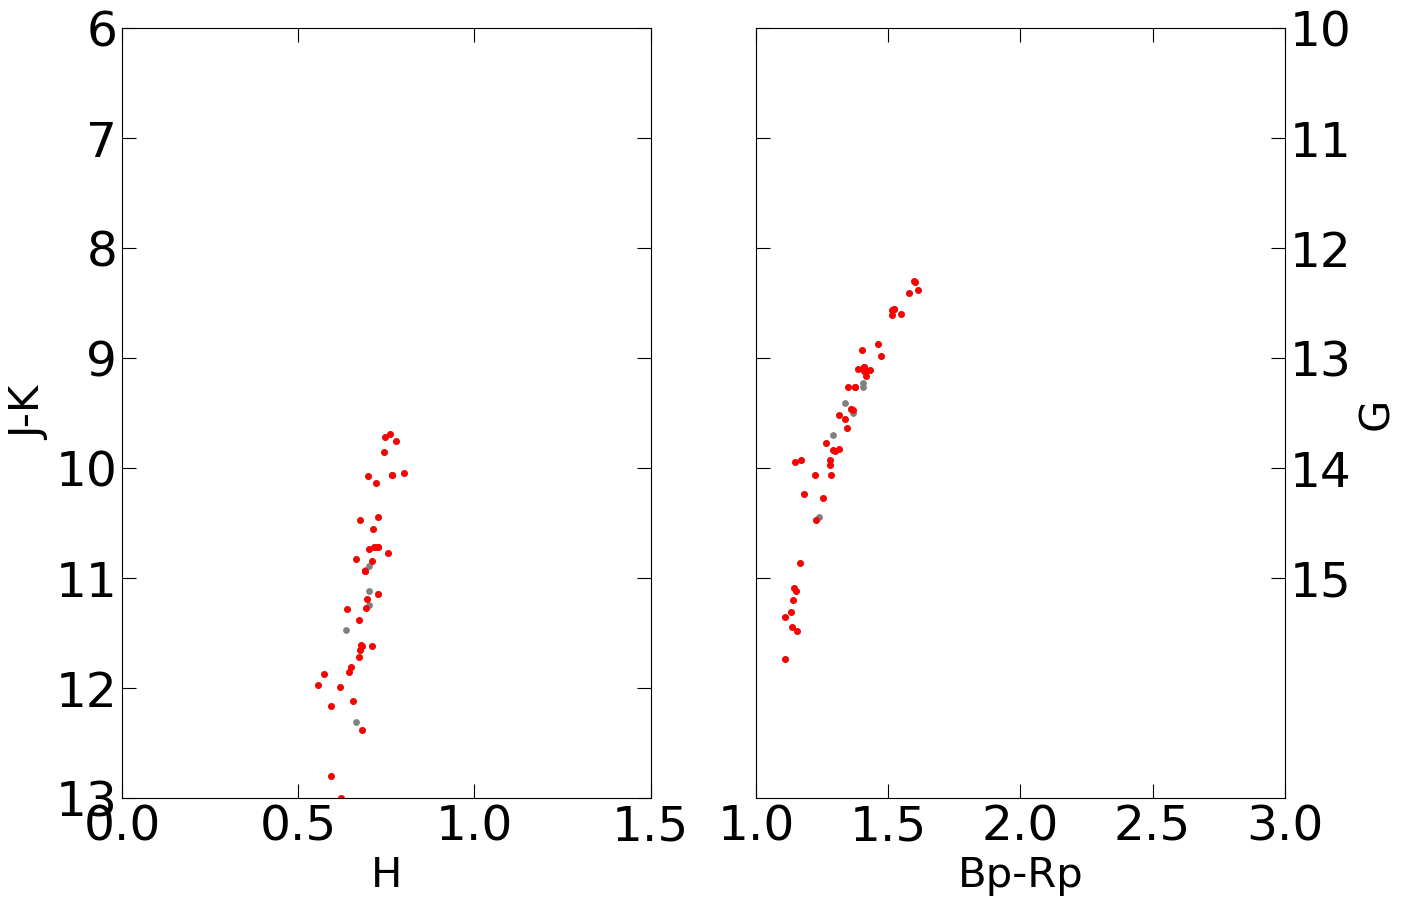

In [7]:

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35

fig= plt.figure(figsize=(15,10),constrained_layout=True)

gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.2, hspace=0) # set the spacing between axes. 

clname='NGC7078'
tefflim=5000.


tal_jk = tal_jj - tal_kk

plt.subplot(gs[0])
plt.scatter(tal_jk[(tal_gc==clname)&(tal_teff<tefflim)],tal_hh[(tal_gc==clname)&(tal_teff<tefflim)],c='gray',alpha=1,s=15)
plt.scatter(tal_jk[(tal_gc==clname)&mask_hc&(tal_teff<tefflim)],tal_hh[(tal_gc==clname)&mask_hc&(tal_teff<tefflim)],c='red',alpha=1,s=15)
#plt.scatter(tal_teff[(tal_gc=='NGC7078')&(tal_teff<9750)],tal_logg[(tal_gc=='NGC7078')&(tal_teff<9750)],c='blue',alpha=0.6,s=2)
#plt.scatter(tal_teff[(tal_gc=='NGC7078')&mask_hc&(tal_teff<9750)],tal_logg[(tal_gc=='NGC7078')&mask_hc&(tal_teff<9750)],c='red',alpha=0.6,s=5)
plt.ylabel('J-K',size=labs)
plt.xlabel('H',size=labs)
plt.xticks((np.arange(-2,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(15,0,step=-1)),fontsize=tcks)
plt.xlim(0,1.5)
plt.ylim(13,6)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True)


tal_br = tal_bp - tal_rp

ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(tal_br[(tal_gc==clname)&(tal_teff<tefflim)],tal_g[(tal_gc==clname)&(tal_teff<tefflim)],c='gray',alpha=1,s=15)
plt.scatter(tal_br[(tal_gc==clname)&mask_hc&(tal_teff<tefflim)],tal_g[(tal_gc==clname)&mask_hc&(tal_teff<tefflim)],c='red',alpha=1,s=15)
#plt.scatter(tal_teff[(tal_gc=='NGC7078')&(tal_teff<9750)],tal_logg[(tal_gc=='NGC7078')&(tal_teff<9750)],c='blue',alpha=0.6,s=2)
#plt.scatter(tal_teff[(tal_gc=='NGC7078')&mask_hc&(tal_teff<9750)],tal_logg[(tal_gc=='NGC7078')&mask_hc&(tal_teff<9750)],c='red',alpha=0.6,s=5)
plt.ylabel('G',size=labs)
plt.xlabel('Bp-Rp',size=labs)
plt.xticks((np.arange(-2,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(15,0,step=-1)),fontsize=tcks)
plt.xlim(1,3)
plt.ylim(17,10)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True,labelright=True,labelleft=False)





# Read VAC

In [8]:

#Reading the table containing DR16+ data
g = fits.open('../VAC/Final_May2022/GC_VAC_v1/VAC_GC_DR17_synspec_rev1-v1_1.fits')
g_id = g[1].data['APOGEE_ID']
g_gc = g[1].data['GC_NAME']
g_gid = g[1].data['GAIAEDR3_SOURCE_ID']
g_ra = g[1].data['RA']
g_dec = g[1].data['DEC']
g_glon = g[1].data['GLON']
g_glat = g[1].data['GLAT']
g_vscat = g[1].data['VSCATTER']
g_nvis = g[1].data['NVISITS']
g_teff = g[1].data['TEFF']
g_teff_e = g[1].data['TEFF_ERR']
g_logg = g[1].data['LOGG']
g_logg_e = g[1].data['LOGG_ERR']
g_sn = g[1].data['SNR']
g_rv = g[1].data['VHELIO_AVG']

g_jmag = g[1].data['J']
g_hmag = g[1].data['H']
g_kmag = g[1].data['K']

g_fe = g[1].data['Fe_H']
g_mg = g[1].data['Mg_Fe']
g_c = g[1].data['C_Fe']
g_ci = g[1].data['CI_Fe']
g_o = g[1].data['O_Fe']
g_n = g[1].data['N_Fe']
g_ca = g[1].data['Ca_Fe']
g_si = g[1].data['Si_Fe']
g_ni = g[1].data['Ni_Fe']
g_al = g[1].data['Al_Fe']
g_ti = g[1].data['Ti_Fe']
g_co = g[1].data['Co_Fe']
g__s = g[1].data['S_Fe']
g_k = g[1].data['K_Fe']
g_p = g[1].data['P_Fe']
g_ce = g[1].data['Ce_Fe']
g_v = g[1].data['V_Fe']
g_cr = g[1].data['Cr_Fe']
g_na = g[1].data['Na_Fe']
g_mn = g[1].data['Mg_Fe']
g_cu = g[1].data['Cu_Fe']
g_sflag = g[1].data['STARFLAG']
g_aflag = g[1].data['ASPCAPFLAG']
g_eal = g[1].data['Al_FE_ERR']
g_emg = g[1].data['MG_FE_ERR']
g_emn = g[1].data['MN_FE_ERR']

g_jmag = g[1].data['J']
g_hmag = g[1].data['H']
g_kmag = g[1].data['K']
g_a_k = g[1].data['AK_TARG']
g_i36 = g[1].data['IRAC_3_6']
g_i45 = g[1].data['IRAC_4_5']
g_i80 = g[1].data['IRAC_8_0']


print(len(g_id))


7737


['NGC5466' 'NGC6273' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656' 'NGC6656'
 'NGC6656' 'NGC6656' 'NGC6809' 'NGC7078']
7737


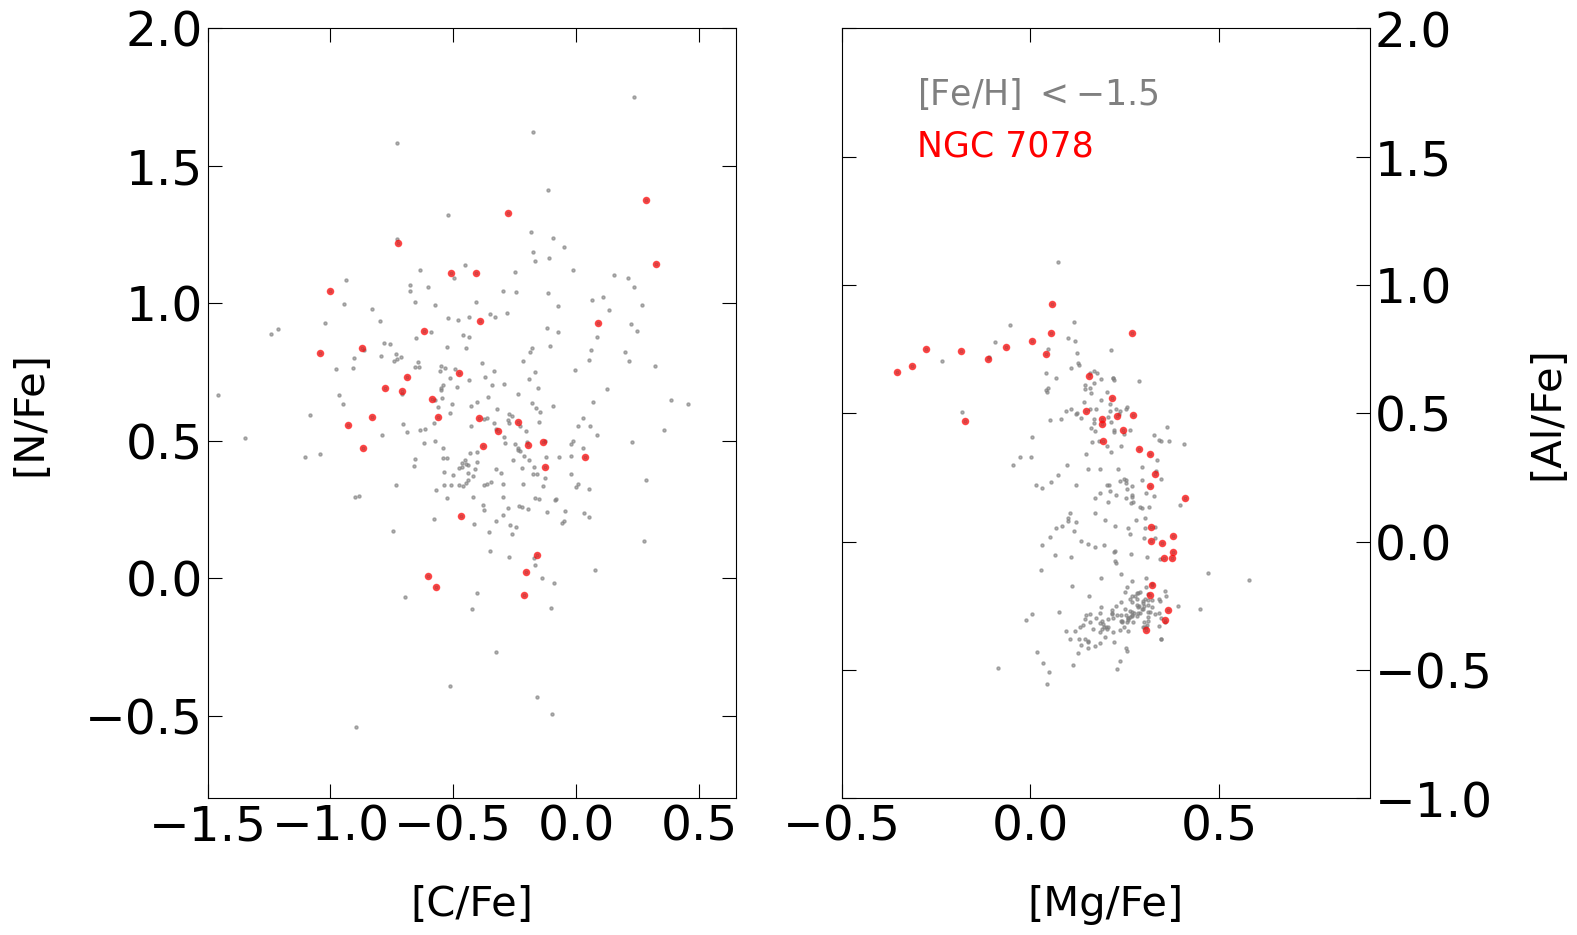

In [10]:

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 10
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35

mnm = (g_gc == 'NGC7078')
#mnm = (g_gc == 'NGC6656')


#femin = -1.5
#femax = -1.0
femin = -3.5
femax = -1.5

mgcs = ( (g_teff < 4750) & (g_sn > 70) & (g_fe < femax) & (g_fe > femin) & (g_gc!='NGC5139') & (g_gc!='NGC6715') \
       & (g_gc!='Ter5') & (g_gc!='Liller1') )

interest = (mgcs & (g_c > 0.0) ) 
print(g_gc[interest])


fig= plt.figure(figsize=(15,10),constrained_layout=True)

gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.2, hspace=0) # set the spacing between axes. 


plt.subplot(gs[0])
plt.scatter(g_ci[mgcs],g_n[mgcs],c='gray',alpha=0.6,s=5)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_ci[mgcs&mnm],g_n[mgcs&mnm],c='red',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True)

ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(g_mg[mgcs],g_al[mgcs],c='gray',alpha=0.6,s=5)
plt.scatter(g_mg[mgcs&mnm],g_al[mgcs&mnm],c='red',alpha=0.6,s=20)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.xlabel('[Mg/Fe]',size=labs,labelpad=25)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.9)
plt.ylim(-1.0,2.0)
#plt.text(-0.3,1.7,'$-1.5<$ [Fe/H] $<-$1.0',fontsize=25,c='Gray')
#plt.text(-0.3,1.5,'M 5',fontsize=25,c='Red')
plt.text(-0.3,1.7,'[Fe/H] $<-$1.5',fontsize=25,c='Gray')
plt.text(-0.3,1.5,'NGC 7078',fontsize=25,c='Red')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True,labelright=True,labelleft=False)


#plt.savefig('anticorr_M5.png',format='png',bbox_inches='tight')
#plt.savefig('anticorr_NGC7078.png',format='png',bbox_inches='tight')



print(len(g_gc))

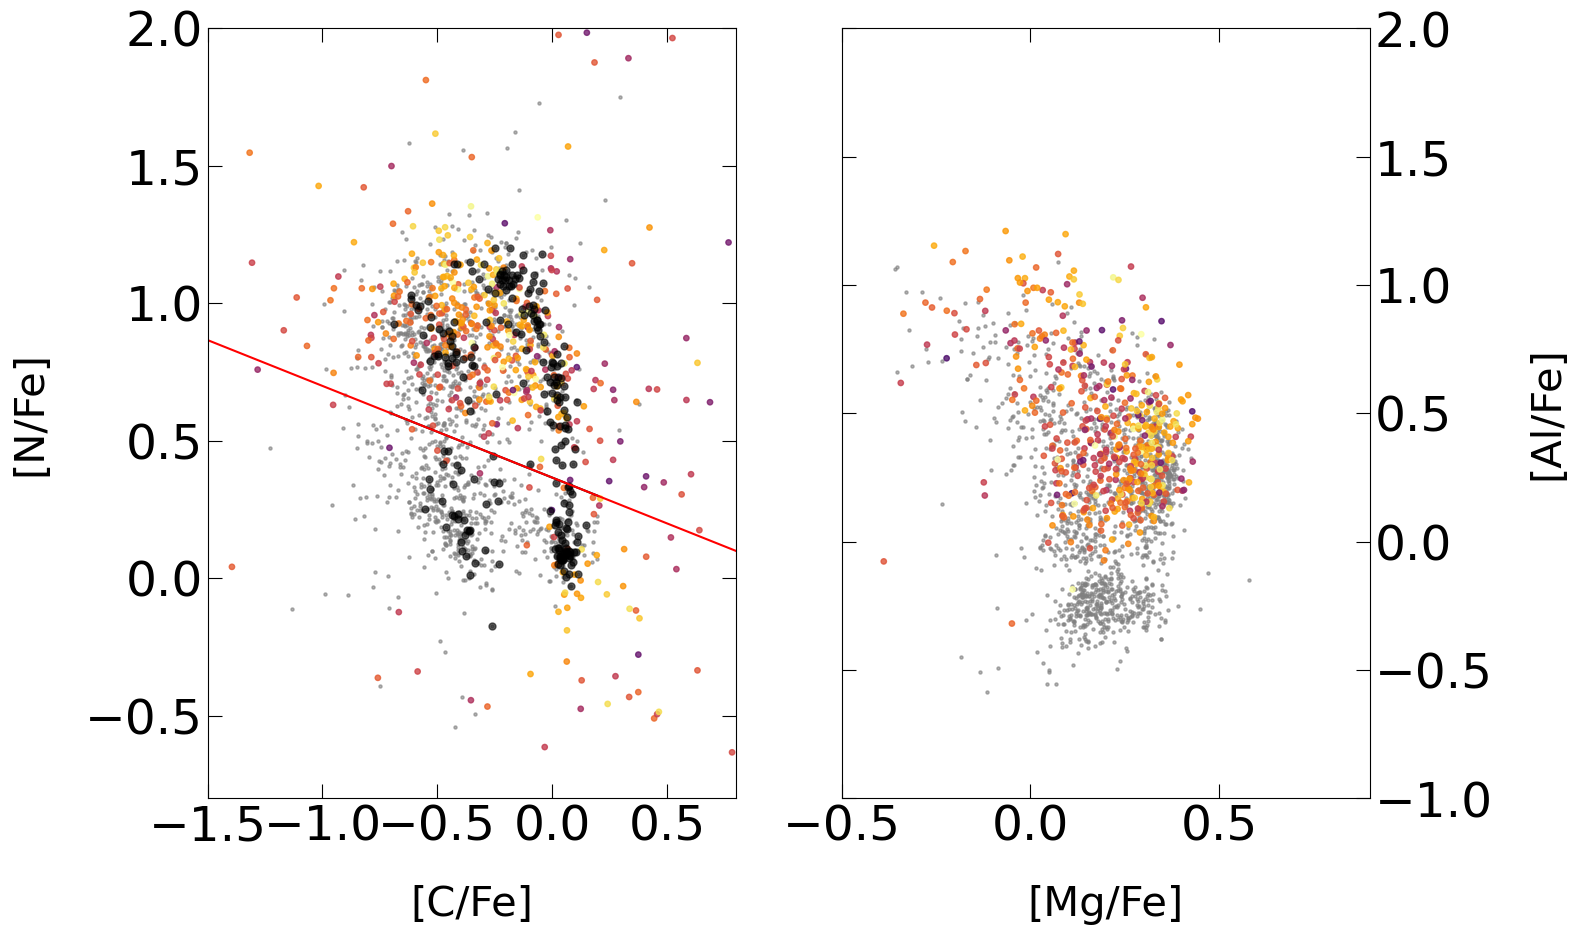

In [11]:

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35

fig= plt.figure(figsize=(15,10),constrained_layout=True)

gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.2, hspace=0) # set the spacing between axes. 

pmax=1.0
pmin=0.95

mgcs = ( (g_teff < 4750) & (g_sn > 70) & (g_fe < 1.4) & (g_gc!='NGC5139') & (g_gc!='NGC6715') \
       & (g_gc!='Ter5') & (g_gc!='Liller1') )

m47 = (g_gc=='NGC0104') 
m5 = (g_gc=='NGC5904')

mamask= ( (n_pred<pmax)&(n_pred>=pmin) )

plt.subplot(gs[0])
plt.scatter(g_c[mgcs],g_n[mgcs],c='gray',alpha=0.6,s=5)
plt.scatter(n_cfe[mamask],n_nfe[mamask],c=n_feh[mamask],cmap='inferno',alpha=0.8,s=15,vmin=-3,vmax=-0.5)
plt.scatter(g_c[mgcs&m47],g_n[mgcs&m47],c='black',alpha=0.6,s=25)
plt.scatter(g_c[mgcs&m5],g_n[mgcs&m5],c='black',alpha=0.6,s=25)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlim(-1.5,0.8)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True)

plt.plot([-0.7,0.2],[0.6,0.3],c='black')
x = np.arange(-1.5,1,0.01)
plt.plot(x,-(1/3.)*x+(1.1/3.), c='red')



ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.scatter(g_mg[mgcs],g_al[mgcs],c='gray',alpha=0.6,s=5)
plt.scatter(n_mgfe[mamask],n_alfe[mamask],c=n_feh[mamask],cmap='inferno',alpha=0.8,s=15,vmin=-3,vmax=-0.5)
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.xlabel('[Mg/Fe]',size=labs,labelpad=25)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.9)
plt.ylim(-1.0,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True,labelright=True,labelleft=False)



In [12]:
mawho = ( (g_c>0) & (g_c<0.1) & (g_n>0.0) & (g_n<0.2) )
print(g_gc[mawho&mgcs])

['NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104'
 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104'
 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104'
 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104'
 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104'
 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC0104' 'NGC6171' 'NGC6304'
 'NGC6316' 'NGC6316' 'NGC6380' 'NGC6380' 'NGC6388' 'NGC6388' 'NGC6388'
 'Pal6' 'NGC6441' 'NGC6441' 'NGC6441' 'NGC6441' 'UKS1' 'NGC6539' 'NGC6528'
 'NGC6553' 'NGC6553' 'NGC6553' 'Ter12' 'NGC6553' 'NGC6760' 'NGC6838'
 'NGC6838' 'NGC6838' 'NGC6838' 'NGC6838' 'NGC6838' 'NGC6838' 'NGC6838'
 'NGC6838' 'NGC6838' 'NGC6838' 'NGC6838' 'NGC6838' 'NGC6838' 'NGC6838'
 'NGC6838' 'NGC7089' 'NGC7089']


/var/folders/8d/f33468051dg800k3mh7xqksr0000gq/T/ipykernel_33967/4021249023.py:228: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('anticors_c1_cmol.png',format='png',dpi=300,bbox_inches='tight')


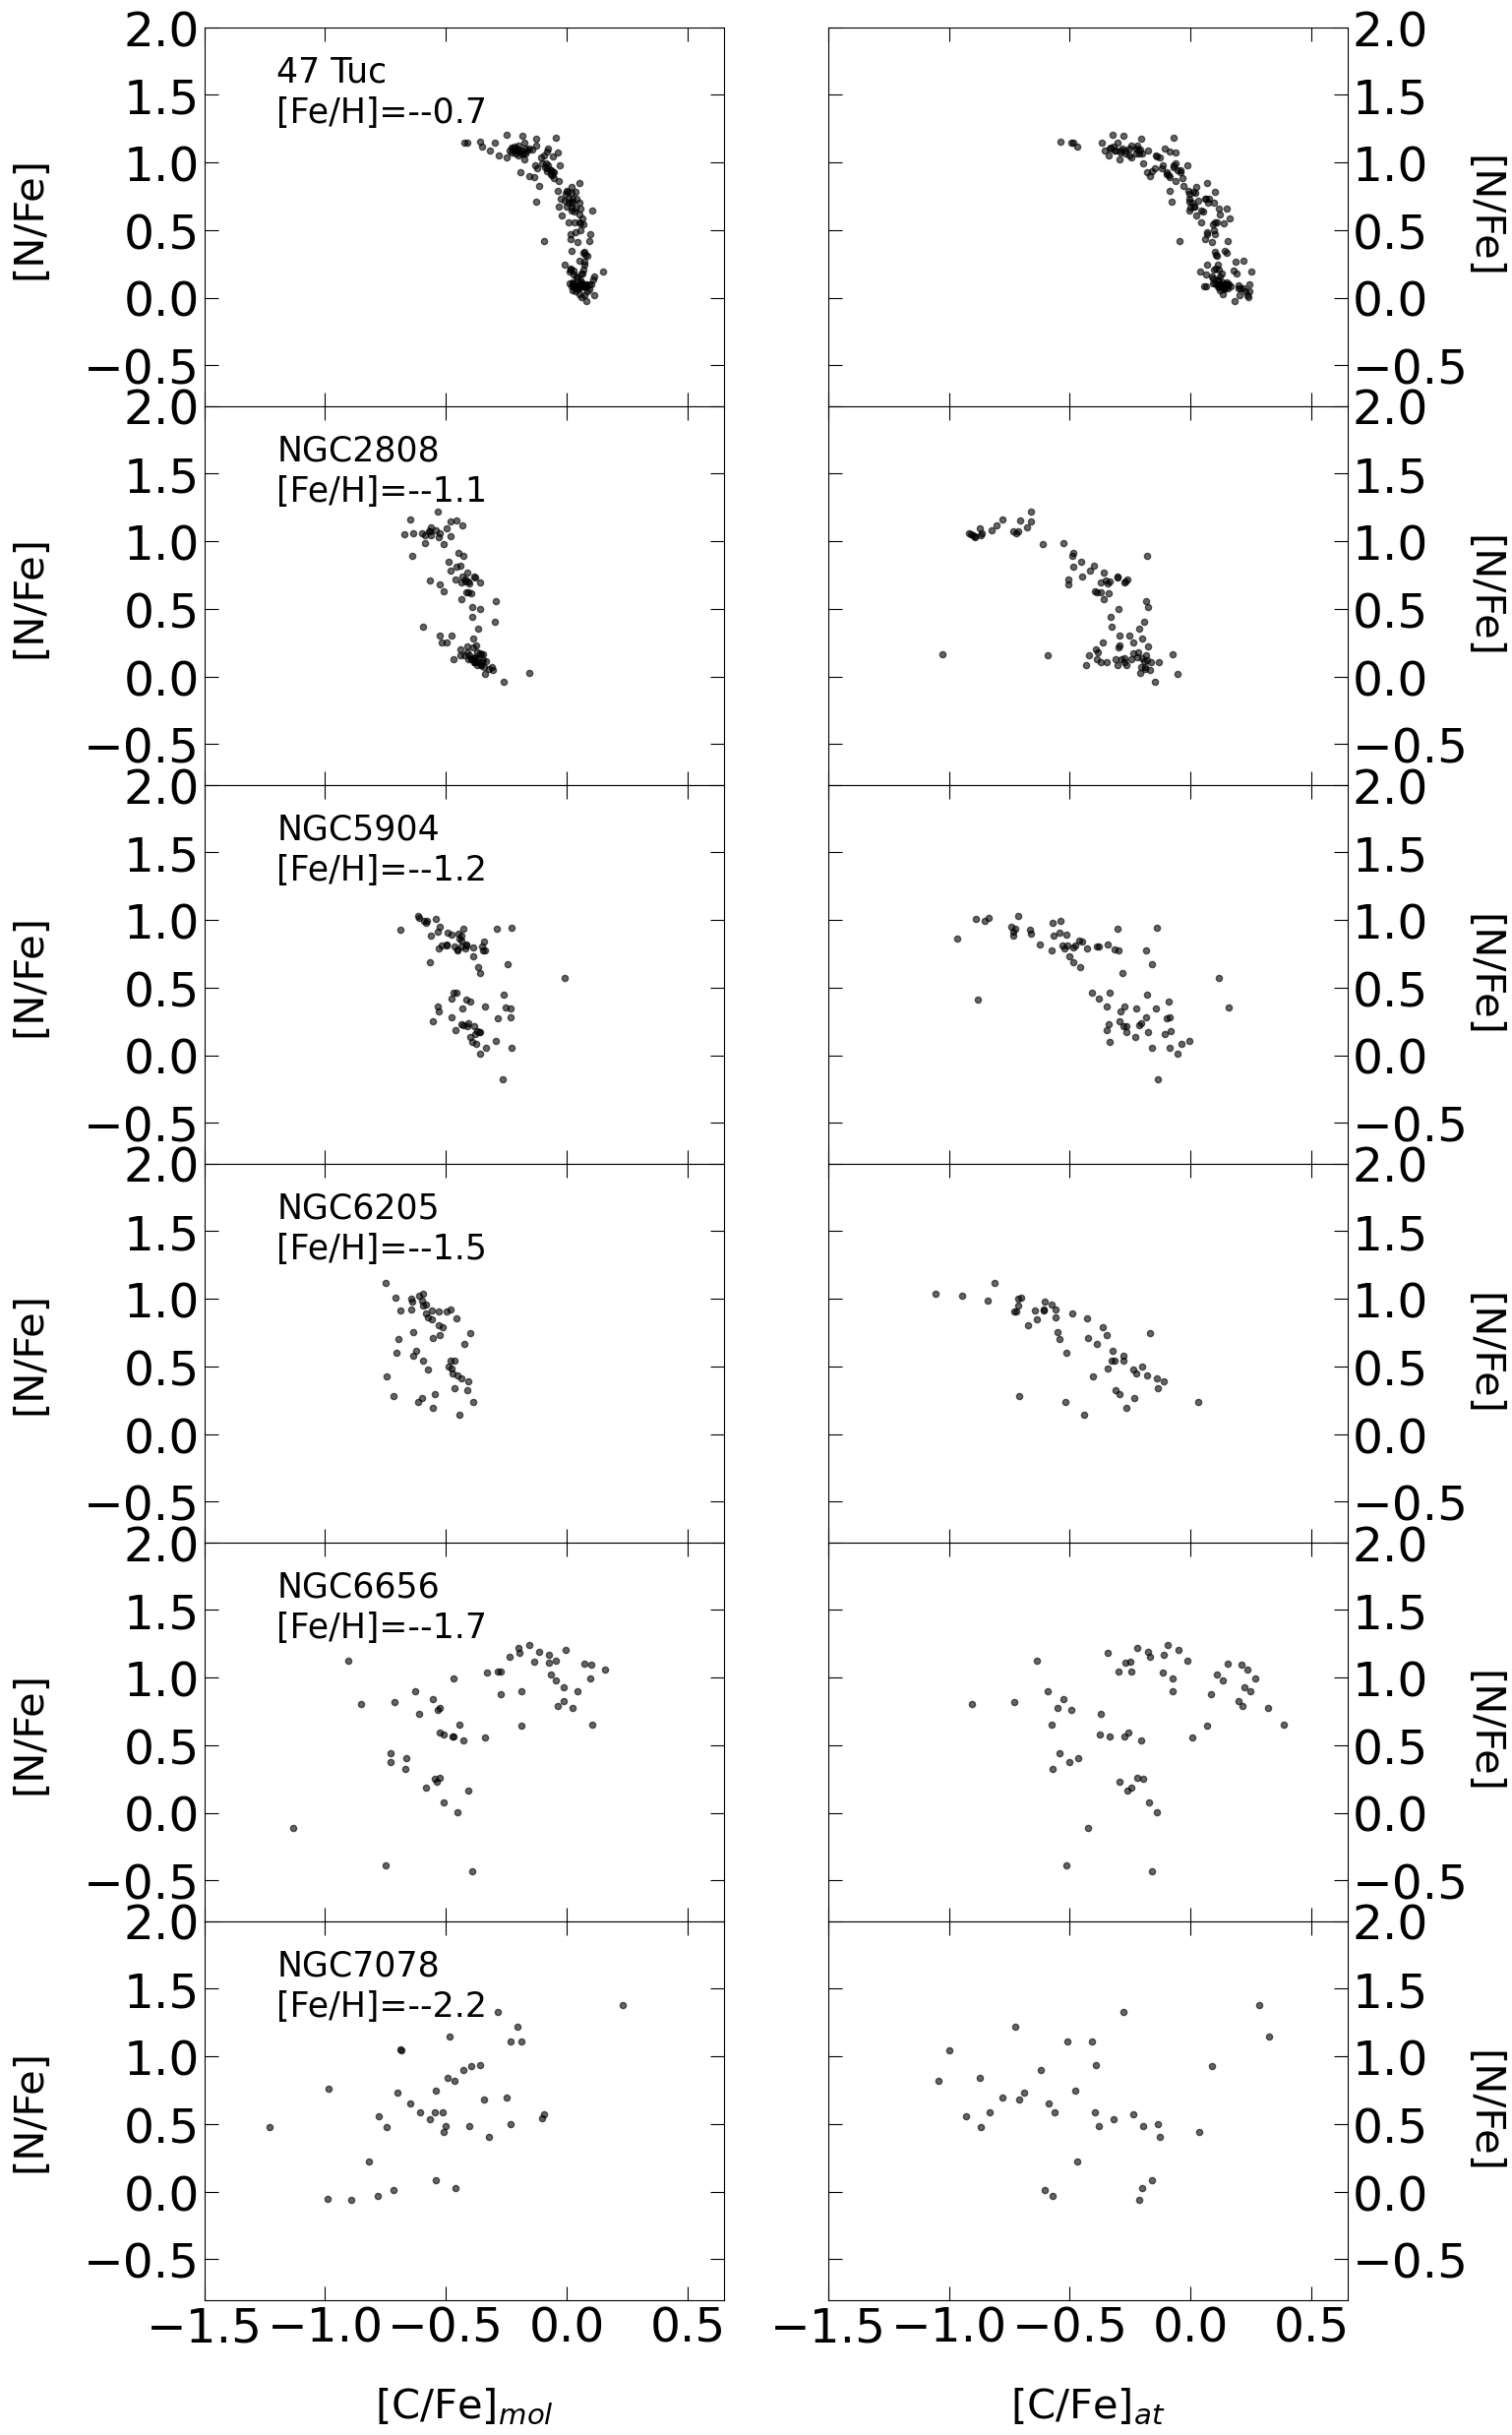

In [13]:
import matplotlib.gridspec as gridspec


# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35


mnm = (g_gc == 'NGC0104')

femin = -3.5
femax = 1.0
#femin = -3.5
#femax = -1.5

mgcs = ( (g_teff < 4750) & (g_sn > 70) & (g_fe < femax) & (g_fe > femin) & (g_gc!='NGC5139') & (g_gc!='NGC6715') \
       & (g_gc!='Ter5') & (g_gc!='Liller1') )


fig= plt.figure(figsize=(15,30),constrained_layout=True)

gs = gridspec.GridSpec(6,2)
gs.update(wspace=0.2, hspace=0) # set the spacing between axes. 


plt.subplot(gs[0])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_c[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
#plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-1.2,1.6,'47 Tuc',fontsize=25,c='black')
plt.text(-1.2,1.3,'[Fe/H]=--0.7',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)


ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_ci[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
#plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25,rotation=270)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)



mnm = (g_gc == 'NGC2808')


plt.subplot(gs[2])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_c[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
#plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-1.2,1.6,'NGC2808',fontsize=25,c='black')
plt.text(-1.2,1.3,'[Fe/H]=--1.1',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[3])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_ci[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
#plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25,rotation=270)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)


mnm = (g_gc == 'NGC5904')

plt.subplot(gs[4])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_c[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
#plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-1.2,1.6,'NGC5904',fontsize=25,c='black')
plt.text(-1.2,1.3,'[Fe/H]=--1.2',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[5])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_ci[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
#plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25,rotation=270)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)


mnm = (g_gc == 'NGC6205')

plt.subplot(gs[6])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_c[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
#plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-1.2,1.6,'NGC6205',fontsize=25,c='black')
plt.text(-1.2,1.3,'[Fe/H]=--1.5',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[7])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_ci[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
#plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25,rotation=270)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)



mnm = (g_gc == 'NGC6656')

plt.subplot(gs[8])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_c[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
#plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-1.2,1.6,'NGC6656',fontsize=25,c='black')
plt.text(-1.2,1.3,'[Fe/H]=--1.7',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[9])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_ci[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
#plt.xlabel('[C/Fe]',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25,rotation=270)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)



mnm = (g_gc == 'NGC7078')


plt.subplot(gs[10])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_c[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
plt.xlabel('[C/Fe]$_{mol}$',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-1.2,1.6,'NGC7078',fontsize=25,c='black')
plt.text(-1.2,1.3,'[Fe/H]=--2.2',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True)

ax = plt.subplot(gs[11])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_ci[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
#plt.scatter(g_c[mgcs&mnm&(g_al>-0.2)],g_n[mgcs&mnm&(g_al>-0.2)],c='blue',alpha=0.6,s=15)
plt.xlabel('[C/Fe]$_{at}$',size=labs,labelpad=25)
plt.ylabel('[N/Fe]',size=labs,labelpad=25,rotation=270)
#plt.xlim(-0.5,1.0)
plt.xlim(-1.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True,labelright=True,labelleft=False)


plt.savefig('anticors_c1_cmol.png',format='png',dpi=300,bbox_inches='tight')




/var/folders/8d/f33468051dg800k3mh7xqksr0000gq/T/ipykernel_33967/2741246531.py:194: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('anticors_c1_cmol.png',format='png',dpi=300,bbox_inches='tight')


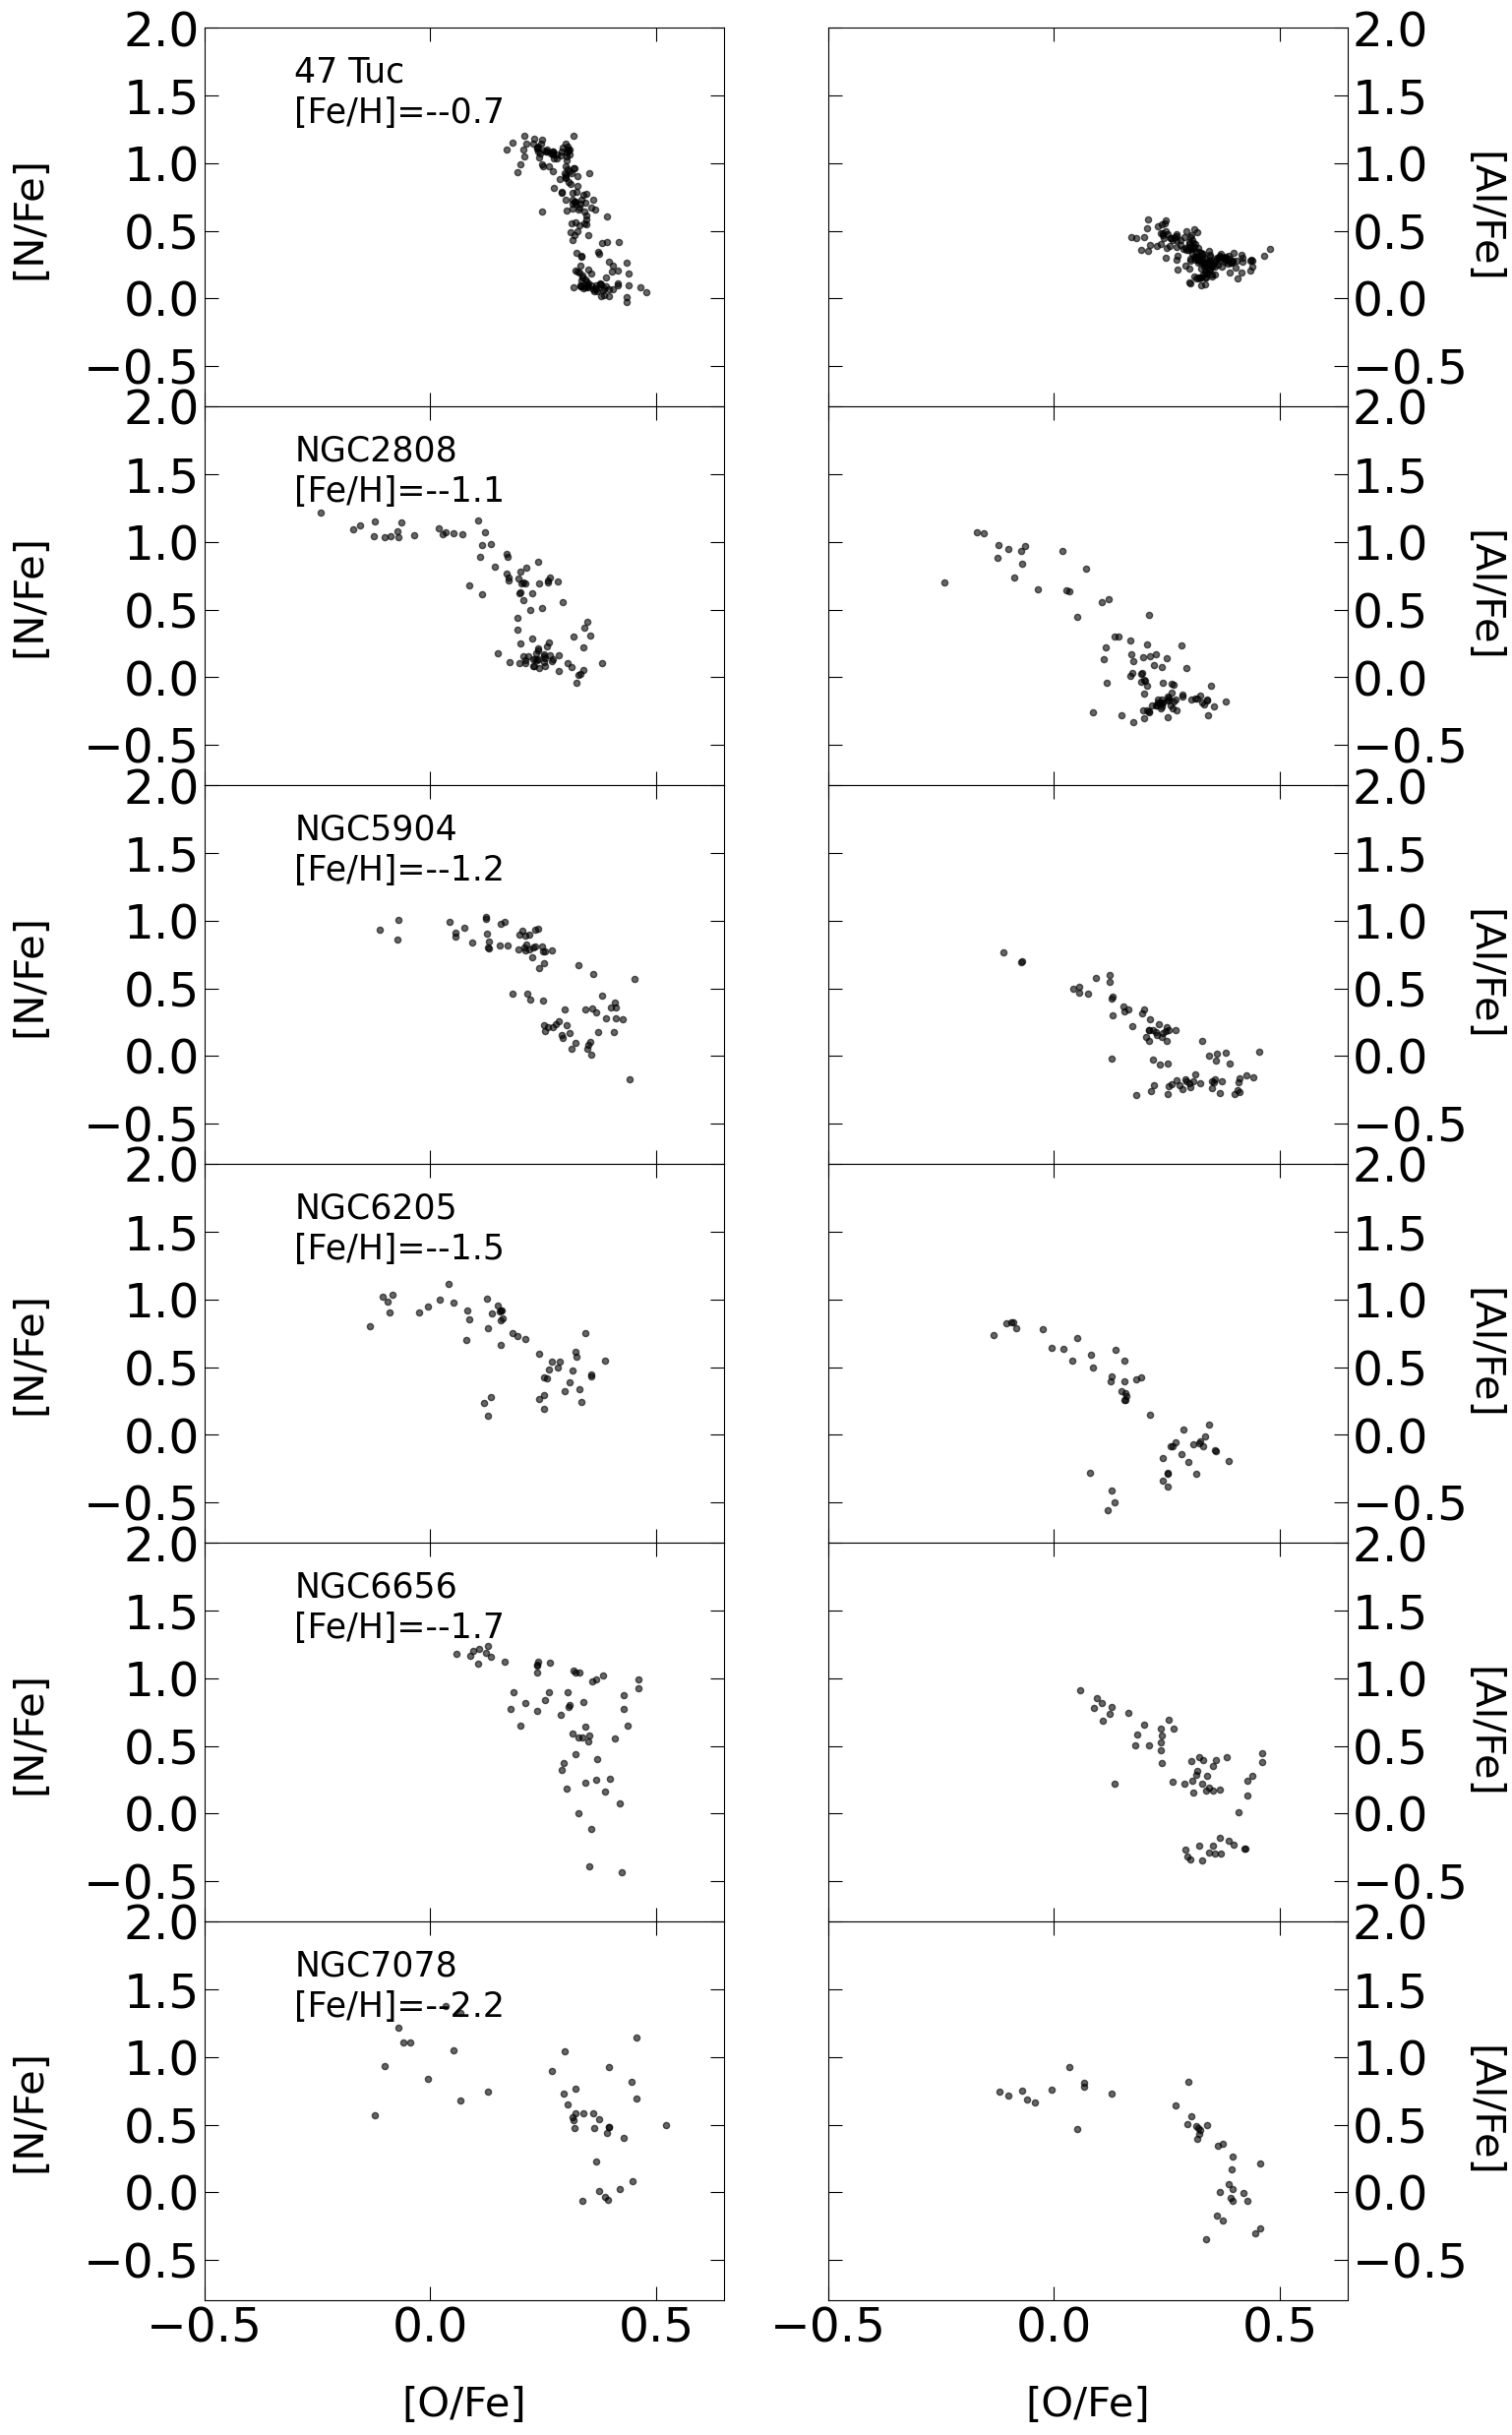

In [14]:
import matplotlib.gridspec as gridspec


# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35


mnm = (g_gc == 'NGC0104')

femin = -3.5
femax = 1.0
#femin = -3.5
#femax = -1.5

mgcs = ( (g_teff < 4750) & (g_sn > 70) & (g_fe < femax) & (g_fe > femin) & (g_gc!='NGC5139') & (g_gc!='NGC6715') \
       & (g_gc!='Ter5') & (g_gc!='Liller1') )


fig= plt.figure(figsize=(15,30),constrained_layout=True)

gs = gridspec.GridSpec(6,2)
gs.update(wspace=0.2, hspace=0) # set the spacing between axes. 


plt.subplot(gs[0])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-0.3,1.6,'47 Tuc',fontsize=25,c='black')
plt.text(-0.3,1.3,'[Fe/H]=--0.7',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)


ax = plt.subplot(gs[1])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_al[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25,rotation=270)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)



mnm = (g_gc == 'NGC2808')


plt.subplot(gs[2])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-0.3,1.6,'NGC2808',fontsize=25,c='black')
plt.text(-0.3,1.3,'[Fe/H]=--1.1',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[3])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_al[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25,rotation=270)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)


mnm = (g_gc == 'NGC5904')

plt.subplot(gs[4])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-0.3,1.6,'NGC5904',fontsize=25,c='black')
plt.text(-0.3,1.3,'[Fe/H]=--1.2',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[5])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_al[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25,rotation=270)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)


mnm = (g_gc == 'NGC6205')

plt.subplot(gs[6])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-0.3,1.6,'NGC6205',fontsize=25,c='black')
plt.text(-0.3,1.3,'[Fe/H]=--1.5',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[7])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_al[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25,rotation=270)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)



mnm = (g_gc == 'NGC6656')

plt.subplot(gs[8])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-0.3,1.6,'NGC6656',fontsize=25,c='black')
plt.text(-0.3,1.3,'[Fe/H]=--1.7',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

ax = plt.subplot(gs[9])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_al[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25,rotation=270)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=True,labelleft=False)



mnm = (g_gc == 'NGC7078')


plt.subplot(gs[10])
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_n[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[N/Fe]',size=labs,labelpad=25)
plt.xlabel('[O/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.text(-0.3,1.6,'NGC7078',fontsize=25,c='black')
plt.text(-0.3,1.3,'[Fe/H]=--2.2',fontsize=25,c='black')
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True)

ax = plt.subplot(gs[11])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position("both")
plt.xticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-4,4,step=0.5)),fontsize=tcks)
plt.scatter(g_o[mgcs&mnm],g_al[mgcs&mnm],c='k',alpha=0.6,s=20)
plt.ylabel('[Al/Fe]',size=labs,labelpad=25,rotation=270)
plt.xlabel('[O/Fe]',size=labs,labelpad=25)
plt.xlim(-0.5,0.65)
plt.ylim(-0.8,2.0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True,labelright=True,labelleft=False)


plt.savefig('anticors_c1_cmol.png',format='png',dpi=300,bbox_inches='tight')




(-1.0, 2.0)

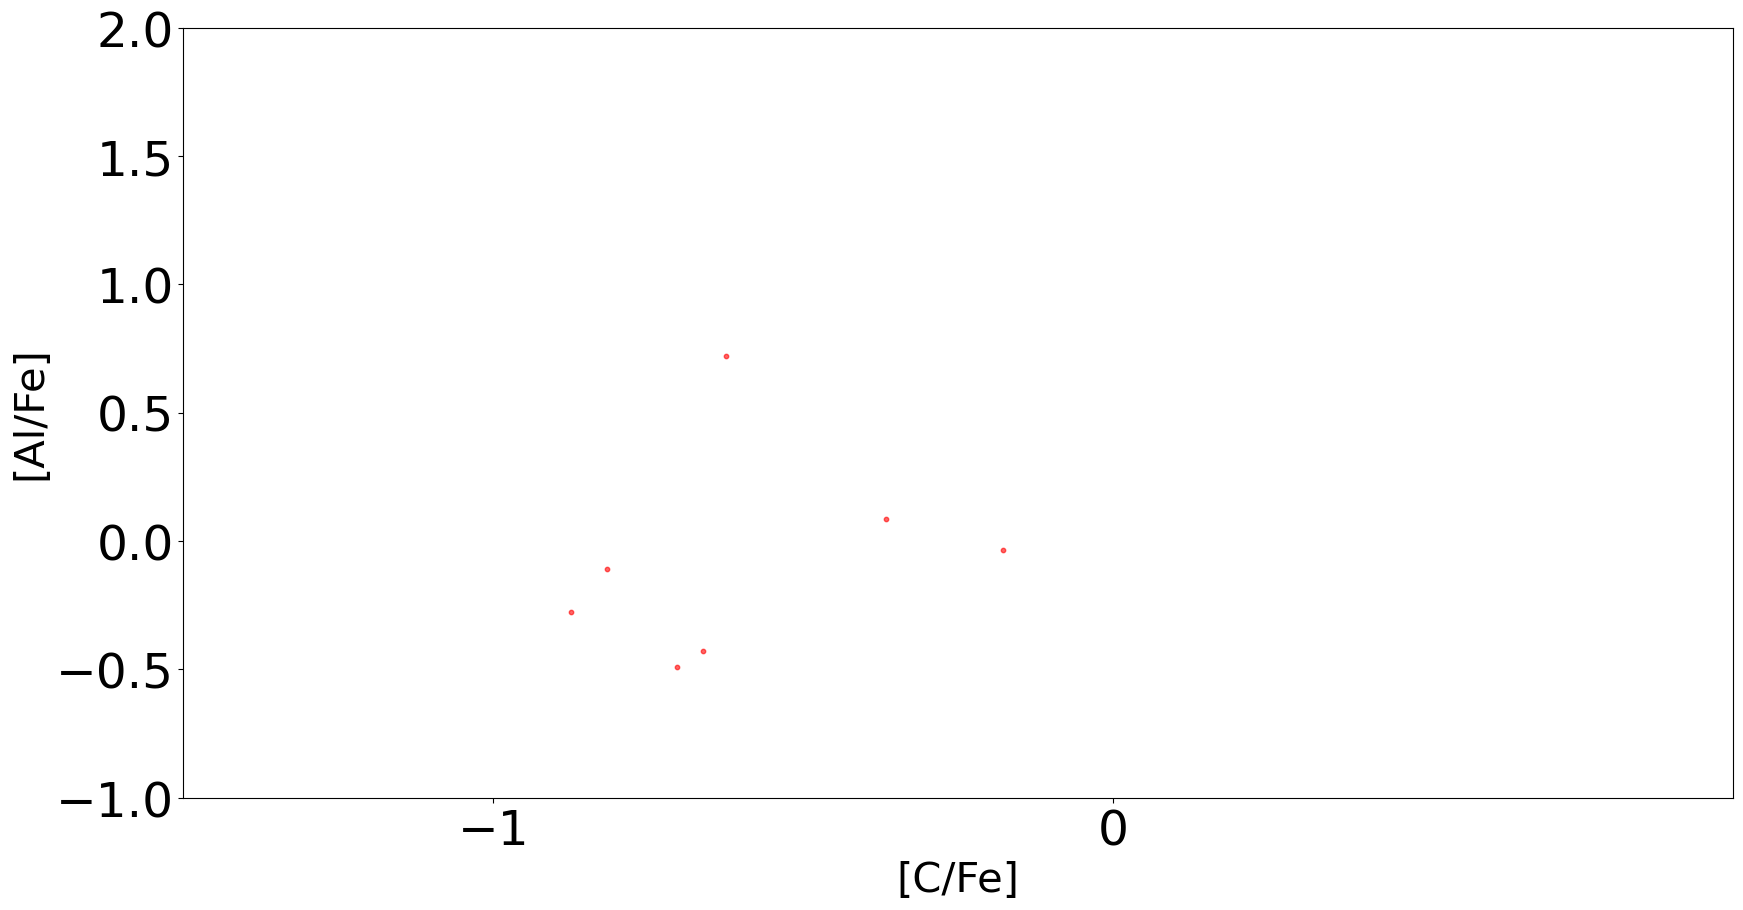

In [15]:
ma=0.5
mi=0.0

plt.scatter(g_c[mgcs&(g_fe<-1.6)&(g_logg>mi)&(g_logg<ma)],g_al[mgcs&(g_fe<-1.6)&(g_logg>mi)&(g_logg<ma)],c='red',alpha=0.6,s=10)
#plt.scatter(tn_fe,tn_c,c='blue',alpha=0.6,s=6)
plt.xlabel('[C/Fe]',size=labs)
plt.ylabel('[Al/Fe]',size=labs)
plt.xticks((np.arange(-4,1,step=1)),fontsize=tcks)
plt.yticks((np.arange(-1,2.5,step=0.5)),fontsize=tcks)
plt.xlim(-1.5,1)
plt.ylim(-1,2)



In [16]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10


#mask_mpoor = [feh_acc_nrich < -1]
#xn = nife_acc_nrich[mask_mpoor]
#xn = vfe_acc_nrich[mask_mpoor]
#yn = simn_acc_nrich[mask_mpoor]


#Figure settings (font sizes of ticks and labels)
labs=35
tcks=35

n_simn = n_sife - n_mnfe

plt.hist2d(nife_al, simn_al, norm=mpl.colors.LogNorm(), bins=(120, 50),range=[[-1.,1],[-0.6,1.3]], cmap='Greys')
plt.clim(1,5000)
plt.scatter(n_nife,n_simn,c='red',alpha=0.9,s=15,lw=0)
plt.xlabel('[Ni/Fe]',size=labs)
plt.ylabel('[Si/Mn]',size=labs)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.xticks((np.arange(-3.0,1.5,step=0.25)),fontsize=tcks)
plt.yticks((np.arange(-1.5,1.5,step=0.5)),fontsize=tcks)
plt.tick_params(which='minor',direction='in',right=True,top=True,length=2)
plt.xlim(-0.5,0.5)
plt.ylim(-0.6,1.3)
plt.text(-0.85,1,'Accreted',fontsize=35)
plt.text(0.23,-0.3,'$In\,situ$ low $\\alpha$',fontsize=35)
plt.text(0.23,1.0,'$In\,situ$ high $\\alpha$',fontsize=35)
#plt.scatter(nife[new_accmask], simn[new_accmask], c='red', alpha=0.8,s=5,lw=0)




plt.savefig('select_ins_bg.png',format='png',bbox_inches='tight')

plt.plot([-1,-0.1,0.27],[-0.05,-0.05,1.3], '--', c='black')
#plt.scatter(gni[mask_gc&(gsn>100)&(gfe<-1.0)],gsimn[mask_gc&(gsn>100)&(gfe<-1.0)],c='red', alpha=1.0,s=20,lw=0)
#plt.scatter(gni[(gfe<-1.0)&(gsn>100)],gmgmn[(gfe<-1.0)&(gsn>100)],c='red', alpha=1.0,s=20,lw=0)


#x = np.arange(-0.5,0.5,0.01)
#plt.plot(x,(1.35/0.37)*x+(0.135/0.37-0.05), 'k', c='black')


plt.plot([-0.03,0.5],[0.205,0.205], '--', c='black')



NameError: name 'nife_al' is not defined

(-3.0, 0.0)

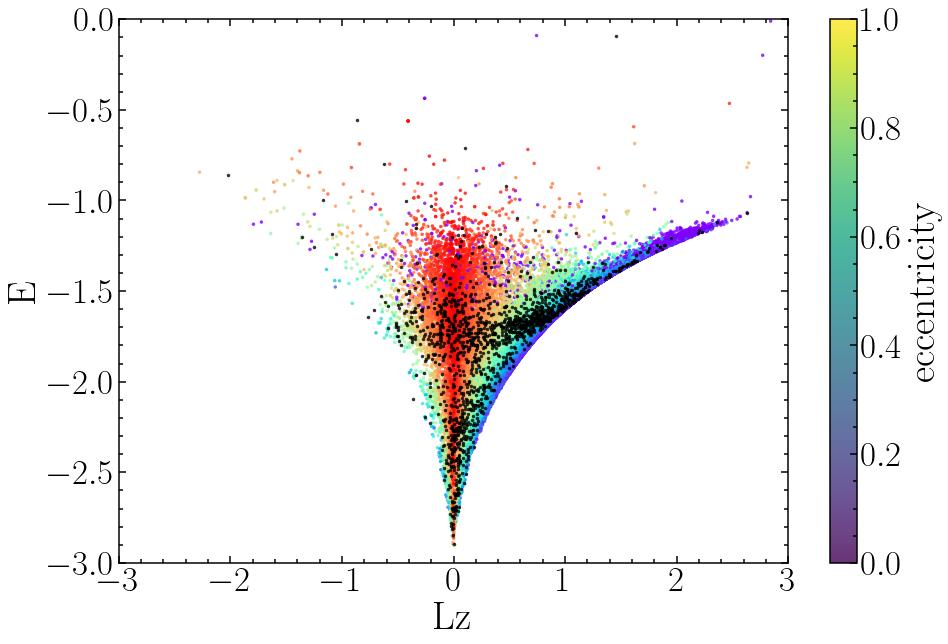

In [36]:

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

labs = 40
tcks = 35

plt.scatter(lz_al[dist_al<15.],ener_al[dist_al<15.],c=ecc_al[dist_al<15.], alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.xlabel('Lz',size=labs)
plt.ylabel('E',size=labs)
plt.scatter(n_lz[n_dist<15.],n_ener[n_dist<15.],c='black', alpha=0.8,s=12,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('eccentricity',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-3,3)
plt.ylim(-3,0)
#plt.text(-0.1,-0.4,'Low-$\\alpha$ Disk',fontsize=35)
#plt.text(-0.1,0.65,'High-$\\alpha$ Disk',fontsize=35)
#plt.arrow(0.2,-0.3,0,0.3,width=0.01,head_width=0.05,head_length=0.06,length_includes_head=True,color='red')



In [10]:
print(np.min(aal),np.max(aal))

nan nan


In [8]:
print(np.min(xxlz),np.max(xxlz))
print(np.min(xxener),np.max(xxener))


-1759998.24 10.960919200000001
-9.99999 0.05577961771


# Define populations chemically

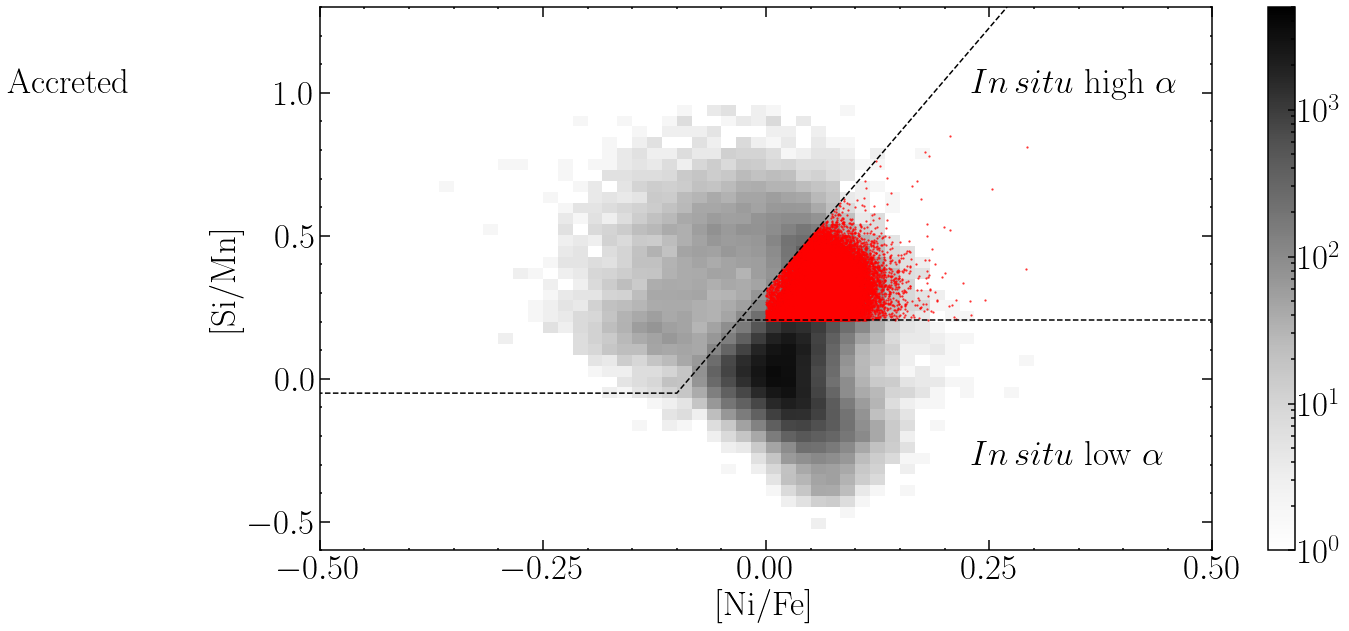

In [29]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10


#mask_mpoor = [feh_acc_nrich < -1]
#xn = nife_acc_nrich[mask_mpoor]
#xn = vfe_acc_nrich[mask_mpoor]
#yn = simn_acc_nrich[mask_mpoor]


#Figure settings (font sizes of ticks and labels)
labs=35
tcks=35

#plt.scatter(feh,alfe,c=cn, cmap='rainbow',alpha=0.4,s=30,lw=0,vmin=-0.7,vmax=0.7)
plt.hist2d(nife, simn, norm=mpl.colors.LogNorm(), bins=(120, 50),range=[[-1.,1],[-0.6,1.3]], cmap='Greys')
plt.clim(1,5000)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
#cb.set_label('Stars per bin',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Ni/Fe]',size=labs)
plt.ylabel('[Si/Mn]',size=labs)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.xticks((np.arange(-3.0,1.5,step=0.25)),fontsize=tcks)
plt.yticks((np.arange(-1.5,1.5,step=0.5)),fontsize=tcks)
plt.tick_params(which='minor',direction='in',right=True,top=True,length=2)
plt.xlim(-0.5,0.5)
plt.ylim(-0.6,1.3)
plt.text(-0.85,1,'Accreted',fontsize=35)
plt.text(0.23,-0.3,'$In\,situ$ low $\\alpha$',fontsize=35)
plt.text(0.23,1.0,'$In\,situ$ high $\\alpha$',fontsize=35)
#plt.scatter(nife[new_accmask], simn[new_accmask], c='red', alpha=0.8,s=5,lw=0)



new_insmask = ( (nife > 0.0) & (simn < (1.35/0.37)*nife+(0.135/0.37-0.05)) & (simn > 0.205) & (cfe > -0.2) )
plt.scatter(nife[new_insmask], simn[new_insmask], c='red', alpha=0.8,s=5,lw=0)

plt.savefig('select_ins_bg.png',format='png',bbox_inches='tight')

plt.plot([-1,-0.1,0.27],[-0.05,-0.05,1.3], '--', c='black')
#plt.scatter(gni[mask_gc&(gsn>100)&(gfe<-1.0)],gsimn[mask_gc&(gsn>100)&(gfe<-1.0)],c='red', alpha=1.0,s=20,lw=0)
#plt.scatter(gni[(gfe<-1.0)&(gsn>100)],gmgmn[(gfe<-1.0)&(gsn>100)],c='red', alpha=1.0,s=20,lw=0)


#x = np.arange(-0.5,0.5,0.01)
#plt.plot(x,(1.35/0.37)*x+(0.135/0.37-0.05), 'k', c='black')


plt.plot([-0.03,0.5],[0.205,0.205], '--', c='black')


#Calculate [(C+N)/Fe]
cnfe = np.log10(10**(cfe+feh+8.39) + 10**(nfe+feh+7.78)) - np.log10(10.**8.39 + 10.**7.78) - feh


In [30]:
(1.35/0.37)*(-0.03)+(0.135/0.37-0.05)

0.20540540540540547

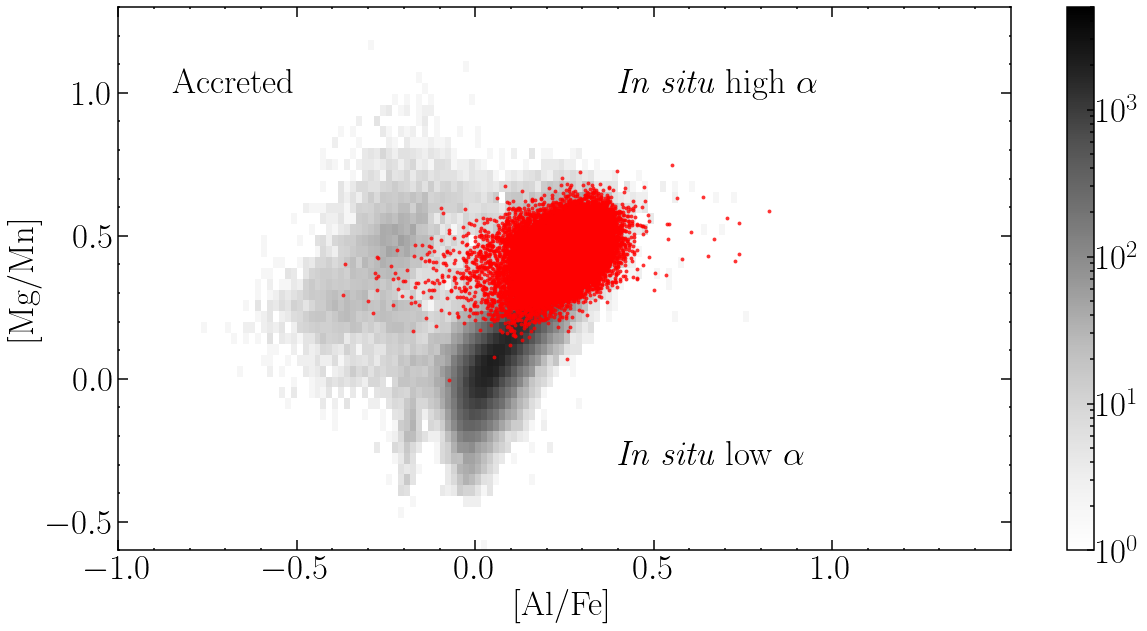

In [31]:
#plt.scatter(feh,alfe,c=cn, cmap='rainbow',alpha=0.4,s=30,lw=0,vmin=-0.7,vmax=0.7)
plt.hist2d(alfe, mgmn, norm=mpl.colors.LogNorm(), bins=(120, 50),range=[[-1.,1],[-0.6,1.3]], cmap='Greys')
plt.clim(1,5000)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
#cb.set_label('Stars per bin',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Al/Fe]',size=labs)
plt.ylabel('[Mg/Mn]',size=labs)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.xticks((np.arange(-3.0,1.5,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-1.5,1.5,step=0.5)),fontsize=tcks)
plt.tick_params(which='minor',direction='in',right=True,top=True,length=2)
plt.xlim(-1.0,1.5)
plt.ylim(-0.6,1.3)
plt.text(-0.85,1,'Accreted',fontsize=35)
plt.text(0.4,-0.3,'{\it In situ} low $\\alpha$',fontsize=35)
plt.text(0.4,1.0,'{\it In situ} high $\\alpha$',fontsize=35)
plt.scatter(alfe[new_insmask], mgmn[new_insmask], c='red', alpha=0.8,s=15,lw=0)



In [32]:
1.1/0.4
1.0 - 0.05*2.75
2.75*-0.5 + 1.2

-0.17500000000000004

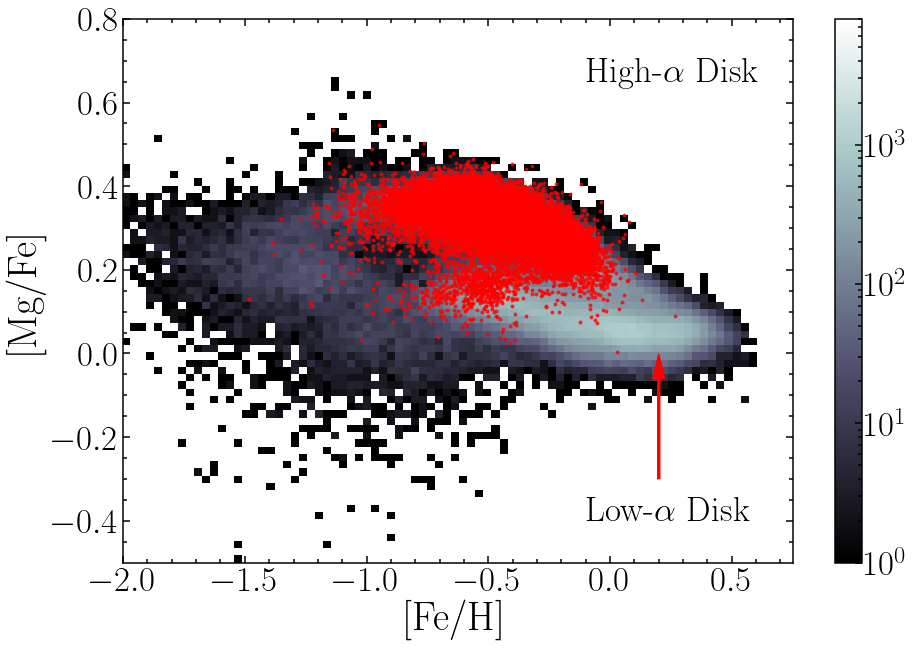

In [33]:
#DISPLAY SAMPLE IN A-FE PLANE.  CHOOSE SI FOR ALPHA ELEMENT

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

labs = 40
tcks = 35


plt.hist2d(feh,mgfe,norm=mpl.colors.LogNorm(), bins=(100, 75),range=[[-2.5,0.8],[-0.5,.8]], cmap='bone')
#Figure settings (labels, log scale, limits, legend position)   
plt.clim(1,8000)
cb= plt.colorbar()
#cb.set_label('Number',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[Mg/Fe]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.0,0.75)
plt.ylim(-0.5,0.8)
plt.text(-0.1,-0.4,'Low-$\\alpha$ Disk',fontsize=35)
plt.text(-0.1,0.65,'High-$\\alpha$ Disk',fontsize=35)
plt.arrow(0.2,-0.3,0,0.3,width=0.01,head_width=0.05,head_length=0.06,length_includes_head=True,color='red')

mgfe_ins = mgfe[new_insmask]
feh_ins = feh[new_insmask]
plt.scatter(feh_ins,mgfe_ins,c='red',alpha=0.8,s=15,lw=0) 

#mgfe_what = mgfe[mask_what]
#feh_what = feh[mask_what]
#plt.scatter(feh_what,mgfe_what,c='blue',alpha=0.8,s=30,lw=0) 

#print(len(feh_hiad),len(feh_load),len(feh_acc))
plt.savefig('mgfe_disks.png',format='png',bbox_inches='tight')


plt.show()



In [34]:
print(np.min(alfe),np.max(alfe))

-0.9350389 1.502361


In [36]:
ids_ins = ids[new_insmask]
#Save high-alpha star IDs to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
col1 = fits.Column(name='APOGEE ID', array=ids_acc, format='30A')
#col2 = fits.Column(name='RA', array=ra_hia_mp_nrich, format='F')
#col3 = fits.Column(name='DEC', array=dec_hia_mp_nrich, format='F')
cols = fits.ColDefs([col1])
hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('accreted_IDs.fits')


# Remove C-rich stars. 

/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


29951
0.05104891553671023


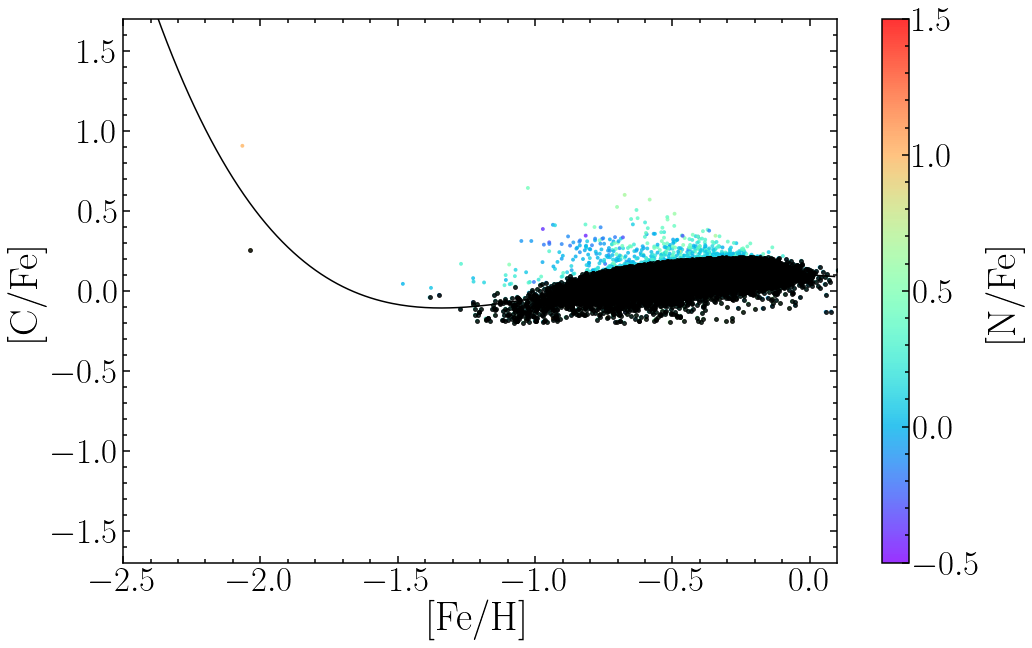

In [37]:
#NOW, RATHER THAN ADOPTING A BLANK [C/FE]<+0.15 CUT, WE FIT THE C/FE VS FE/H RELATION AND KEEP
#ONLY STARS THAT DO NOT DEPART FROM IT BY MORE THAN 4 SIGMA.  MAY WANT TO CHANGE THAT THRESHOLD
#GET MORE N-RICH STARS THAT WAY -- 25 March 2021

fig_size[0] = 16
fig_size[1] = 10

ids_ins = ids[new_insmask]
nfe_ins = nfe[new_insmask]
ofe_ins = ofe[new_insmask]
cfe_ins = cfe[new_insmask]
feh_ins = feh[new_insmask]
mgfe_ins = mgfe[new_insmask]
alfe_ins = alfe[new_insmask]
mnfe_ins = mnfe[new_insmask]
sife_ins = sife[new_insmask]
nife_ins = nife[new_insmask]
nvis_ins = nvis[new_insmask]
vscat_ins = vscat[new_insmask]
jmag_ins = jmag[new_insmask]
hmag_ins = hmag[new_insmask]
kmag_ins = kmag[new_insmask]
teff_ins = teff[new_insmask]
logg_ins = logg[new_insmask]
teff_e_ins = teff_e[new_insmask]
logg_e_ins = logg_e[new_insmask]
a_k_ins = a_k[new_insmask]
a_j_ins = a_j[new_insmask]
dist_ins = dist[new_insmask]
dist_err_ins = dist_err[new_insmask]
lz_ins = lz[new_insmask]
ener_ins = ener[new_insmask]
ecc_ins = ecc[new_insmask]

vr_ins = vr[new_insmask]
vz_ins = vz[new_insmask]
vphi_ins = vphi[new_insmask]
phi_rad_ins = phi_rad[new_insmask]




plt.scatter(feh_ins,cfe_ins,c=nfe_ins, alpha=0.8,s=15,cmap='rainbow',lw=0,vmin=-0.5,vmax=1.5)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('[N/Fe]',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[C/Fe]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.5,0.1)
plt.ylim(-1.7,1.7)


########  Polynomial fit to the relation between Fe/H and C/Fe
import numpy.polynomial.polynomial as poly
coefs_c = np.polynomial.polynomial.polyfit(feh_ins,cfe_ins,4)
ffnit_c = poly.Polynomial(coefs_c)

#fet = np.linspace(feh_l[0], feh_l[-1], num=len(feh_l)*10)
fet = np.arange(-3.0,0.1,0.01)
plt.plot(fet,ffnit_c(fet),'k',c='black')

#print(fet,ffit(fet))

sclip_c=2.0  #size of sigma clipping (only one iteration)
estim_c = ffnit_c(feh_ins)
res_c = cfe_ins - estim_c
resq_c = res_c**2.
numtot = len(feh_ins)
print(numtot)
var_c = np.sum(resq_c)/(numtot-1)
sigma_c = math.sqrt(var_c)
print(sigma_c)

#REMOVE C-RICH STARS
mask_ins_crich = res_c < (sclip_c*sigma_c) 


#idr_ins_nrich = ids_ins[mask_ins_nrich]
#teff_ins_nrich = teff_ins[mask_ins_nrich]
#logg_ins_nrich = logg_ins[mask_ins_nrich]

ids_ins = ids_ins[mask_ins_crich]
nfe_ins = nfe_ins[mask_ins_crich]
ofe_ins = ofe_ins[mask_ins_crich]
cfe_ins = cfe_ins[mask_ins_crich]
feh_ins = feh_ins[mask_ins_crich]
mgfe_ins = mgfe_ins[mask_ins_crich]
alfe_ins = alfe_ins[mask_ins_crich]
mnfe_ins = mnfe_ins[mask_ins_crich]
sife_ins = sife_ins[mask_ins_crich]
nife_ins = nife_ins[mask_ins_crich]
nvis_ins = nvis_ins[mask_ins_crich]
vscat_ins = vscat_ins[mask_ins_crich]
jmag_ins = jmag_ins[mask_ins_crich]
hmag_ins = hmag_ins[mask_ins_crich]
kmag_ins = kmag_ins[mask_ins_crich]
teff_ins = teff_ins[mask_ins_crich]
logg_ins = logg_ins[mask_ins_crich]
teff_e_ins = teff_e_ins[mask_ins_crich]
logg_e_ins = logg_e_ins[mask_ins_crich]
a_k_ins = a_k_ins[mask_ins_crich]
a_j_ins = a_j_ins[mask_ins_crich]
dist_ins = dist_ins[mask_ins_crich]
dist_err_ins = dist_err_ins[mask_ins_crich]
lz_ins = lz_ins[mask_ins_crich]
ener_ins = ener_ins[mask_ins_crich]
ecc_ins = ecc_ins[mask_ins_crich]

simn_ins = sife_ins - mnfe_ins
mgmn_ins = mgfe_ins - mnfe_ins

vr_ins = vr_ins[mask_ins_crich]
vz_ins = vz_ins[mask_ins_crich]
vphi_ins = vphi_ins[mask_ins_crich]
phi_rad_ins = phi_rad_ins[mask_ins_crich]


plt.scatter(feh_ins,cfe_ins, alpha=0.8,s=15,c='black')


#lzr_halo = lz_halo[mask_ins_nrich]
#energyr_halo = energy_halo[mask_ins_nrich]
#eccr_halo = ecc_halo[mask_ins_nrich]
#jtotr_halo = jtot_halo[mask_ins_nrich]
#jzr_halo = jz_halo[mask_ins_nrich]
#jrr_halo = jr_halo[mask_ins_nrich]

#np.savetxt('Halo_Nrich_ids.txt',idr_halo,fmt='%s')


#plt.scatter(feh_ins_crich,cfe_ins_crich, alpha=0.8,s=15,c='black')
#print(len(feh_ins_crich))

#Save N-rich star IDs to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
#col1 = fits.Column(name='APOGEE ID', array=idr_ins, format='30A')
#cols = fits.ColDefs([col1])
#hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('Lowalpha_Nrich_IDs_21oct2019.fits')

plt.savefig('Hialpha_Nrich.png',format='png',bbox_inches='tight')

#plt.scatter(feh_ins_bin,cfe_ins_bin, alpha=0.8,s=15,c='blue')



# Find N-rich stars

/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


29429
0.07343227737294418
106


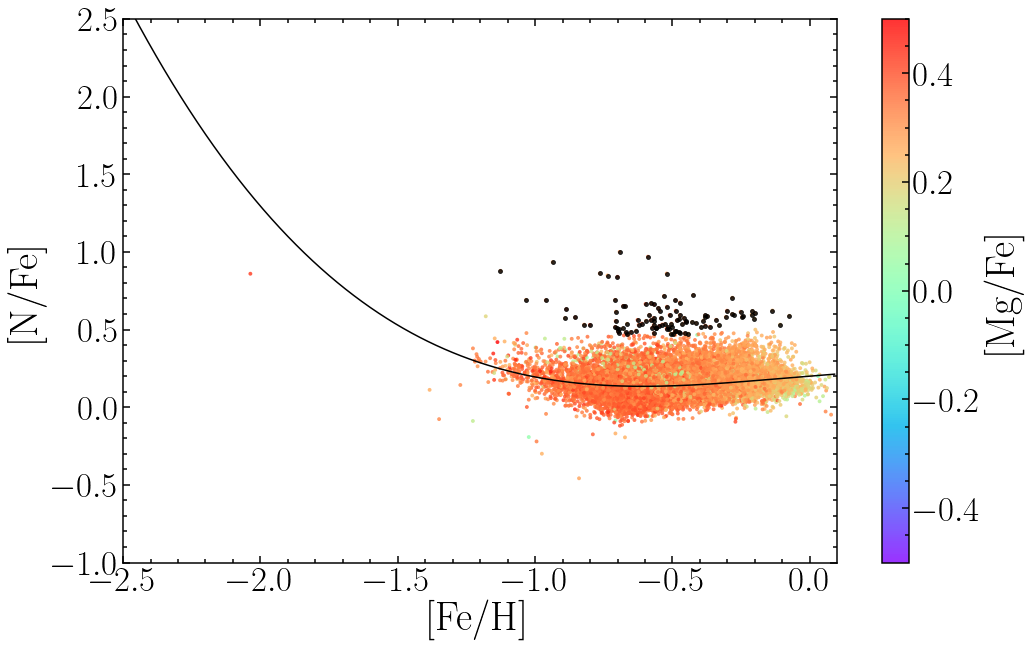

In [42]:
#Identify High-alpha metal-rich halo N-rich stars

fig_size[0] = 16
fig_size[1] = 10

#SELECT HALO STARS

plt.scatter(feh_ins,nfe_ins,c=mgfe_ins, alpha=0.8,s=15,cmap='rainbow',lw=0,vmin=-0.5,vmax=0.5)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('[Mg/Fe]',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[N/Fe]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.5,0.1)
plt.ylim(-1,2.5)


########  Polynomial fit to the relation between Fe/H and C/Fe
import numpy.polynomial.polynomial as poly
coefs = np.polynomial.polynomial.polyfit(feh_ins,nfe_ins,3)
ffnit = poly.Polynomial(coefs)

#fet = np.linspace(feh_l[0], feh_l[-1], num=len(feh_l)*10)
fet = np.arange(-3.0,0.1,0.01)
plt.plot(fet,ffnit(fet),'k',c='black')

#print(fet,ffit(fet))

sclip=4.5  #size of sigma clipping (only one iteration)
estim = ffnit(feh_ins)
res = nfe_ins - estim
resq = res**2.
numtot = len(feh_ins)
print(numtot)
var = np.sum(resq)/(numtot-1)
sigma = math.sqrt(var)
print(sigma)

#mask_ins_nrich = ( (res > (sclip*sigma)) & (alfe_dwh > -0.1) ) 
mask_ins_nrich = (  (res > (sclip*sigma)) )   #& (res_c < (sclip_c*sigma_c)) )


#idr_ins_nrich = ids_ins[mask_ins_nrich]
#teff_ins_nrich = teff_ins[mask_ins_nrich]
#logg_ins_nrich = logg_ins[mask_ins_nrich]

ids_ins_nrich = ids_ins[mask_ins_nrich]
nfe_ins_nrich = nfe_ins[mask_ins_nrich]
teff_ins_nrich = teff_ins[mask_ins_nrich]
logg_ins_nrich = logg_ins[mask_ins_nrich]
#teff_e_ins_nrich = teff_e_ins[mask_ins_nrich]
#logg_e_ins_nrich = logg_e_ins[mask_ins_nrich]
ofe_ins_nrich = ofe_ins[mask_ins_nrich]
cfe_ins_nrich = cfe_ins[mask_ins_nrich]
feh_ins_nrich = feh_ins[mask_ins_nrich]
mgfe_ins_nrich = mgfe_ins[mask_ins_nrich]
alfe_ins_nrich = alfe_ins[mask_ins_nrich]
sife_ins_nrich = sife_ins[mask_ins_nrich]
nife_ins_nrich = nife_ins[mask_ins_nrich]
mnfe_ins_nrich = mnfe_ins[mask_ins_nrich]
nvis_ins_nrich = nvis_ins[mask_ins_nrich]
vscat_ins_nrich = vscat_ins[mask_ins_nrich]

jmag_ins_nrich = jmag_ins[mask_ins_nrich]
hmag_ins_nrich = hmag_ins[mask_ins_nrich]
kmag_ins_nrich = kmag_ins[mask_ins_nrich]

a_k_ins_nrich = a_k_ins[mask_ins_nrich]
a_j_ins_nrich = a_j_ins[mask_ins_nrich]

dist_ins_nrich = dist_ins[mask_ins_nrich]
dist_err_ins_nrich = dist_err_ins[mask_ins_nrich]

lz_ins_nrich = lz_ins[mask_ins_nrich]
ener_ins_nrich = ener_ins[mask_ins_nrich]
ecc_ins_nrich = ecc_ins[mask_ins_nrich]

vr_ins_nrich = vr_ins[mask_ins_nrich]
vz_ins_nrich = vz_ins[mask_ins_nrich]
vphi_ins_nrich = vphi_ins[mask_ins_nrich]
phi_ins_nrich = phi_rad_ins[mask_ins_nrich]





#lzr_halo = lz_halo[mask_ins_nrich]
#energyr_halo = energy_halo[mask_ins_nrich]
#eccr_halo = ecc_halo[mask_ins_nrich]
#jtotr_halo = jtot_halo[mask_ins_nrich]
#jzr_halo = jz_halo[mask_ins_nrich]
#jrr_halo = jr_halo[mask_ins_nrich]

#np.savetxt('Halo_Nrich_ids.txt',idr_halo,fmt='%s')


plt.scatter(feh_ins_nrich,nfe_ins_nrich, alpha=0.8,s=15,c='black')
print(len(feh_ins_nrich))

#Save N-rich star IDs to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
#col1 = fits.Column(name='APOGEE ID', array=idr_ins, format='30A')
#cols = fits.ColDefs([col1])
#hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('Lowalpha_Nrich_IDs_21oct2019.fits')

plt.savefig('Accreted_Nrich.png',format='png',bbox_inches='tight')

#plt.scatter(feh_ins_bin,nfe_ins_bin, alpha=0.8,s=15,c='blue')



# Find Al-rich stars

/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


29429
0.73805094 -0.36559898 29429 0.004399587784964574 0.06632938854659053
15


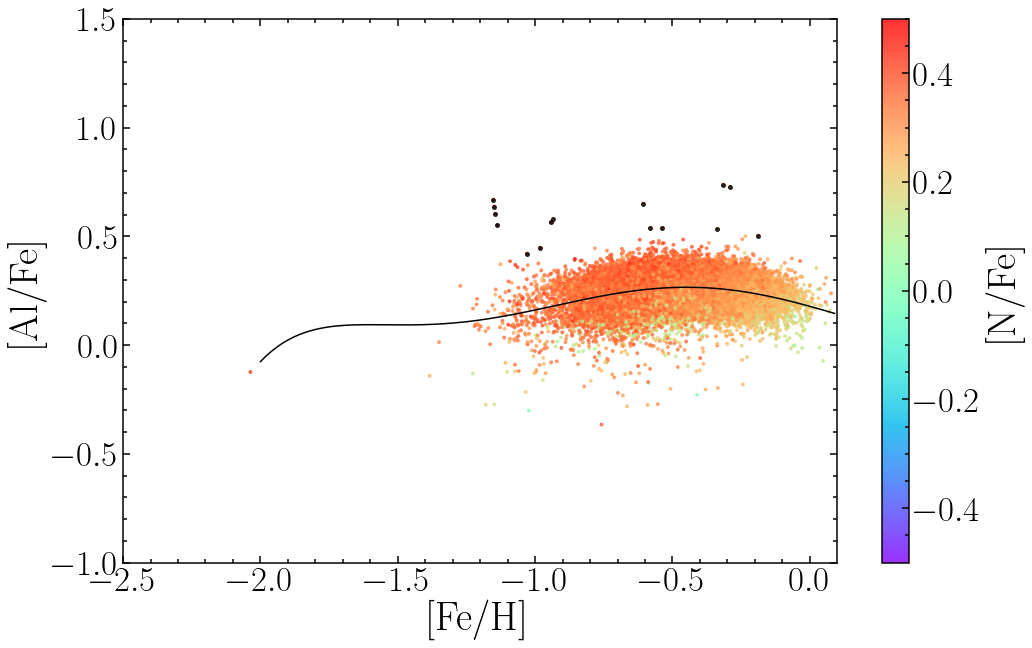

In [46]:
#Identify High-alpha metal-rich halo N-rich stars

fig_size[0] = 16
fig_size[1] = 10


plt.scatter(feh_ins,alfe_ins,c=mgfe_ins, alpha=0.8,s=15,cmap='rainbow',lw=0,vmin=-0.5,vmax=0.5)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('[N/Fe]',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[Al/Fe]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.5,0.1)
plt.ylim(-1,1.5)


########  Polynomial fit to the relation between Fe/H and C/Fe
import numpy.polynomial.polynomial as poly
coefs = np.polynomial.polynomial.polyfit(feh_ins,alfe_ins,6)
ffnit = poly.Polynomial(coefs)

#fet = np.linspace(feh_l[0], feh_l[-1], num=len(feh_l)*10)
fet = np.arange(-2.0,0.1,0.01)
plt.plot(fet,ffnit(fet),'k',c='black')

#print(fet,ffit(fet))

sclip=4.0  #size of sigma clipping (only one iteration)
estim = ffnit(feh_ins)
res = alfe_ins - estim
resq = res**2.
numtot = len(feh_ins)
print(numtot)
var = np.sum(resq)/(numtot-1)
sigma = math.sqrt(var)
print(np.max(alfe_ins),np.min(alfe_ins),numtot,var,sigma)

#mask_ins_nrich = ( (res > (sclip*sigma)) & (alfe_dwh > -0.1) ) 
mask_ins_alrich = (  (res > (sclip*sigma)) )   #& (res_c < (sclip_c*sigma_c)) )


ids_ins_alrich = ids_ins[mask_ins_alrich]
nfe_ins_alrich = nfe_ins[mask_ins_alrich]
teff_ins_alrich = teff_ins[mask_ins_alrich]
logg_ins_alrich = logg_ins[mask_ins_alrich]
#teff_e_ins_alrich = teff_e_ins[mask_ins_alrich]
#logg_e_ins_alrich = logg_e_ins[mask_ins_alrich]
ofe_ins_alrich = ofe_ins[mask_ins_alrich]
cfe_ins_alrich = cfe_ins[mask_ins_alrich]
feh_ins_alrich = feh_ins[mask_ins_alrich]
mgfe_ins_alrich = mgfe_ins[mask_ins_alrich]
alfe_ins_alrich = alfe_ins[mask_ins_alrich]
sife_ins_alrich = sife_ins[mask_ins_alrich]
nife_ins_alrich = nife_ins[mask_ins_alrich]
mnfe_ins_alrich = mnfe_ins[mask_ins_alrich]
nvis_ins_alrich = nvis_ins[mask_ins_alrich]
vscat_ins_alrich = vscat_ins[mask_ins_alrich]

jmag_ins_alrich = jmag_ins[mask_ins_alrich]
hmag_ins_alrich = hmag_ins[mask_ins_alrich]
kmag_ins_alrich = kmag_ins[mask_ins_alrich]

a_k_ins_alrich = a_k_ins[mask_ins_alrich]
a_j_ins_alrich = a_j_ins[mask_ins_alrich]

dist_ins_alrich = dist_ins[mask_ins_alrich]
dist_err_ins_alrich = dist_err_ins[mask_ins_alrich]

lz_ins_alrich = lz_ins[mask_ins_alrich]
ener_ins_alrich = ener_ins[mask_ins_alrich]
ecc_ins_alrich = ecc_ins[mask_ins_alrich]




plt.scatter(feh_ins_alrich,alfe_ins_alrich, alpha=0.8,s=15,c='black')
print(len(feh_ins_alrich))

#Save N-rich star IDs to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
#col1 = fits.Column(name='APOGEE ID', array=idr_ins, format='30A')
#cols = fits.ColDefs([col1])
#hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('Lowalpha_Nrich_IDs_21oct2019.fits')

plt.savefig('Accreted_Alrich.png',format='png',bbox_inches='tight')

#plt.scatter(feh_ins_bin,nfe_ins_bin, alpha=0.8,s=15,c='blue')



# Create a list of stars that are either N- or Al- rich

In [49]:
mask_nrich = np.isin(ids_ins,ids_ins_nrich)
mask_alrich = np.isin(ids_ins,ids_ins_alrich)

mask_ins_2g = (mask_nrich | mask_alrich)

In [50]:
print(len(ids_ins[mask_ins_2g]))

123


# Identify binary candidates

In [52]:
mask_bin = ( (vscat_ins > 1.0) & (nvis_ins > 2) )
mask_tot = nvis_ins > 2

nbin_2g = len(kmag_ins[mask_bin & mask_ins_2g])
ntot_2g = len(kmag_ins[mask_tot & mask_ins_2g])
frac_2g = nbin_2g/ntot_2g
print(nbin_2g,ntot_2g,frac_2g)

nbin_ins = len(kmag_ins[mask_bin])
ntot_ins = len(kmag_ins[mask_tot])
frac_ins = nbin_ins/ntot_ins
print(nbin_ins,ntot_ins,frac_ins)

fraction = ntot_2g/ntot_ins
print(fraction)

4 62 0.06451612903225806
1010 16944 0.0596081208687441
0.003659112370160529


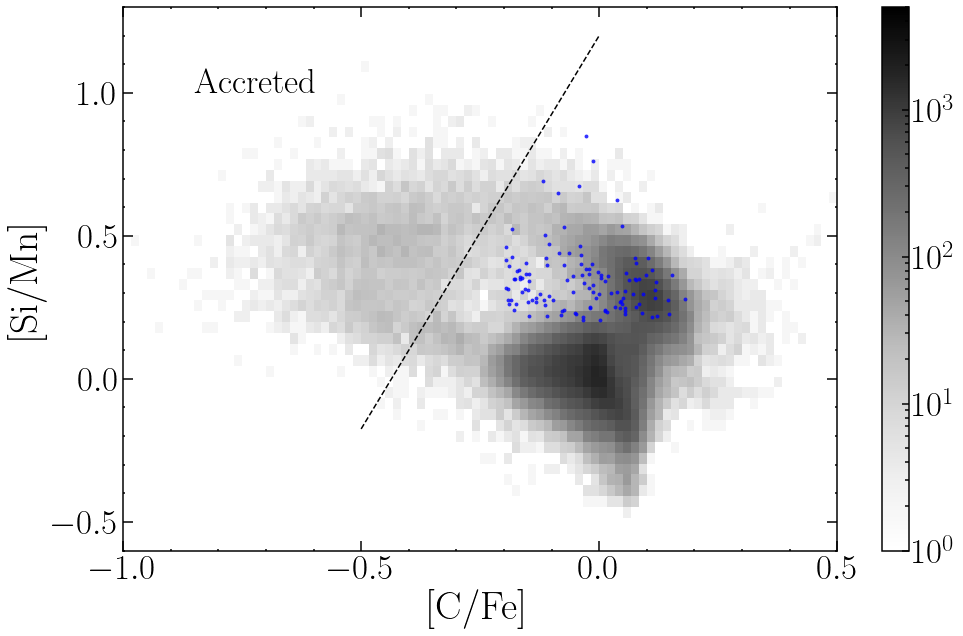

In [53]:
#plt.scatter(feh,alfe,c=cn, cmap='rainbow',alpha=0.4,s=30,lw=0,vmin=-0.7,vmax=0.7)
plt.hist2d(cfe, simn, norm=mpl.colors.LogNorm(), bins=(120, 50),range=[[-1.,1],[-0.6,1.3]], cmap='Greys')
plt.clim(1,5000)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
#cb.set_label('Stars per bin',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[C/Fe]',size=labs)
plt.ylabel('[Si/Mn]',size=labs)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.xticks((np.arange(-3.0,1.5,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-1.5,1.5,step=0.5)),fontsize=tcks)
plt.tick_params(which='minor',direction='in',right=True,top=True,length=2)
plt.xlim(-1.0,0.5)
plt.ylim(-0.6,1.3)
plt.text(-0.85,1,'Accreted',fontsize=35)
#plt.text(0.4,-0.3,'{\it In situ} low $\\alpha$',fontsize=35)
#plt.text(0.4,1.0,'{\it In situ} high $\\alpha$',fontsize=35)
#plt.scatter(cfe_acc3, simn_acc3, c='black', alpha=0.8,s=15,lw=0)
#plt.scatter(cfe_what, simn_what, c='orange', alpha=0.8,s=15,lw=0)
#plt.scatter(cfe_acc, simn_acc, c='red', alpha=0.8,s=15,lw=0)
#plt.scatter(cfe_acc2, simn_acc2, c='blue', alpha=0.8,s=15,lw=0)
#plt.scatter(cfe[acc_maskb], simn[acc_maskb], c='blue', alpha=0.8,s=15,lw=0)
#plt.scatter(cfe[acc_mask], simn[acc_mask], c='blue', alpha=0.8,s=15,lw=0)

plt.plot([-0.5,0.0],[-0.175,1.2], '--', c='black')
#The above line implies this relation:  y = 2.75*x + 1.2

plt.scatter(cfe_ins[mask_ins_2g], simn_ins[mask_ins_2g], c='blue', alpha=0.8,s=15,lw=0)



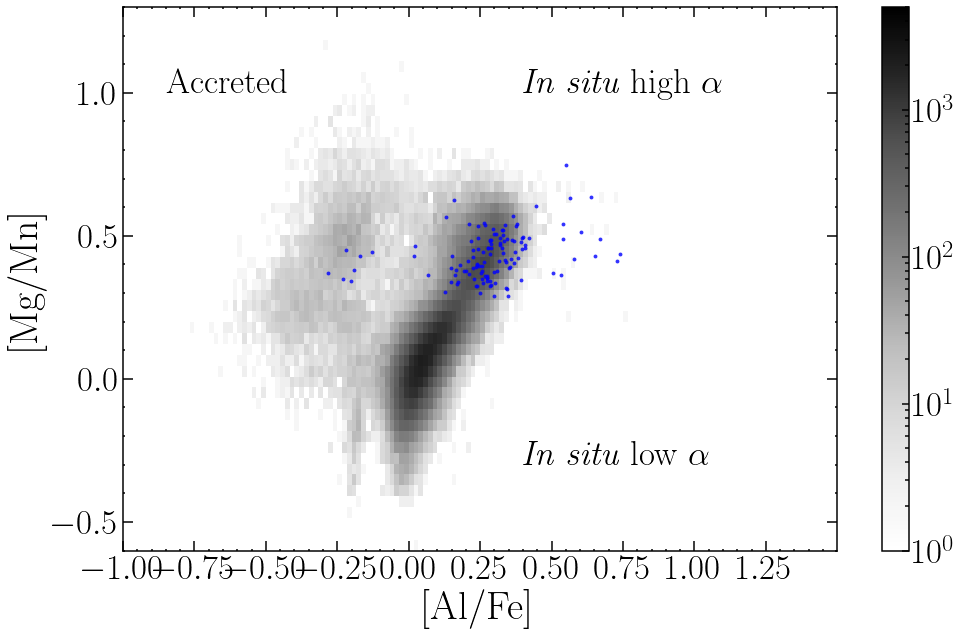

In [54]:
#plt.scatter(feh,alfe,c=cn, cmap='rainbow',alpha=0.4,s=30,lw=0,vmin=-0.7,vmax=0.7)
plt.hist2d(alfe, mgmn, norm=mpl.colors.LogNorm(), bins=(120, 50),range=[[-1.,1],[-0.6,1.3]], cmap='Greys')
plt.clim(1,5000)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
#cb.set_label('Stars per bin',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Al/Fe]',size=labs)
plt.ylabel('[Mg/Mn]',size=labs)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.xticks((np.arange(-3.0,1.5,step=0.25)),fontsize=tcks)
plt.yticks((np.arange(-1.5,1.5,step=0.5)),fontsize=tcks)
plt.tick_params(which='minor',direction='in',right=True,top=True,length=2)
plt.xlim(-1.0,1.5)
plt.ylim(-0.6,1.3)
plt.text(-0.85,1,'Accreted',fontsize=35)
plt.text(0.4,-0.3,'{\it In situ} low $\\alpha$',fontsize=35)
plt.text(0.4,1.0,'{\it In situ} high $\\alpha$',fontsize=35)
plt.scatter(alfe_ins[mask_ins_2g], mgmn_ins[mask_ins_2g], c='blue', alpha=0.8,s=15,lw=0)



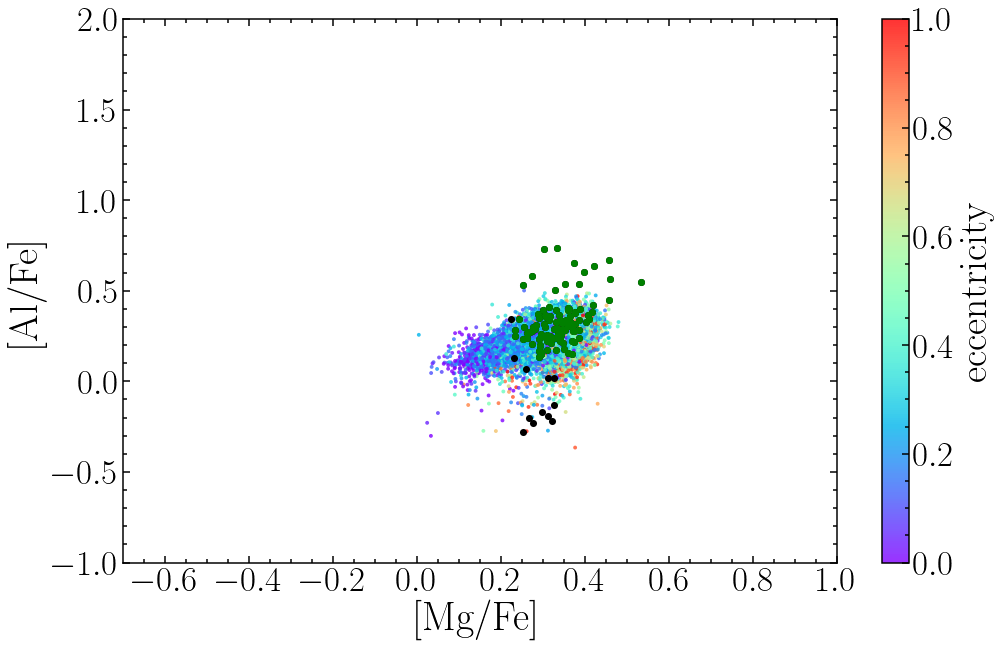

In [55]:
#plt.hist2d(cfe_acc,nfe_acc,norm=mpl.colors.LogNorm(), bins=(100, 75),range=[[-1,0.5],[-0.5,1.5]], cmap='bone')
plt.scatter(mgfe_ins,alfe_ins,c=ecc_ins, alpha=0.8,s=15,cmap='rainbow',lw=0,vmin=0,vmax=1)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('eccentricity',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.scatter(mgfe_ins[mask_ins_2g],alfe_ins[mask_ins_2g],c='black', alpha=1,s=50,lw=0)
#plt.scatter(mgfe_stream,alfe_stream,c='orange', alpha=0.8,s=60,lw=0)
#plt.scatter(gc_mgfe,gc_alfe,c='orange', alpha=0.8,s=30,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
#plt.yscale('log')
plt.xlabel('[Mg/Fe]',size=labs)
plt.ylabel('[Al/Fe]',size=labs)
#plt.xticks((np.arange(-1,1.6,step=0.2)),fontsize=tcks)
#plt.yticks((np.arange(-1.5,2.5,step=0.5)),fontsize=tcks)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-0.7,1)
plt.ylim(-1,2)

#plt.plot([-0.3,0.25,0.25],[-0.1,-0.1,1.0], 'k', c='black')
#plt.scatter(mgfe_acc_mp_bin,alfe_acc_mp_bin, alpha=0.8,s=15,c='blue')

plt.savefig('AlFe_Nrich.png',format='png',bbox_inches='tight')

#Save N-rich star IDs and coordinates to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
#col1 = fits.Column(name='APOGEE ID', array=ids_acc_mp_nrich, format='30A')
#col2 = fits.Column(name='RA', array=ra_acc_mp_nrich, format='F')
#col3 = fits.Column(name='DEC', array=dec_acc_mp_nrich, format='F')
#cols = fits.ColDefs([col1,col2,col3])
#hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('Nrich_IDs_coords.fits')

#plt.scatter(mgfe_acc_nrich[mask_mr],alfe_acc_nrich[mask_mr],c='magenta', alpha=1,s=50,lw=0)

mask_other = ( (mgfe_ins > 0.23) & (alfe_ins > 0.1) )
plt.scatter(mgfe_ins[mask_ins_2g&mask_other],alfe_ins[mask_ins_2g&mask_other],c='green', alpha=1,s=50,lw=0)



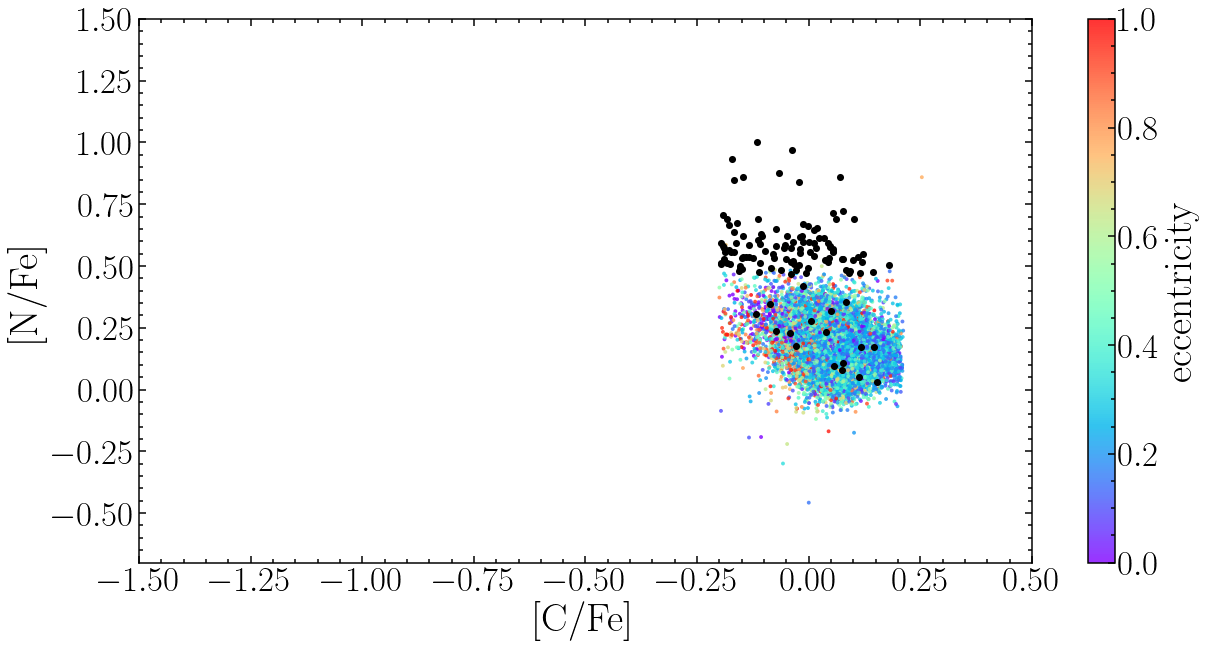

In [56]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#plt.hist2d(cfe_acc,nfe_acc,norm=mpl.colors.LogNorm(), bins=(100, 75),range=[[-1,0.5],[-0.5,1.5]], cmap='bone')
plt.scatter(cfe_ins,nfe_ins,c=ecc_ins, alpha=0.8,s=15,cmap='rainbow',lw=0,vmin=0,vmax=1)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('eccentricity',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.scatter(cfe_ins[mask_ins_2g],nfe_ins[mask_ins_2g],c='black', alpha=1,s=50,lw=0)
#plt.scatter(mgfe_stream,alfe_stream,c='orange', alpha=0.8,s=60,lw=0)
#plt.scatter(gc_mgfe,gc_alfe,c='orange', alpha=0.8,s=30,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
#plt.yscale('log')
plt.xlabel('[C/Fe]',size=labs)
plt.ylabel('[N/Fe]',size=labs)
#plt.xticks((np.arange(-1,1.6,step=0.2)),fontsize=tcks)
#plt.yticks((np.arange(-1.5,2.5,step=0.5)),fontsize=tcks)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-1.5,0.5)
plt.ylim(-0.7,1.5)

#plt.plot([-0.3,0.25,0.25],[-0.1,-0.1,1.0], 'k', c='black')
#plt.scatter(mgfe_acc_mp_bin,alfe_acc_mp_bin, alpha=0.8,s=15,c='blue')

plt.savefig('CN_Nrich.png',format='png',bbox_inches='tight')

#Save N-rich star IDs and coordinates to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
#col1 = fits.Column(name='APOGEE ID', array=ids_acc_mp_nrich, format='30A')
#col2 = fits.Column(name='RA', array=ra_acc_mp_nrich, format='F')
#col3 = fits.Column(name='DEC', array=dec_acc_mp_nrich, format='F')
#cols = fits.ColDefs([col1,col2,col3])
#hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('Nrich_IDs_coords.fits')

#plt.scatter(mgfe_acc_nrich[mask_mr],alfe_acc_nrich[mask_mr],c='magenta', alpha=1,s=50,lw=0)

#mask_other = ( (mgfe_acc > 0.23) & (alfe_acc > 0.1) )
#plt.scatter(cfe_acc[mask_acc_2g&mask_other],nfe_acc[mask_acc_2g&mask_other],c='green', alpha=1,s=50,lw=0)



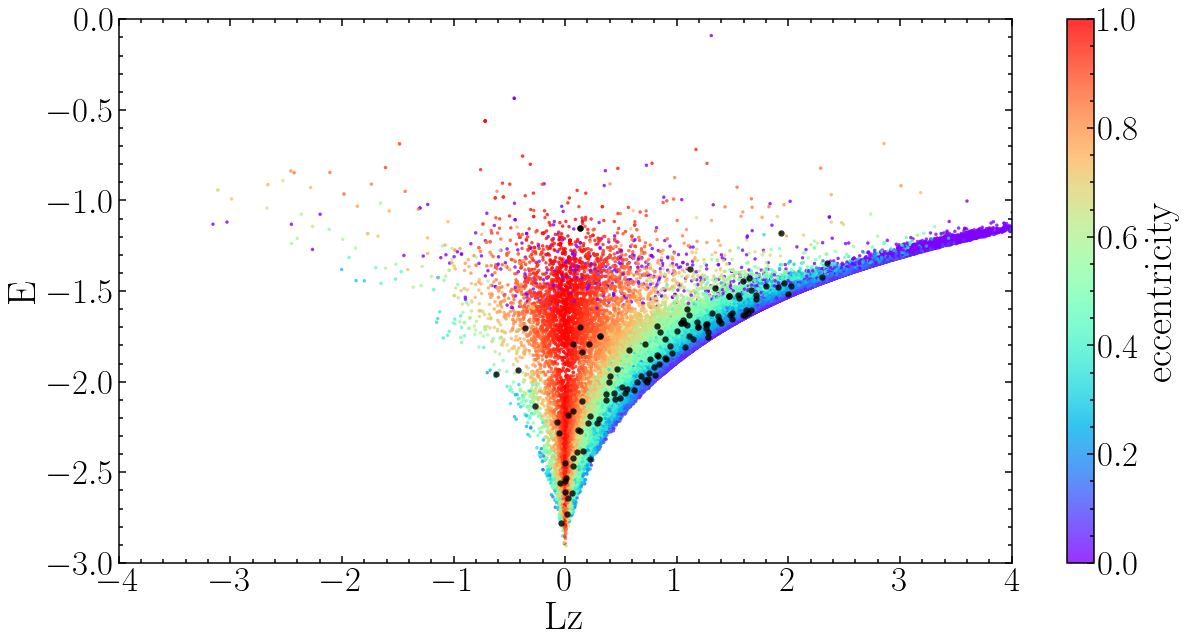

In [59]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10


#plt.scatter(lz,ener,c=ecc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
#plt.scatter(lz[newmask],ener[newmask],c=ecc[newmask], alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.scatter(lz[dist<15],ener[dist<15],c=ecc[dist<15], alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.xlabel('Lz',size=labs)
plt.ylabel('E',size=labs)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('eccentricity',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
plt.xlim(-4,4)
plt.ylim(-3,0)

plt.scatter(lz_ins[mask_acc_2g],ener_ins[mask_acc_2g],c='black',alpha=0.8,s=40,lw=0)

plt.savefig('IoM_ecc_Nrich.png',format='png',bbox_inches='tight')


#plt.scatter(lz_ins[mask_ins_2g&mask_other],ener_ins[mask_ins_2g&mask_other],c='green',alpha=0.8,s=40,lw=0)




In [60]:
ids_ins_2g = ids_ins[mask_ins_2g]
vr_ins_2g = vr_ins[mask_ins_2g]
vphi_ins_2g = vphi_ins[mask_ins_2g]
mask_3g = np.isin(ids_ins_2g,mask_other,invert=False)


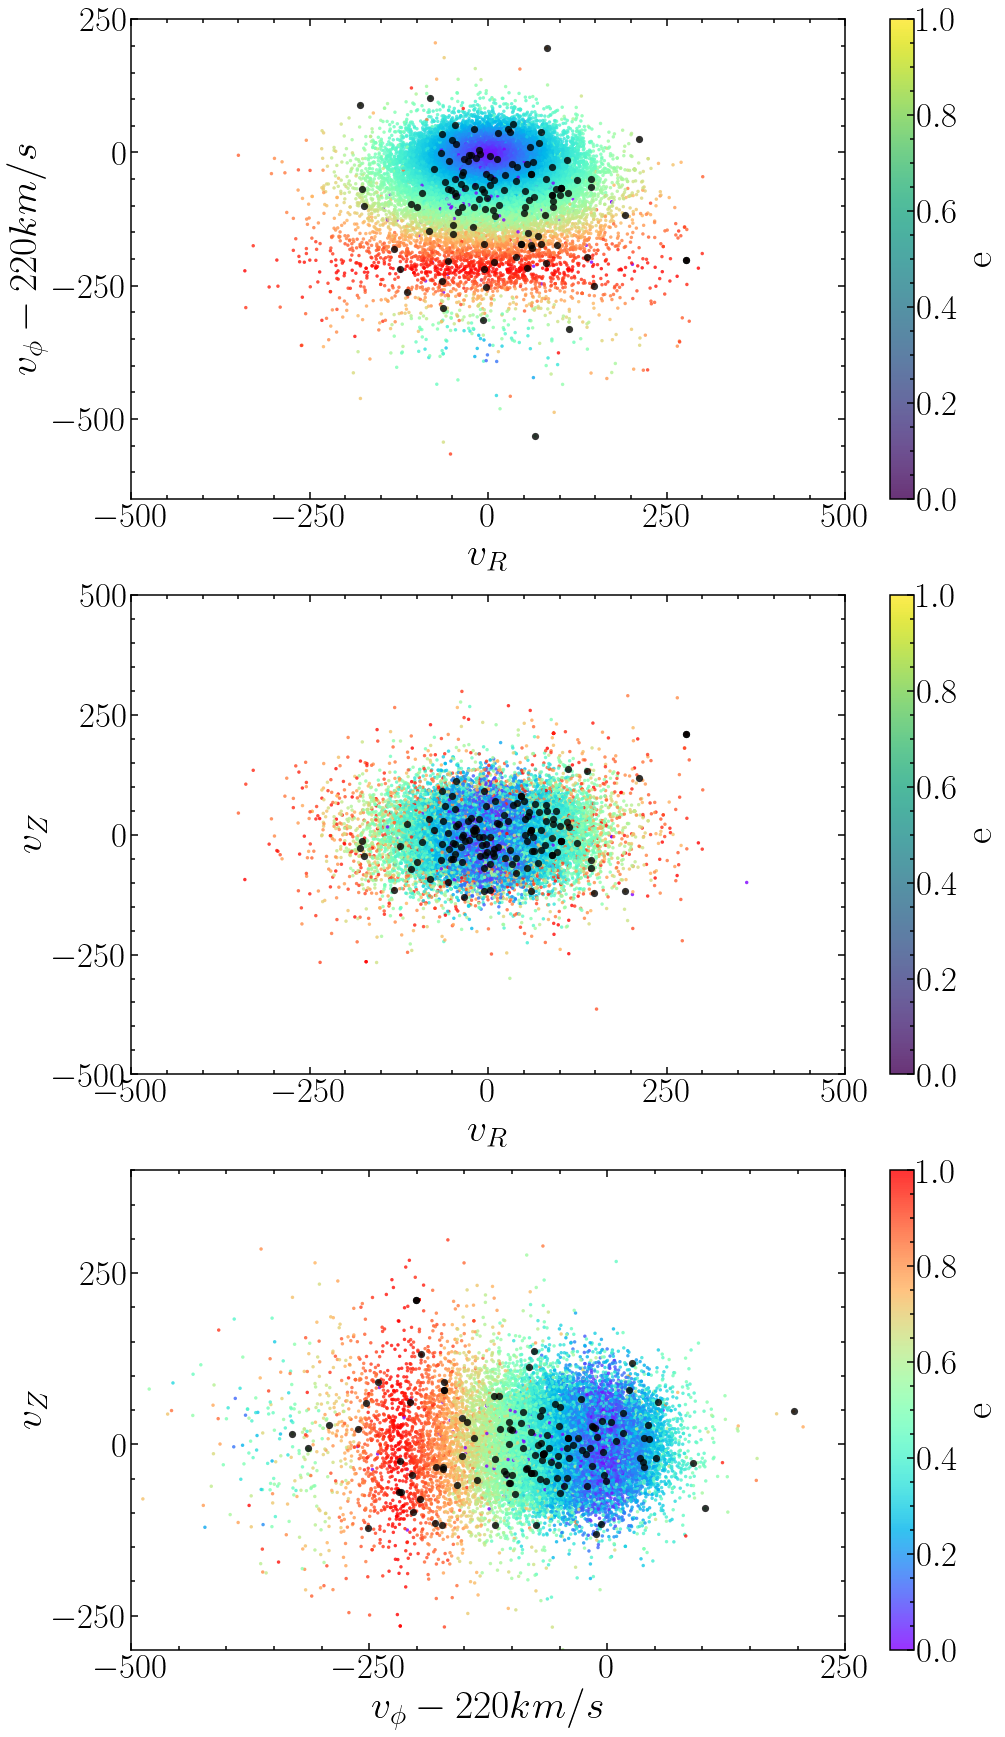

In [62]:
# Mackereth et al. 2019 kinematic plots

# Set figure width to 16 and height to 12
fig_size[0] = 16
fig_size[1] = 30


mask_sgrout = (ecc_ins > 0.15 )

plt.subplot(311)
plt.scatter(vr_ins[dist_ins<15],vphi_ins[dist_ins<15]-220,c=ecc_ins[dist_ins<15], alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
#plt.scatter(vr_ins_2g,vphi_ins_2g-220,c='black', alpha=0.8,s=52,lw=0)
#plt.scatter(vr_ins_2g[mask_3g],vphi_ins_2g[mask_3g]-220,c='blue', alpha=0.8,s=52,lw=0)
plt.scatter(vr_ins[mask_ins_2g],vphi_ins[mask_ins_2g]-220,c='black', alpha=0.8,s=52,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
cb=plt.colorbar()
cb.set_label('e',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xlabel('$v_R$',size=labs)
plt.ylabel('$v_\phi-220km/s$',size=labs)
plt.xticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
plt.yticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-500,500)
plt.ylim(-650,250)

#Count the number of normal and N-rich stars within the sausage to check whether the ratios are the same.

#ntot_ins = len(vr_ins)
#ntot_nrich = len(vrr_ins)

#mask_getot = ( (vr_ins > -250) & (vr_ins < 250) & (vphi_ins > -55) & (vphi_ins < 70))
#mask_genri = ( (vrr_ins > -250) & (vrr_ins < 250) & (vphir_ins > -55) & (vphir_ins < 70))

#vr_ge = vr_ins[mask_getot]
#vr_nr = vrr_ins[mask_genri]
#nge_ins = len(vr_ge)
#nge_nrich = len(vr_nr)
#print((nge_ins/ntot_ins),(nge_nrich/ntot_nrich))
#error_ins = np.sqrt(nge_ins)/ntot_ins + (nge_ins/ntot_ins**2.)*np.sqrt(ntot_ins)
#error_nrich = np.sqrt(nge_nrich)/ntot_nrich + (nge_nrich/ntot_nrich**2.)*np.sqrt(ntot_nrich)
#print(error_ins,error_nrich)
#print(nge_ins,ntot_ins,nge_nrich,ntot_nrich)


plt.subplot(312)
plt.scatter(vr_ins[dist_ins<15],vz_ins[dist_ins<15],c=ecc_ins[dist_ins<15], alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.scatter(vr_ins[mask_ins_2g],vz_ins[mask_ins_2g],c='black', alpha=0.8,s=52,lw=0)

cb= plt.colorbar()
cb.set_label('e',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xlabel('$v_R$',size=labs)
plt.ylabel('$v_Z$',size=labs)
plt.xticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
plt.yticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-500,500)
plt.ylim(-500,500)
#plt.errorbar(vrr_ins2,vzr_ins2,xerr=vrr_err_ins2,yerr=vzr_err_ins2,ecolor='black',linestyle='None')
#plt.scatter(vrr_ins2,vzr_ins2,c=eccr_ins2, alpha=2,s=52,cmap='rainbow',lw=0,vmin=0,vmax=1)

#plt.plot([200,260,260,200,200],[110,110,230,230,110], 'k', c='black')
mask_thang = ( (vr_ins > 200) & (vr_ins < 260) & (vz_ins > 110) & (vz_ins < 230))
ids_thang = ids_ins[mask_thang]

#Save thang star IDs to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
col1 = fits.Column(name='APOGEE ID', array=ids_thang, format='30A')
cols = fits.ColDefs([col1])
hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('Thang_IDs.fits')


plt.subplot(313)
plt.scatter(vphi_ins[dist_ins<15]-220,vz_ins[dist_ins<15],c=ecc_ins[dist_ins<15], alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
#plt.scatter(cfer_ins2,nfer_ins2,c='red', alpha=0.8,s=30,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('e',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xlabel('$v_\phi-220km/s$',size=labs)
plt.ylabel('$v_Z$',size=labs)
plt.xticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
plt.yticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-500,250)
plt.ylim(-300,400)
plt.scatter(vphi_ins[mask_ins_2g]-220,vz_ins[mask_ins_2g],c='black', alpha=0.8,s=52,lw=0)
#plt.errorbar(vphir_ins2-220,vzr_ins2,xerr=vphir_err_ins2,yerr=vzr_err_ins2,ecolor='black',linestyle='None')
#plt.scatter(vphir_ins2-220,vzr_ins2,c=eccr_ins2, alpha=2,s=52,cmap='rainbow',lw=0,vmin=0,vmax=1)

plt.savefig('Kinematics_detailed.png',format='png',bbox_inches='tight')



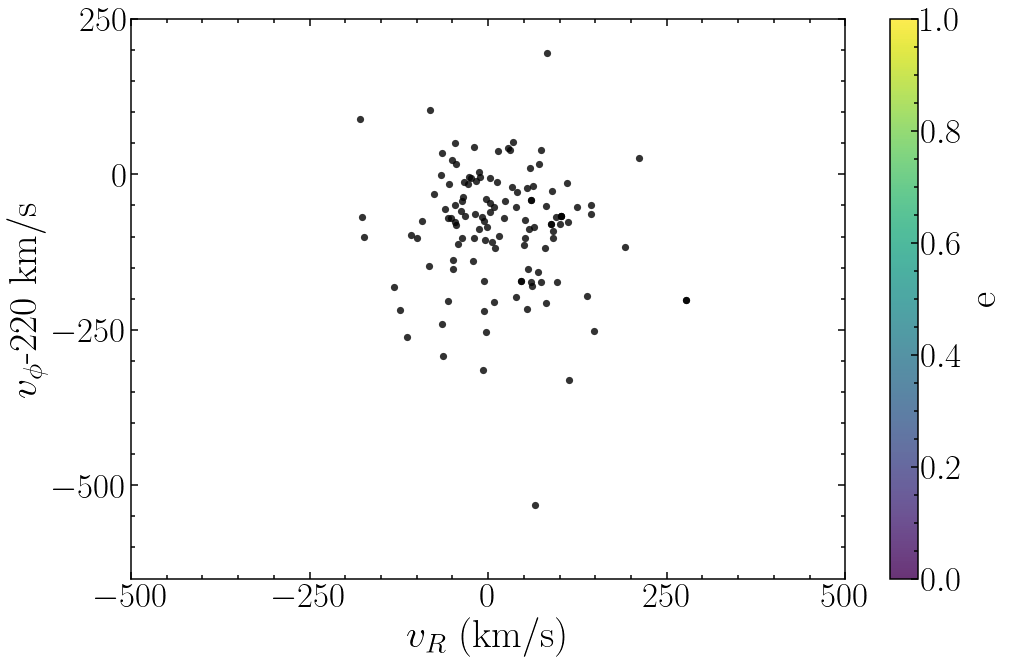

In [64]:
# Mackereth et al. 2019 kinematic plots

# Set figure width to 16 and height to 12
fig_size[0] = 16
fig_size[1] = 35


mask_sgrout = (ecc_ins > 0.15 )

plt.subplot(311)
#plt.scatter(vr_acc[dist_acc<15],vphi_acc[dist_acc<15]-220,c=ecc_acc[dist_acc<15], alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
#plt.scatter(vr_acc_2g,vphi_acc_2g-220,c='black', alpha=0.8,s=52,lw=0)
#plt.scatter(vr_acc_2g[mask_3g],vphi_acc_2g[mask_3g]-220,c='blue', alpha=0.8,s=52,lw=0)
plt.scatter(vr_ins[mask_ins_2g],vphi_ins[mask_ins_2g]-220,c='black', alpha=0.8,s=52,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
cb=plt.colorbar()
cb.set_label('e',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xlabel('$v_R$ (km/s)',size=labs)
plt.ylabel('$v_\phi$-220 km/s',size=labs)
plt.xticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
plt.yticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-500,500)
plt.ylim(-650,250)

plt.savefig('Kinematics_detailed_noback.png',format='png',bbox_inches='tight')


# Testing area

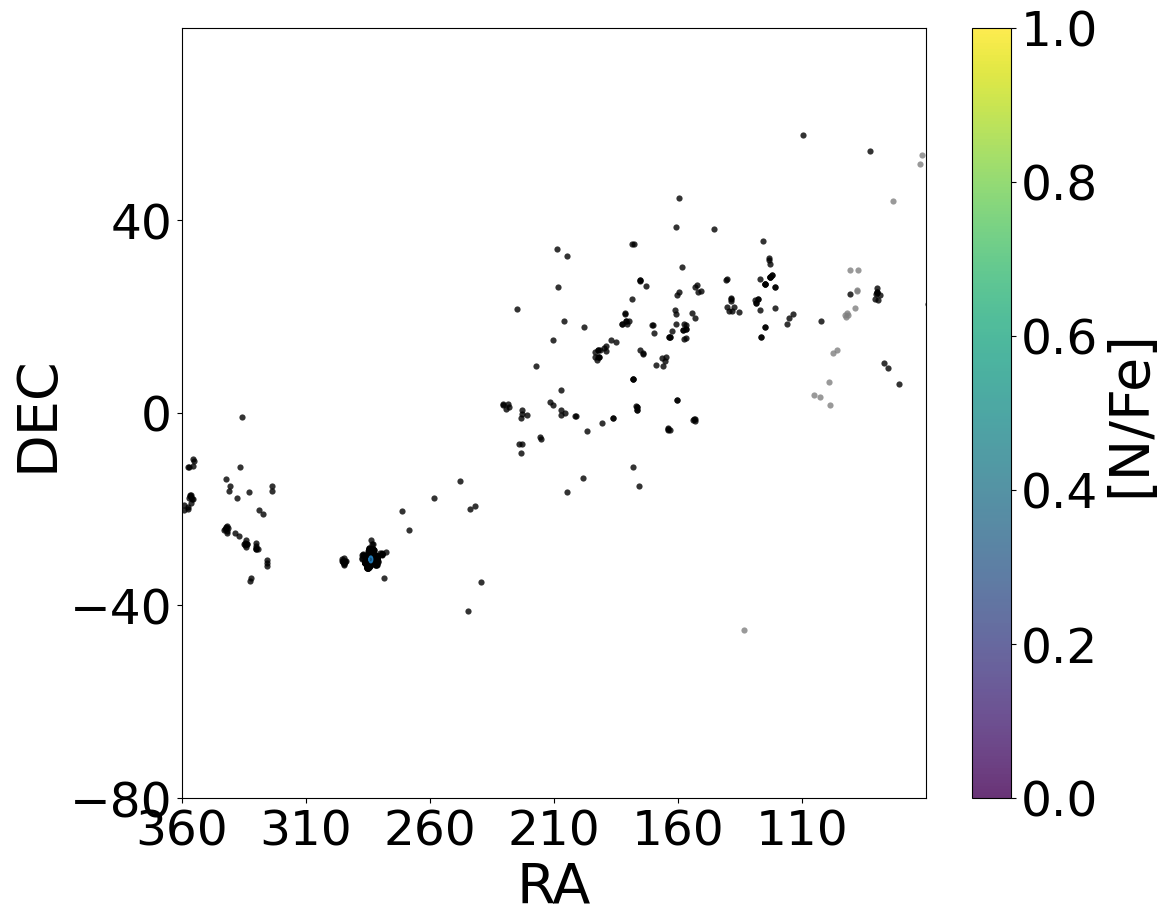

NameError: name 'ra_sgr' is not defined

In [31]:
#The credible N-rich stars seem to all be in 47 Tuc (missed by Danny's routine)
fig_size[0] = 12  
fig_size[1] = 10

mask_plusgr = ( (ener > -1.2) & (ecc < 0.2) & (ecc > 0.0) )

plt.scatter(ra[mask_plusgr],dec[mask_plusgr],c='Gray',alpha=0.8,s=20,lw=0)
plt.scatter(ara[mask_sgr],adec[mask_sgr],c='Black',alpha=0.8,s=20,lw=0)
plt.xlabel('RA',size=labs)
plt.ylabel('DEC',size=labs)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('[N/Fe]',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xticks((np.arange(360,60,step=-50)),fontsize=tcks)
plt.yticks((np.arange(-80,80,step=40)),fontsize=tcks)
plt.xlim(360,60)
plt.ylim(-80,80)



#Draw a circle
theta = np.linspace(0, 2*np.pi, 100)
rtidal = 180./np.pi * 283.27/26283.3
r = 0.1845

x1 = 283.7639 + rtidal*np.cos(theta)
x2 = -30.4799 + rtidal*np.sin(theta)
plt.plot(x1, x2)
plt.show()

print((ra_sgr[mask_sgr_2g]),dec_sgr[mask_sgr_2g])


# Testing a selection based on Si/Mn vs C/Fe

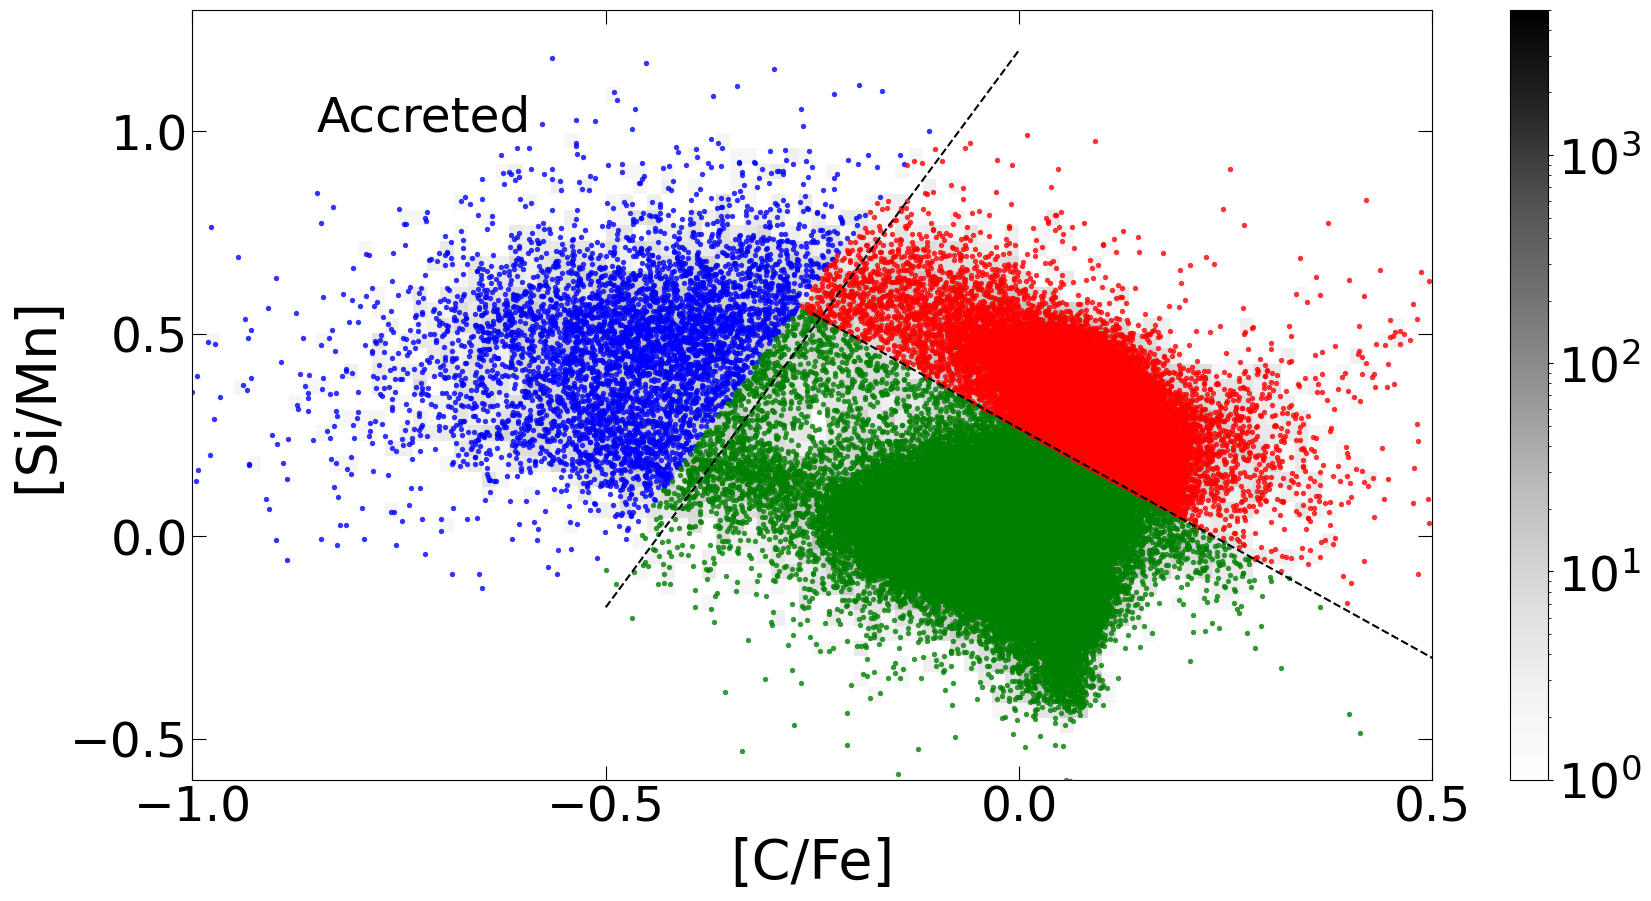

In [32]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#plt.scatter(feh,alfe,c=cn, cmap='rainbow',alpha=0.4,s=30,lw=0,vmin=-0.7,vmax=0.7)
plt.hist2d(cfe, simn, norm=mpl.colors.LogNorm(), bins=(120, 50),range=[[-1.,1],[-0.6,1.3]], cmap='Greys')
plt.clim(1,5000)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
#cb.set_label('Stars per bin',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[C/Fe]',size=labs)
plt.ylabel('[Si/Mn]',size=labs)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.xticks((np.arange(-3.0,1.5,step=0.5)),fontsize=tcks)
plt.yticks((np.arange(-1.5,1.5,step=0.5)),fontsize=tcks)
plt.tick_params(which='minor',direction='in',right=True,top=True,length=2)
plt.xlim(-1.0,0.5)
plt.ylim(-0.6,1.3)
plt.text(-0.85,1,'Accreted',fontsize=35)
#plt.text(0.4,-0.3,'{\it In situ} low $\\alpha$',fontsize=35)
#plt.text(0.4,1.0,'{\it In situ} high $\\alpha$',fontsize=35)
#plt.scatter(cfe_acc3, simn_acc3, c='black', alpha=0.8,s=15,lw=0)
#plt.scatter(cfe_what, simn_what, c='orange', alpha=0.8,s=15,lw=0)
#plt.scatter(cfe_acc, simn_acc, c='red', alpha=0.8,s=15,lw=0)
#plt.scatter(cfe_acc2, simn_acc2, c='blue', alpha=0.8,s=15,lw=0)
#plt.scatter(cfe[acc_maskb], simn[acc_maskb], c='blue', alpha=0.8,s=15,lw=0)
#plt.scatter(cfe[acc_mask], simn[acc_mask], c='blue', alpha=0.8,s=15,lw=0)

plt.plot([-0.5,0.0],[-0.175,1.2], '--', c='black')
#The above line implies this relation:  y = 2.75*x + 1.2

new_accmask = ( ((simn > -0.2) & (cfe < -0.51)) | ( (simn > 2.75*cfe + 1.3) & (cfe >= -0.51) ) )
plt.scatter(cfe[new_accmask], simn[new_accmask], c='blue', alpha=0.8,s=15,lw=0)

plt.plot([-0.25,0.5],[0.55,-0.3], '--', c='black')

loa_mask = ( ( (cfe < -0.268) & (simn < 2.75*cfe + 1.3) )  |  ( (cfe >= -0.268) & (simn < -1.133*cfe + 0.267) ) )
plt.scatter(cfe[loa_mask], simn[loa_mask], c='green', alpha=0.8,s=15,lw=0)
    
hia_mask = ( ( (cfe > -0.268) & (simn < 2.75*cfe + 1.3) & (simn > -1.133*cfe + 0.267) ) )
plt.scatter(cfe[hia_mask], simn[hia_mask], c='red', alpha=0.8,s=15,lw=0)
    

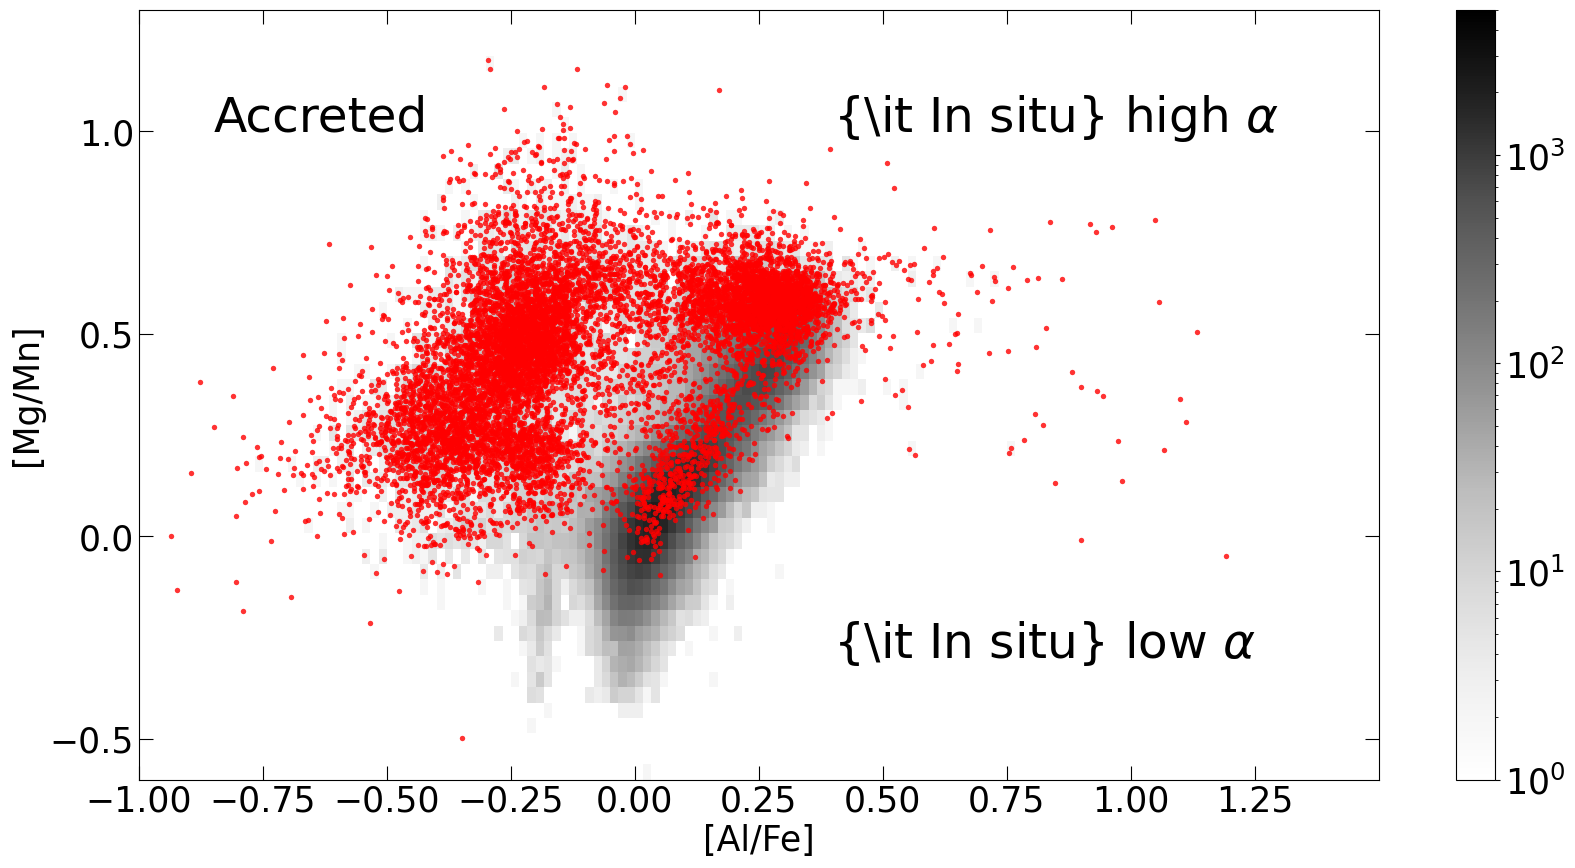

In [33]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=25
tcks=25

#plt.scatter(feh,alfe,c=cn, cmap='rainbow',alpha=0.4,s=30,lw=0,vmin=-0.7,vmax=0.7)
plt.hist2d(alfe, mgmn, norm=mpl.colors.LogNorm(), bins=(120, 50),range=[[-1.,1],[-0.6,1.3]], cmap='Greys')
plt.clim(1,5000)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
#cb.set_label('Stars per bin',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Al/Fe]',size=labs)
plt.ylabel('[Mg/Mn]',size=labs)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.xticks((np.arange(-3.0,1.5,step=0.25)),fontsize=tcks)
plt.yticks((np.arange(-1.5,1.5,step=0.5)),fontsize=tcks)
plt.tick_params(which='minor',direction='in',right=True,top=True,length=2)
plt.xlim(-1.0,1.5)
plt.ylim(-0.6,1.3)
plt.text(-0.85,1,'Accreted',fontsize=35)
plt.text(0.4,-0.3,'{\it In situ} low $\\alpha$',fontsize=35)
plt.text(0.4,1.0,'{\it In situ} high $\\alpha$',fontsize=35)
plt.scatter(alfe[new_accmask2], mgmn[new_accmask2], c='red', alpha=0.8,s=15,lw=0)



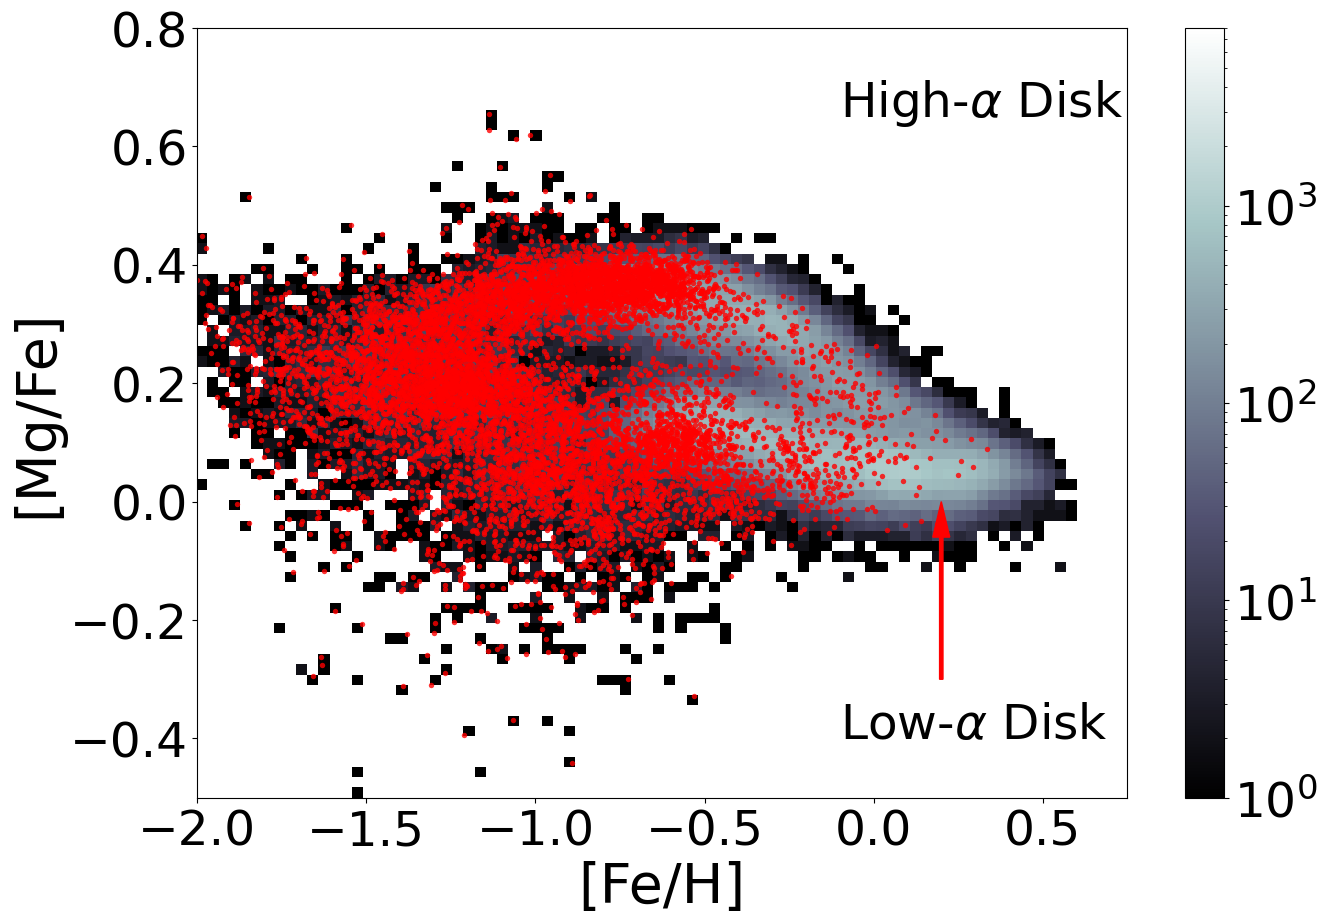

In [34]:
#DISPLAY SAMPLE IN A-FE PLANE.  CHOOSE SI FOR ALPHA ELEMENT

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

labs = 40
tcks = 35


plt.hist2d(feh,mgfe,norm=mpl.colors.LogNorm(), bins=(100, 75),range=[[-2.5,0.8],[-0.5,.8]], cmap='bone')
#Figure settings (labels, log scale, limits, legend position)   
plt.clim(1,8000)
cb= plt.colorbar()
#cb.set_label('Number',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[Mg/Fe]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.0,0.75)
plt.ylim(-0.5,0.8)
plt.text(-0.1,-0.4,'Low-$\\alpha$ Disk',fontsize=35)
plt.text(-0.1,0.65,'High-$\\alpha$ Disk',fontsize=35)
plt.arrow(0.2,-0.3,0,0.3,width=0.01,head_width=0.05,head_length=0.06,length_includes_head=True,color='red')

mgfe_acc3 = mgfe[new_accmask2]
feh_acc3 = feh[new_accmask2]
plt.scatter(feh_acc3,mgfe_acc3,c='red',alpha=0.8,s=15,lw=0) 

#mgfe_what = mgfe[mask_what]
#feh_what = feh[mask_what]
#plt.scatter(feh_what,mgfe_what,c='blue',alpha=0.8,s=30,lw=0) 

#print(len(feh_hiad),len(feh_load),len(feh_acc))
plt.savefig('mgfe_disks.png',format='png',bbox_inches='tight')


plt.show()



/var/folders/8d/f33468051dg800k3mh7xqksr0000gq/T/ipykernel_95212/2411385928.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot([0.05,0.05,-0.35,-0.9,-0.9,-0.35,-0.1,0.5],[0.1,0.2,0.35,0.35,0.17,0.17,0.1,0.1], 'k', c='red')
/var/folders/8d/f33468051dg800k3mh7xqksr0000gq/T/ipykernel_95212/2411385928.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot([-0.75,-0.75,-0.35,0.65,0.65,0.5],[0.17,0.05,-0.04,-0.04,0.1,0.1], 'k', c='red')
/var/folders/8d/f33468051dg800k3mh7xqksr0000gq/T/ipykernel_95212/2411385928.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x,-0.375*x+0.2188, 'k', c='b

NameError: name 'newmask' is not defined

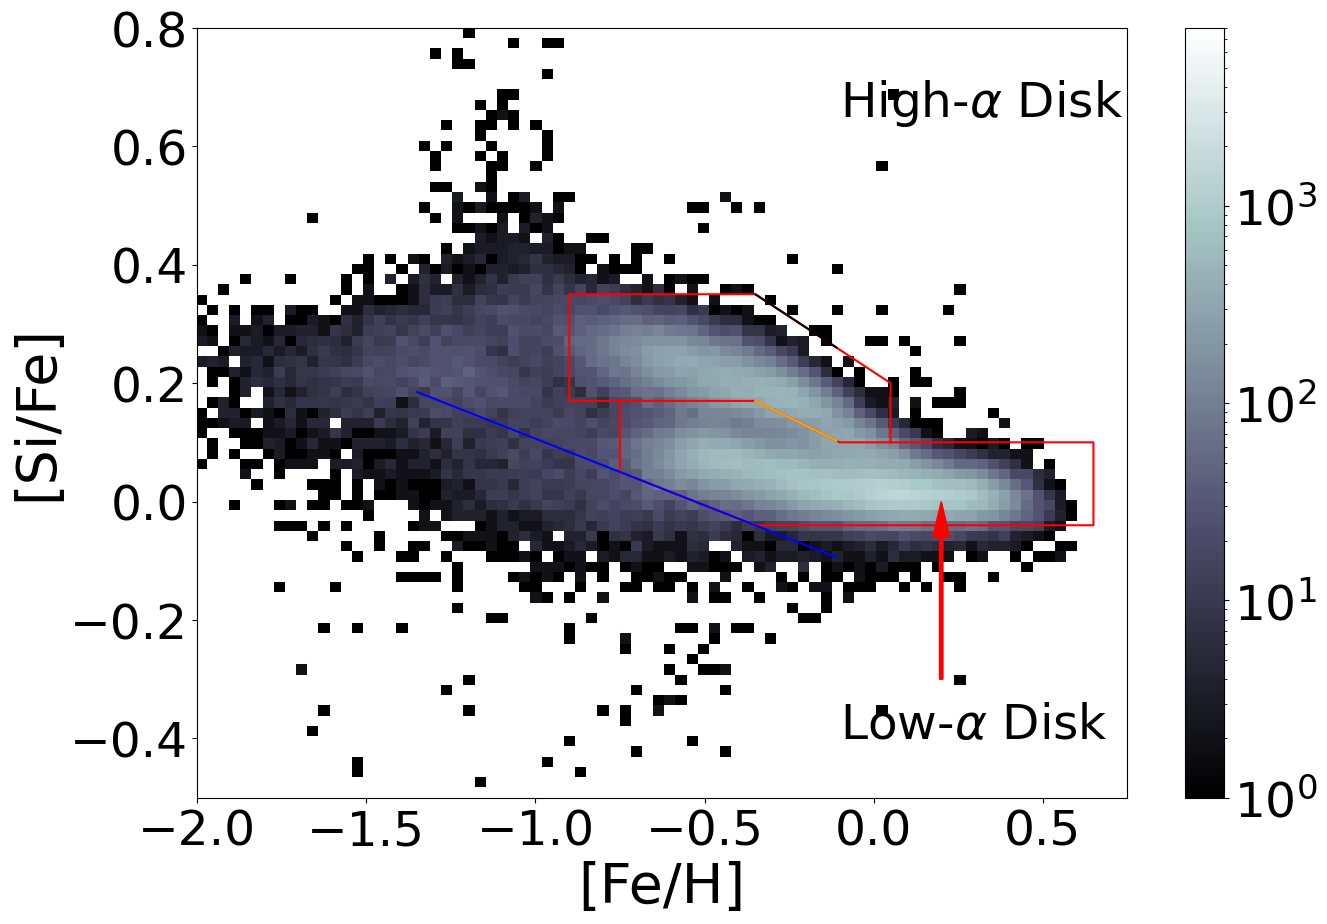

In [35]:
#DISPLAY SAMPLE IN A-FE PLANE.  CHOOSE SI FOR ALPHA ELEMENT

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

labs = 40
tcks = 35


plt.hist2d(feh,sife,norm=mpl.colors.LogNorm(), bins=(100, 75),range=[[-2.5,0.8],[-0.5,.8]], cmap='bone')
#Figure settings (labels, log scale, limits, legend position)   
plt.clim(1,8000)
cb= plt.colorbar()
#cb.set_label('Number',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[Si/Fe]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.0,0.75)
plt.ylim(-0.5,0.8)
plt.text(-0.1,-0.4,'Low-$\\alpha$ Disk',fontsize=35)
plt.text(-0.1,0.65,'High-$\\alpha$ Disk',fontsize=35)
plt.arrow(0.2,-0.3,0,0.3,width=0.01,head_width=0.05,head_length=0.06,length_includes_head=True,color='red')



#plt.plot([0.5,0.5,0.05,-0.35,-0.9,-0.9,-0.35,-0.1,0.5],[0.1,0.2,0.2,0.35,0.35,0.17,0.17,0.1,0.1], 'k', c='red')
plt.plot([0.05,0.05,-0.35,-0.9,-0.9,-0.35,-0.1,0.5],[0.1,0.2,0.35,0.35,0.17,0.17,0.1,0.1], 'k', c='red')
plt.plot([-0.75,-0.75,-0.35,0.65,0.65,0.5],[0.17,0.05,-0.04,-0.04,0.1,0.1], 'k', c='red')
x = np.arange(-0.35,-0.1,0.01)
plt.plot(x,-0.375*x+0.2188, 'k', c='black')
plt.plot(x,-0.28*x+0.0720, 'k', c='orange')
x = np.arange(-1.35,-0.1,0.01)
plt.plot(x,-0.225*x-0.1188, 'k', c='blue')

divline_top = -0.375*feh+0.2188
divline_mid = -0.28*feh+0.0720
divline_bot = -0.225*feh-0.1188

eps = 0.04

mask_hiad = ( ((feh>=-0.9)&(feh<-0.35)&(sife<0.35)&(sife>0.17+eps)) | \
            ((feh>=-0.35)&(feh<-0.1)&(sife<divline_top)&(sife>divline_mid+eps))| \
            ((feh>=-0.1)&(feh<0.05)&(sife>0.1+eps)&(sife<divline_top))   ) 

mask_load = ( ((feh>=-0.75)&(feh<-0.35)&(sife<0.17-eps)&(sife>divline_bot)) |  \
              ((feh>=-0.35)&(feh<-0.1)&(sife<divline_mid-eps)&(sife>-0.04)) | \
              ((feh>=-0.1)&(feh<0.6)&(sife<0.1-eps)&(sife>-0.04))   ) 

#mask_acc = ( ( (feh<-0.35) & (sife < divline_bot-eps) & (feh > -0.9) & (sife > -0.5) ) | 
#              ( (feh < -0.9) & (feh > -2.5) & (sife > -0.5) & (sife < 0.8) )  |
#              ( (feh < 0.3) & (feh > -0.35) & (sife > -0.5) & (sife < -0.04 -eps) ) )


plt.scatter(feh[newmask],sife[newmask],c='black',alpha=0.8,s=20,lw=0) 


plt.show()



NameError: name 'newmask' is not defined

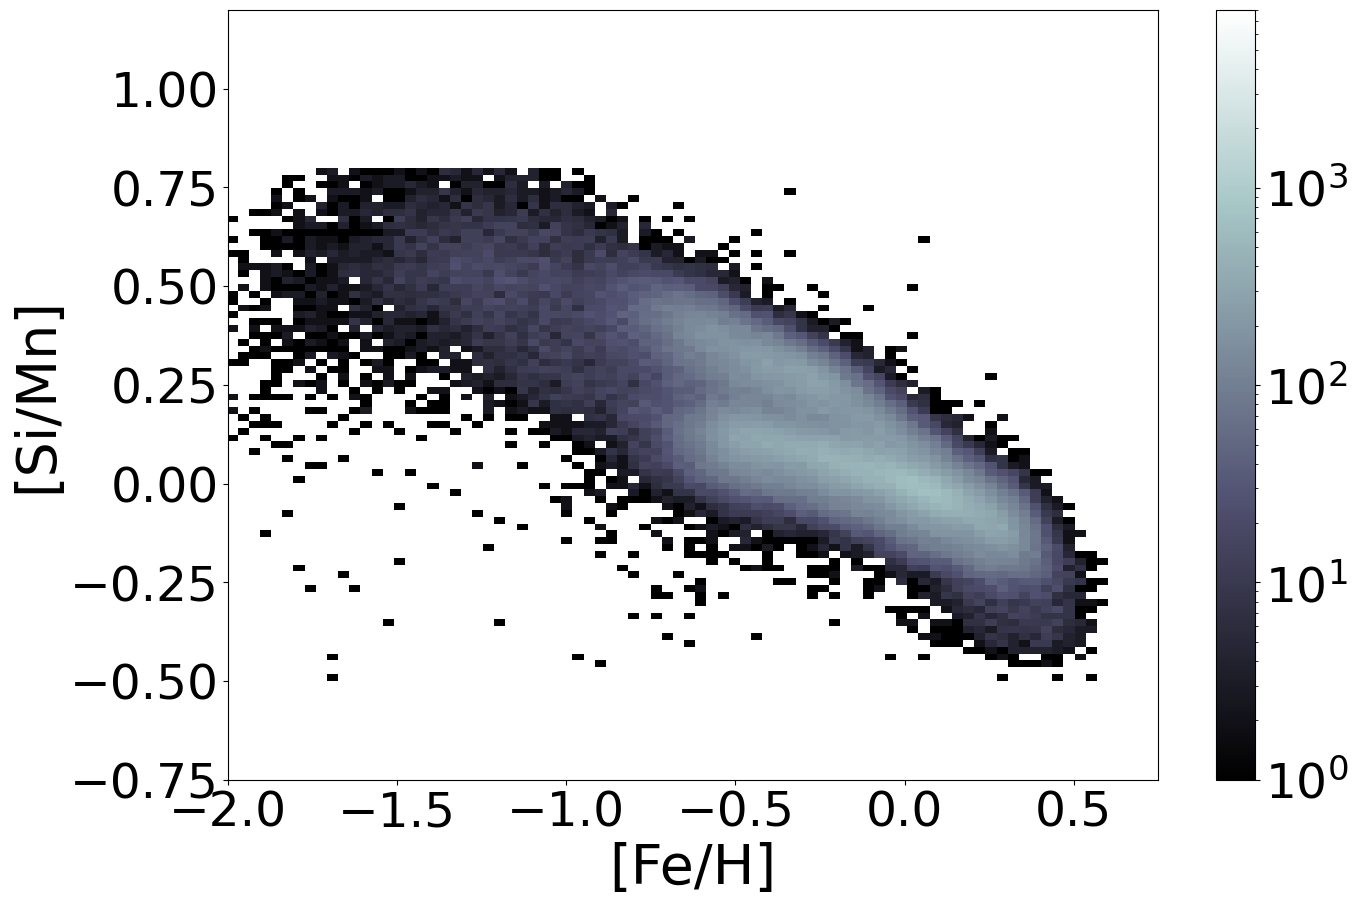

In [36]:
#DISPLAY SAMPLE IN A-FE PLANE.  CHOOSE SI FOR ALPHA ELEMENT

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

labs = 40
tcks = 35


plt.hist2d(feh,simn,norm=mpl.colors.LogNorm(), bins=(100, 75),range=[[-2.5,0.8],[-0.5,.8]], cmap='bone')
#Figure settings (labels, log scale, limits, legend position)   
plt.clim(1,8000)
cb= plt.colorbar()
#cb.set_label('Number',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[Si/Mn]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.0,0.75)
plt.ylim(-0.75,1.2)

plt.scatter(feh[newmask],simn[newmask],c='blue',alpha=0.8,s=20,lw=0) 

#sife_what = sife[mask_what]
#feh_what = feh[mask_what]
#plt.scatter(feh_what,sife_what,c='blue',alpha=0.8,s=30,lw=0) 

plt.savefig('mgfe_disks.png',format='png',bbox_inches='tight')


plt.show()



NameError: name 'newmask' is not defined

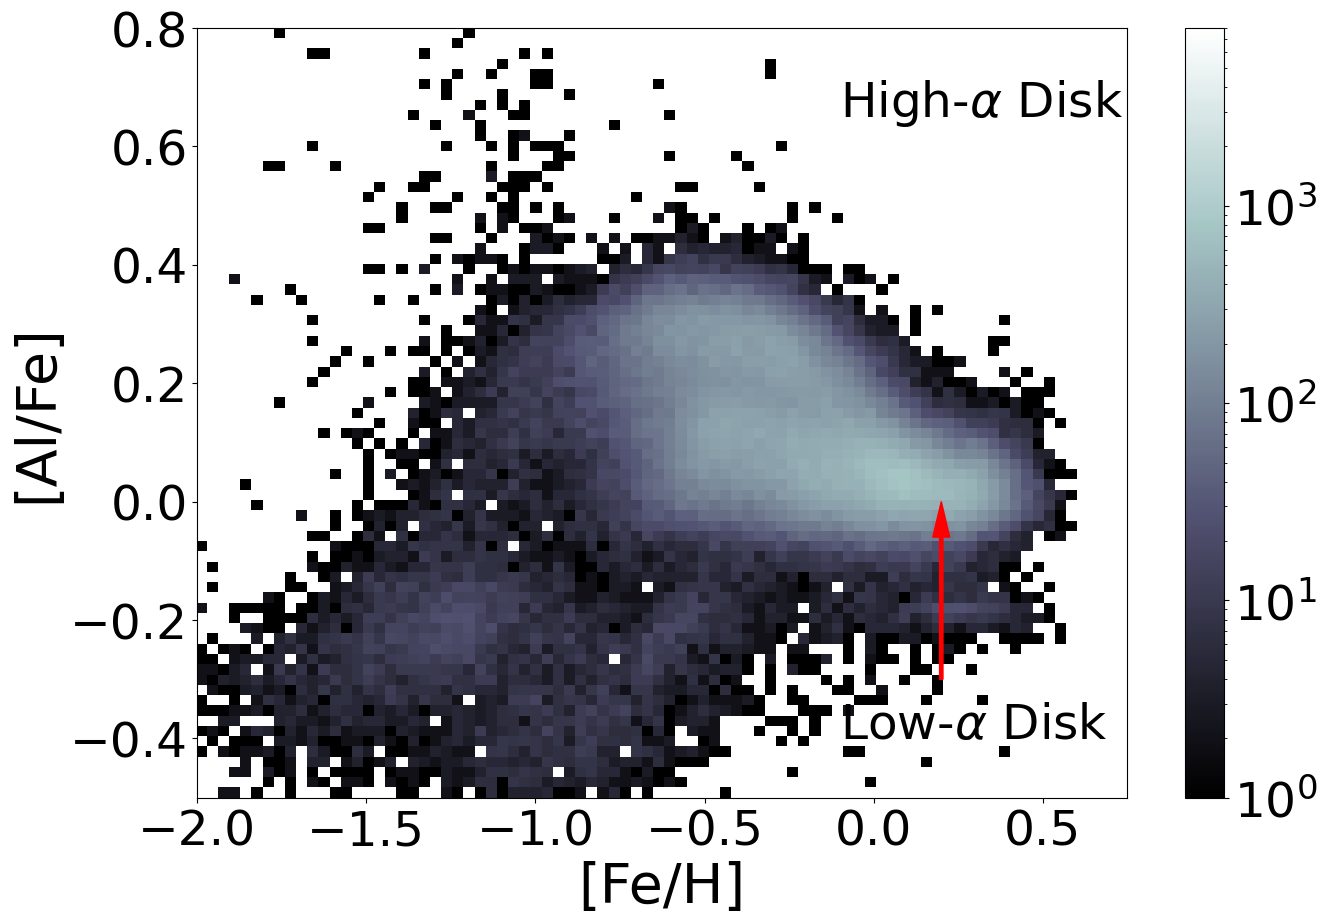

In [37]:
#DISPLAY SAMPLE IN A-FE PLANE.  CHOOSE SI FOR ALPHA ELEMENT

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

labs = 40
tcks = 35


plt.hist2d(feh,alfe,norm=mpl.colors.LogNorm(), bins=(100, 75),range=[[-2.5,0.8],[-0.5,.8]], cmap='bone')
#Figure settings (labels, log scale, limits, legend position)   
plt.clim(1,8000)
cb= plt.colorbar()
#cb.set_label('Number',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[Al/Fe]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.0,0.75)
plt.ylim(-0.5,0.8)
plt.text(-0.1,-0.4,'Low-$\\alpha$ Disk',fontsize=35)
plt.text(-0.1,0.65,'High-$\\alpha$ Disk',fontsize=35)
plt.arrow(0.2,-0.3,0,0.3,width=0.01,head_width=0.05,head_length=0.06,length_includes_head=True,color='red')


plt.scatter(feh[newmask],alfe[newmask],c='blue',alpha=0.8,s=20,lw=0) 

#mgfe_what = mgfe[mask_what]
#feh_what = feh[mask_what]
#plt.scatter(feh_what,mgfe_what,c='blue',alpha=0.8,s=30,lw=0) 

plt.savefig('alfe_disks.png',format='png',bbox_inches='tight')


plt.show()



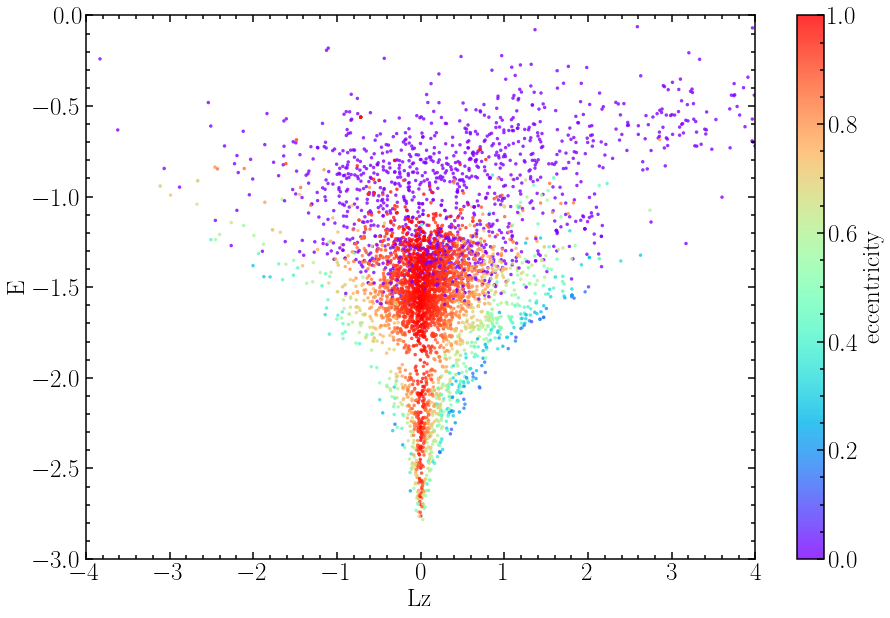

In [14]:

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

labs = 25
tcks = 25

#plt.scatter(lz,ener,c=ecc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
#plt.scatter(lz[newmask],ener[newmask],c=ecc[newmask], alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.scatter(lz[newmask],ener[newmask],c=ecc[newmask], alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.xlabel('Lz',size=labs)
plt.ylabel('E',size=labs)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('eccentricity',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
plt.xlim(-4,4)
plt.ylim(-3,0)



#plt.savefig('IoM_ecc_total.png',format='png',bbox_inches='tight')
#plt.savefig('IoM_ecc_acc.png',format='png',bbox_inches='tight')
plt.savefig('IoM_ecc_acc.png',format='png',bbox_inches='tight')



# New accreted sample

In [15]:

# "ACCRETED"

ids_acc = ids[newmask] 
nvis_acc = nvis[newmask]
vscat_acc = vscat[newmask]
ra_acc = ra[newmask]
dec_acc = dec[newmask]
glon_acc = glon[newmask]
glat_acc = glat[newmask]
teff_acc = teff[newmask]
logg_acc = logg[newmask]
teff_e_acc = teff_e[newmask]
logg_e_acc = logg_e[newmask]
mgfe_acc = mgfe[newmask]
nfe_acc = nfe[newmask]
nife_acc = nife[newmask]
feh_acc = feh[newmask]
cafe_acc = cafe[newmask]
cfe_acc = cfe[newmask]
ofe_acc = ofe[newmask]
sife_acc = sife[newmask]
nife_acc = nife[newmask]
nafe_acc = nafe[newmask]
alfe_acc = alfe[newmask]
tife_acc = tife[newmask]
kfe_acc = kfe[newmask]
vfe_acc = vfe[newmask]
tife_acc = tife[newmask]
mnfe_acc = mnfe[newmask]
crfe_acc = crfe[newmask]
cufe_acc = cufe[newmask]
cefe_acc = cefe[newmask]
cofe_acc = cofe[newmask]
pfe_acc = pfe[newmask]
sfe_acc = sfe[newmask]
mgmn_acc = mgmn[newmask] 
alfe_err_acc = alfe_err[newmask]
mgmn_err_acc = mgmn_err[newmask] 

dist_acc = dist[newmask]
dist_err_acc = dist_err[newmask]
Rgc_acc = Rgc[newmask]
xx_acc = xx[newmask]
yy_acc = yy[newmask]
zz_acc = zz[newmask]

jmag_acc = jmag[newmask]
hmag_acc = hmag[newmask]
kmag_acc = kmag[newmask]

a_k_acc = a_k[newmask]
a_j_acc = a_j[newmask]

ecc_acc = ecc[newmask]
zmax_acc = zmax[newmask]
ener_acc = ener[newmask]
jr_acc = jr[newmask]
lz_acc = lz[newmask]
jz_acc = jz[newmask]
vr_acc = vr[newmask]


print(np.mean(dist_acc))
#Save N-rich star IDs and coordinates to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
col1 = fits.Column(name='APOGEE ID', array=ids_acc, format='30A')
col2 = fits.Column(name='RA', array=ra_acc, format='F')
col3 = fits.Column(name='DEC', array=dec_acc, format='F')
cols = fits.ColDefs([col1,col2,col3])
hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('Acc_IDs_coords.fits')



NameError: name 'vr' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


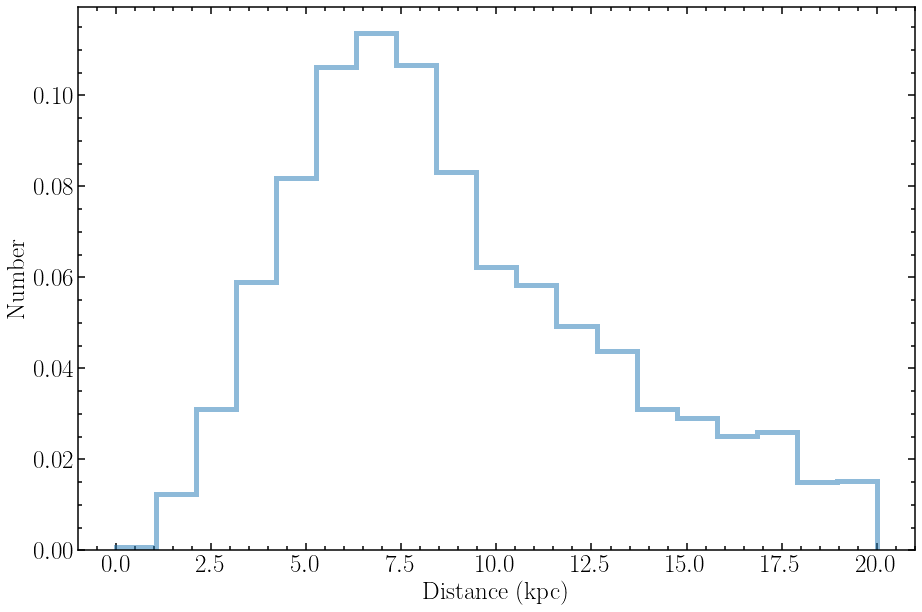

In [16]:
#Get current size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15 
fig_size[1] = 10

bins = np.linspace(0,20,20)
plt.hist(dist_acc, bins, alpha=0.5, histtype='step',linewidth=5, density=True)
#plt.hist(feh_bg2kpc, bins, alpha=0.5, density=False, label='In Situ')
#plt.arrow(-1.4,150,0,-40,width=0.01,head_width=0.001,head_length=0.3,length_includes_head=True,color='black')
#plt.arrow(-0.9,250,0,-40,width=0.01,head_width=0.001,head_length=0.3,length_includes_head=True,color='black')
plt.xlabel('Distance (kpc)',size=labs)
plt.ylabel('Number',size=labs)
plt.legend(frameon=False,fontsize=20,handletextpad=0.3,loc='upper left')
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)

plt.savefig('hist_FeHs.png',format='png',bbox_inches='tight')



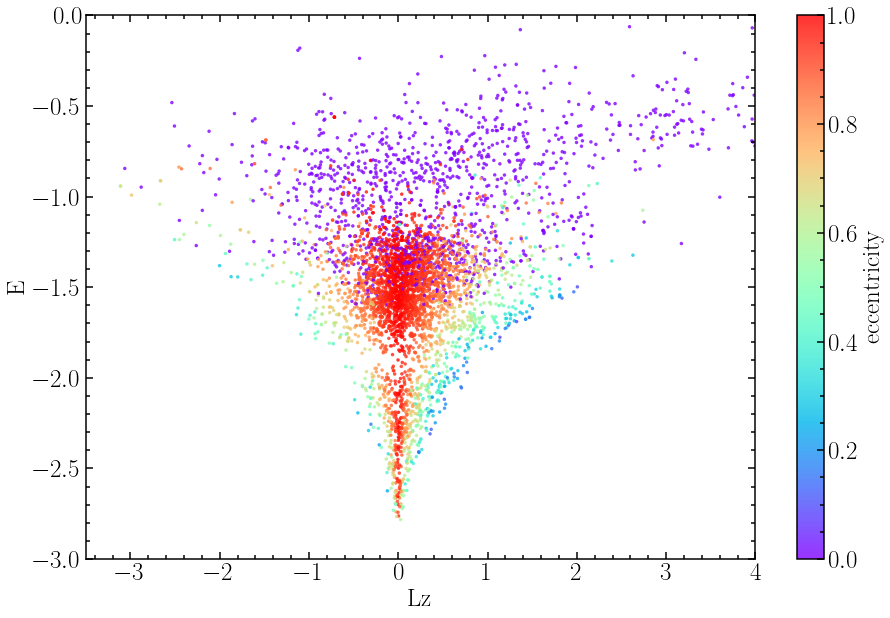

In [17]:
#Select low alpha disk only

plt.scatter(lz_acc,ener_acc,c=ecc_acc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.xlabel('Lz',size=labs)
plt.ylabel('E',size=labs)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('eccentricity',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-3.5,4.0)
plt.ylim(-3,0)

plt.savefig('IoM_acc_ecc.png',format='png',bbox_inches='tight')



4 116 0.034482758620689655


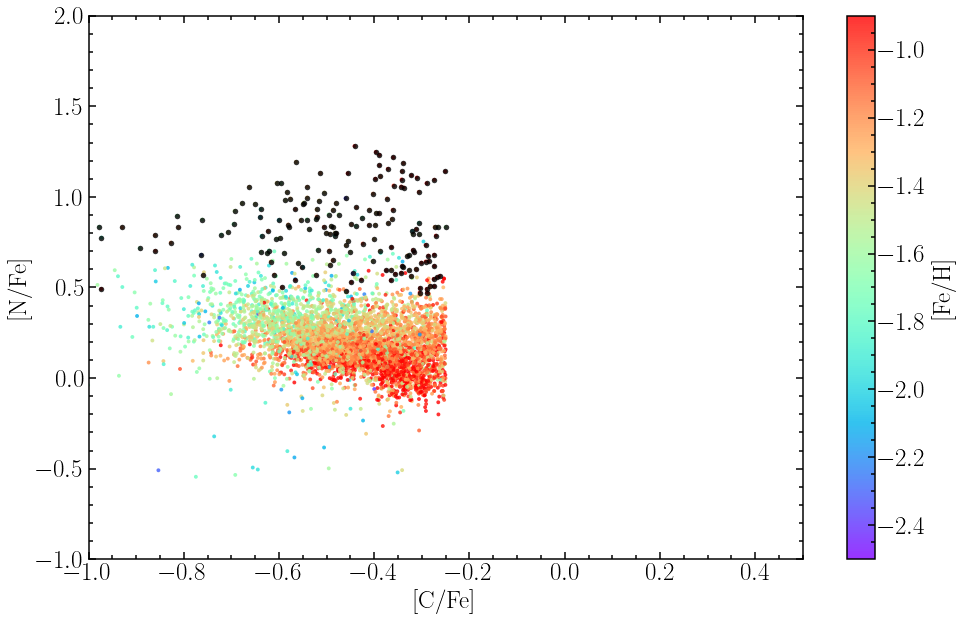

In [20]:
#HIGHALPHA HALO N-RICH STARS IN C-N PLANE

fig_size[0] = 16
fig_size[1] = 10

plt.scatter(cfe_acc,nfe_acc,c=feh_acc, alpha=0.8,s=15,cmap='rainbow',lw=0,vmin=-2.5,vmax=-0.9)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('[Fe/H]',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.scatter(cfe_acc_nrich,nfe_acc_nrich,c='black', alpha=0.8,s=30,lw=0)
#plt.scatter(mgfe_stream,alfe_stream,c='orange', alpha=0.8,s=60,lw=0)
#plt.scatter(gc_mgfe,gc_alfe,c='orange', alpha=0.8,s=30,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
#plt.yscale('log')
plt.xlabel('[C/Fe]',size=labs)
plt.ylabel('[N/Fe]',size=labs)
plt.xticks((np.arange(-1,0.6,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-1.5,2.5,step=0.5)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-1,0.5)
plt.ylim(-1,2)

#plt.plot([-0.3,0.25,0.25],[-0.1,-0.1,1.0], 'k', c='black')

plt.savefig('CN_lowalpa.png',format='png',bbox_inches='tight')


mask_relevant = nvis_acc_nrich > 1
vscat_relevant = vscat_acc_nrich[mask_relevant]
mask_variable = vscat_relevant > 1.0
vscat_variable = vscat_relevant[mask_variable]
print(len(vscat_variable),len(vscat_relevant),len(vscat_variable)/len(vscat_relevant))

#plt.scatter(cfe_acc_bin,nfe_acc_bin, alpha=0.8,s=15,c='blue')


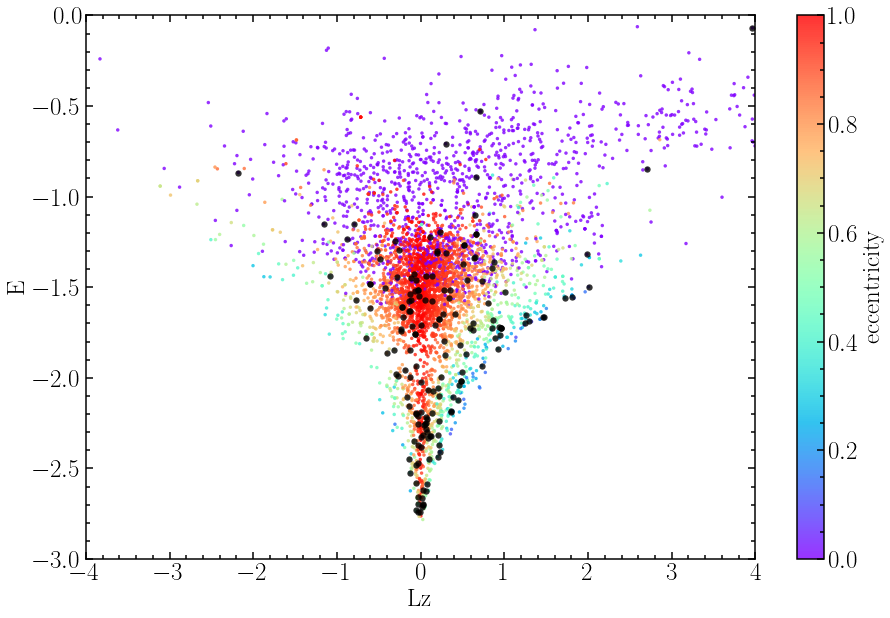

In [21]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

labs = 25
tcks = 25

#plt.scatter(lz,ener,c=ecc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
#plt.scatter(lz[newmask],ener[newmask],c=ecc[newmask], alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.scatter(lz[newmask],ener[newmask],c=ecc[newmask], alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.xlabel('Lz',size=labs)
plt.ylabel('E',size=labs)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('eccentricity',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
plt.xlim(-4,4)
plt.ylim(-3,0)

plt.scatter(lz_acc_nrich,ener_acc_nrich,c='black',alpha=0.8,s=40,lw=0)

plt.savefig('IoM_ecc_Nrich.png',format='png',bbox_inches='tight')






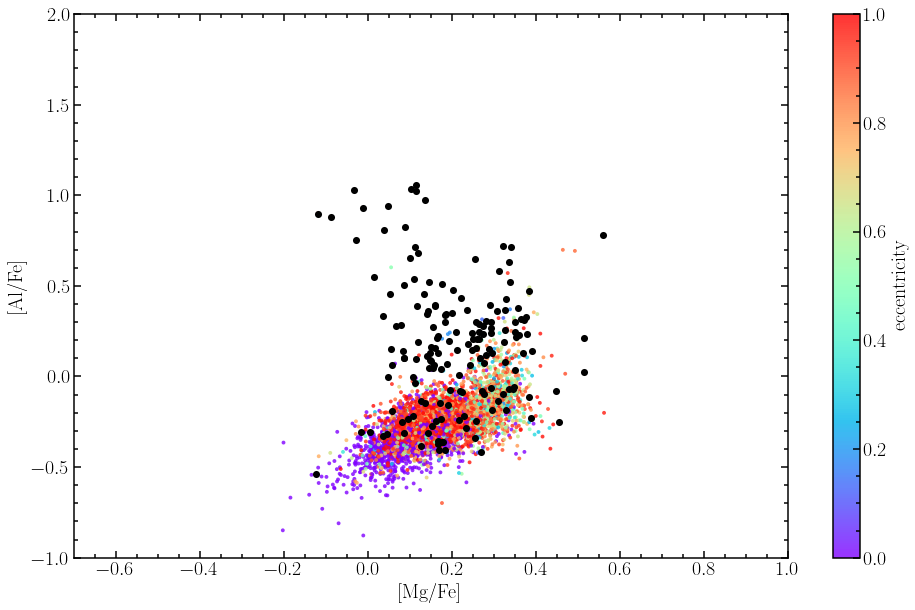

In [22]:
#HIGHALPHA HALO N-RICH STARS IN C-N PLANE

fig_size[0] = 16
fig_size[1] = 10

labs = 20
tcks = 20


#plt.hist2d(cfe_acc,nfe_acc,norm=mpl.colors.LogNorm(), bins=(100, 75),range=[[-1,0.5],[-0.5,1.5]], cmap='bone')
plt.scatter(mgfe_acc,alfe_acc,c=ecc_acc, alpha=0.8,s=15,cmap='rainbow',lw=0,vmin=0,vmax=1)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('eccentricity',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.scatter(mgfe_acc_nrich,alfe_acc_nrich,c='black', alpha=1,s=50,lw=0)
#plt.scatter(mgfe_stream,alfe_stream,c='orange', alpha=0.8,s=60,lw=0)
#plt.scatter(gc_mgfe,gc_alfe,c='orange', alpha=0.8,s=30,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
#plt.yscale('log')
plt.xlabel('[Mg/Fe]',size=labs)
plt.ylabel('[Al/Fe]',size=labs)
#plt.xticks((np.arange(-1,1.6,step=0.2)),fontsize=tcks)
#plt.yticks((np.arange(-1.5,2.5,step=0.5)),fontsize=tcks)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-0.7,1)
plt.ylim(-1,2)

#plt.plot([-0.3,0.25,0.25],[-0.1,-0.1,1.0], 'k', c='black')
#plt.scatter(mgfe_acc_mp_bin,alfe_acc_mp_bin, alpha=0.8,s=15,c='blue')

plt.savefig('AlFe_Nrich.png',format='png',bbox_inches='tight')

#Save N-rich star IDs and coordinates to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
#col1 = fits.Column(name='APOGEE ID', array=ids_acc_mp_nrich, format='30A')
#col2 = fits.Column(name='RA', array=ra_acc_mp_nrich, format='F')
#col3 = fits.Column(name='DEC', array=dec_acc_mp_nrich, format='F')
#cols = fits.ColDefs([col1,col2,col3])
#hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('Nrich_IDs_coords.fits')

#plt.scatter(mgfe_acc_nrich[mask_mr],alfe_acc_nrich[mask_mr],c='magenta', alpha=1,s=50,lw=0)




/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take 

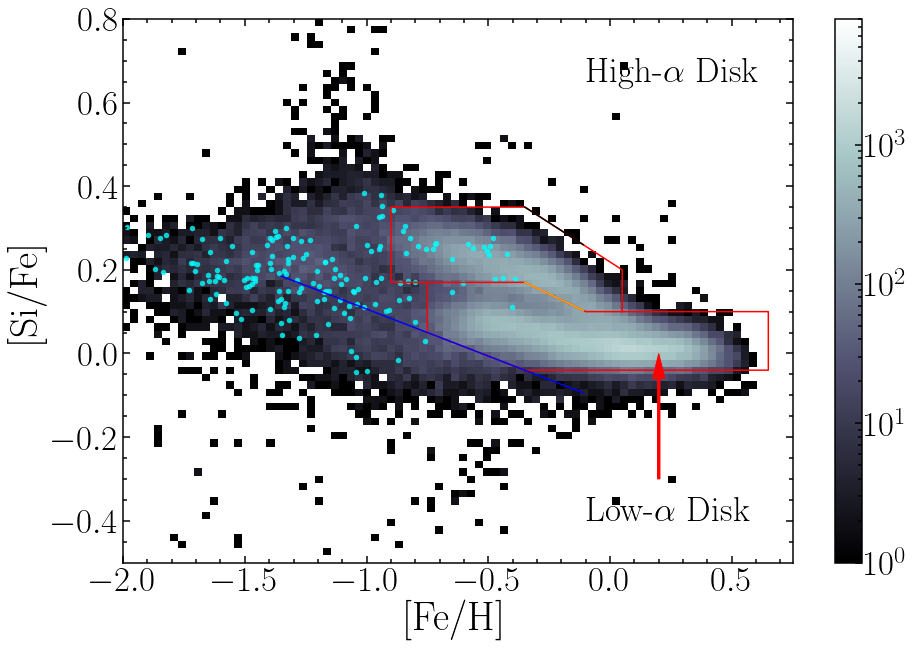

In [23]:
#DISPLAY SAMPLE IN A-FE PLANE.  CHOOSE SI FOR ALPHA ELEMENT

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

labs = 40
tcks = 35


plt.hist2d(feh,sife,norm=mpl.colors.LogNorm(), bins=(100, 75),range=[[-2.5,0.8],[-0.5,.8]], cmap='bone')
#Figure settings (labels, log scale, limits, legend position)   
plt.clim(1,8000)
cb= plt.colorbar()
#cb.set_label('Number',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[Si/Fe]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.0,0.75)
plt.ylim(-0.5,0.8)
plt.text(-0.1,-0.4,'Low-$\\alpha$ Disk',fontsize=35)
plt.text(-0.1,0.65,'High-$\\alpha$ Disk',fontsize=35)
plt.arrow(0.2,-0.3,0,0.3,width=0.01,head_width=0.05,head_length=0.06,length_includes_head=True,color='red')



#plt.plot([0.5,0.5,0.05,-0.35,-0.9,-0.9,-0.35,-0.1,0.5],[0.1,0.2,0.2,0.35,0.35,0.17,0.17,0.1,0.1], 'k', c='red')
plt.plot([0.05,0.05,-0.35,-0.9,-0.9,-0.35,-0.1,0.5],[0.1,0.2,0.35,0.35,0.17,0.17,0.1,0.1], 'k', c='red')
plt.plot([-0.75,-0.75,-0.35,0.65,0.65,0.5],[0.17,0.05,-0.04,-0.04,0.1,0.1], 'k', c='red')
x = np.arange(-0.35,-0.1,0.01)
plt.plot(x,-0.375*x+0.2188, 'k', c='black')
plt.plot(x,-0.28*x+0.0720, 'k', c='orange')
x = np.arange(-1.35,-0.1,0.01)
plt.plot(x,-0.225*x-0.1188, 'k', c='blue')

#plt.scatter(feh_hiad,sife_hiad,c='green',alpha=0.8,s=30,lw=0) 
#plt.scatter(feh_load,sife_load,c='pink',alpha=0.8,s=30,lw=0) 
#plt.scatter(feh_acc,sife_acc,c='cyan',alpha=0.8,s=30,lw=0) 

plt.scatter(feh_acc_nrich,sife_acc_nrich,c='cyan',alpha=0.8,s=30,lw=0) 
plt.savefig('mgfe_disks.png',format='png',bbox_inches='tight')


plt.show()



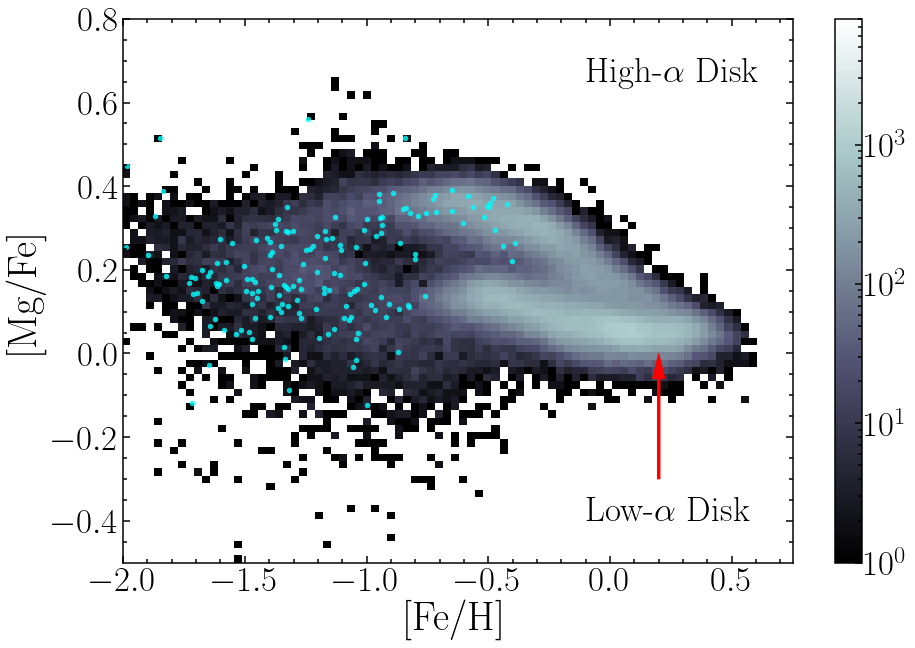

In [24]:
#DISPLAY SAMPLE IN A-FE PLANE.  CHOOSE SI FOR ALPHA ELEMENT

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

labs = 40
tcks = 35


plt.hist2d(feh,mgfe,norm=mpl.colors.LogNorm(), bins=(100, 75),range=[[-2.5,0.8],[-0.5,.8]], cmap='bone')
#Figure settings (labels, log scale, limits, legend position)   
plt.clim(1,8000)
cb= plt.colorbar()
#cb.set_label('Number',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[Mg/Fe]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.0,0.75)
plt.ylim(-0.5,0.8)
plt.text(-0.1,-0.4,'Low-$\\alpha$ Disk',fontsize=35)
plt.text(-0.1,0.65,'High-$\\alpha$ Disk',fontsize=35)
plt.arrow(0.2,-0.3,0,0.3,width=0.01,head_width=0.05,head_length=0.06,length_includes_head=True,color='red')


#plt.scatter(feh_hiad,sife_hiad,c='green',alpha=0.8,s=30,lw=0) 
#plt.scatter(feh_load,sife_load,c='pink',alpha=0.8,s=30,lw=0) 
#plt.scatter(feh_acc,sife_acc,c='cyan',alpha=0.8,s=30,lw=0) 

plt.scatter(feh_acc_nrich,mgfe_acc_nrich,c='cyan',alpha=0.8,s=30,lw=0) 
plt.savefig('mgfe_disks.png',format='png',bbox_inches='tight')


plt.show()



/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


167


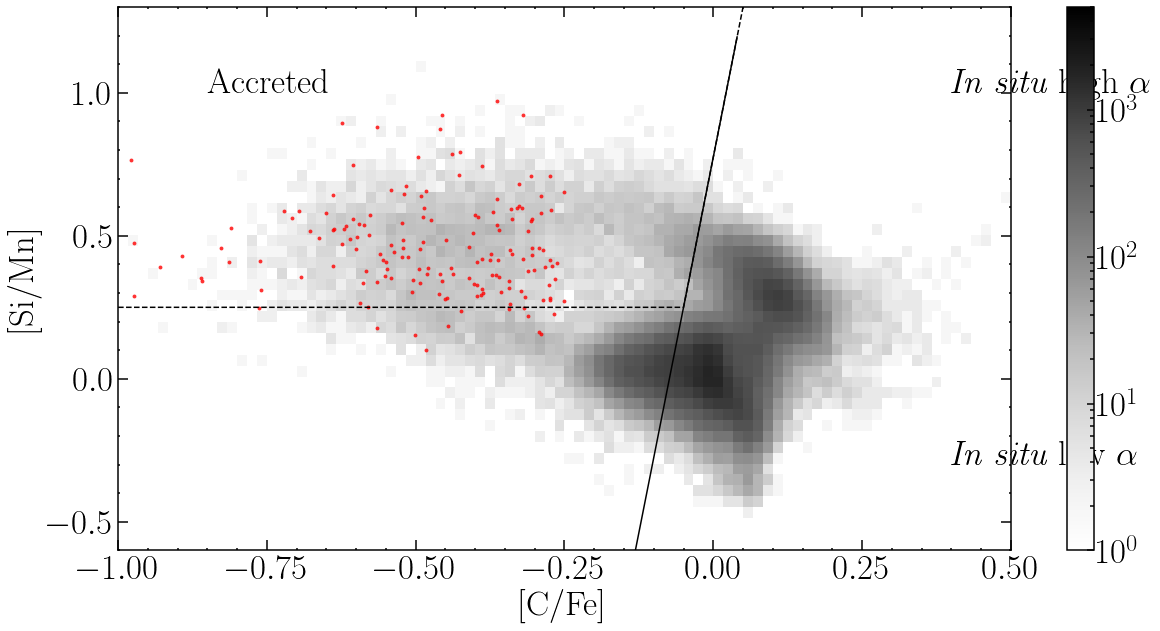

In [25]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10


cfe_acc_nrich = cfe_acc[mask_acc_nrich]
simn_acc_nrich = sife_acc[mask_acc_nrich] - mnfe_acc[mask_acc_nrich]


#Figure settings (font sizes of ticks and labels)
labs=35
tcks=35

#plt.scatter(feh,alfe,c=cn, cmap='rainbow',alpha=0.4,s=30,lw=0,vmin=-0.7,vmax=0.7)
plt.hist2d(cfe, simn, norm=mpl.colors.LogNorm(), bins=(120, 50),range=[[-1.,1],[-0.6,1.3]], cmap='Greys')
plt.clim(1,5000)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
#cb.set_label('Stars per bin',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[C/Fe]',size=labs)
plt.ylabel('[Si/Mn]',size=labs)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.xticks((np.arange(-3.0,1.5,step=0.25)),fontsize=tcks)
plt.yticks((np.arange(-1.5,1.5,step=0.5)),fontsize=tcks)
plt.tick_params(which='minor',direction='in',right=True,top=True,length=2)
plt.xlim(-1.0,0.5)
plt.ylim(-0.6,1.3)
plt.text(-0.85,1,'Accreted',fontsize=35)
plt.text(0.4,-0.3,'{\it In situ} low $\\alpha$',fontsize=35)
plt.text(0.4,1.0,'{\it In situ} high $\\alpha$',fontsize=35)
plt.scatter(cfe_acc_nrich, simn_acc_nrich, c='red', alpha=0.8,s=15,lw=0)



#Attention to different selection here!!!
plt.plot([-1.0,-0.05,0.05],[0.25,0.25,1.3], '--', c='black')
x = np.arange(-0.20,0.05,0.01)
plt.plot(x,10.5*x+0.775, 'k', c='black')


plt.savefig('select_components_bg.png',format='png',bbox_inches='tight')


#Calculate [(C+N)/Fe]
cnfe = np.log10(10**(cfe+feh+8.39) + 10**(nfe+feh+7.78)) - np.log10(10.**8.39 + 10.**7.78) - feh

print(len(simn_acc_nrich))


0.6588951900861164 0.5329341317365269
0.021313315684877928 0.09773058623718815
3137 4761 89 167


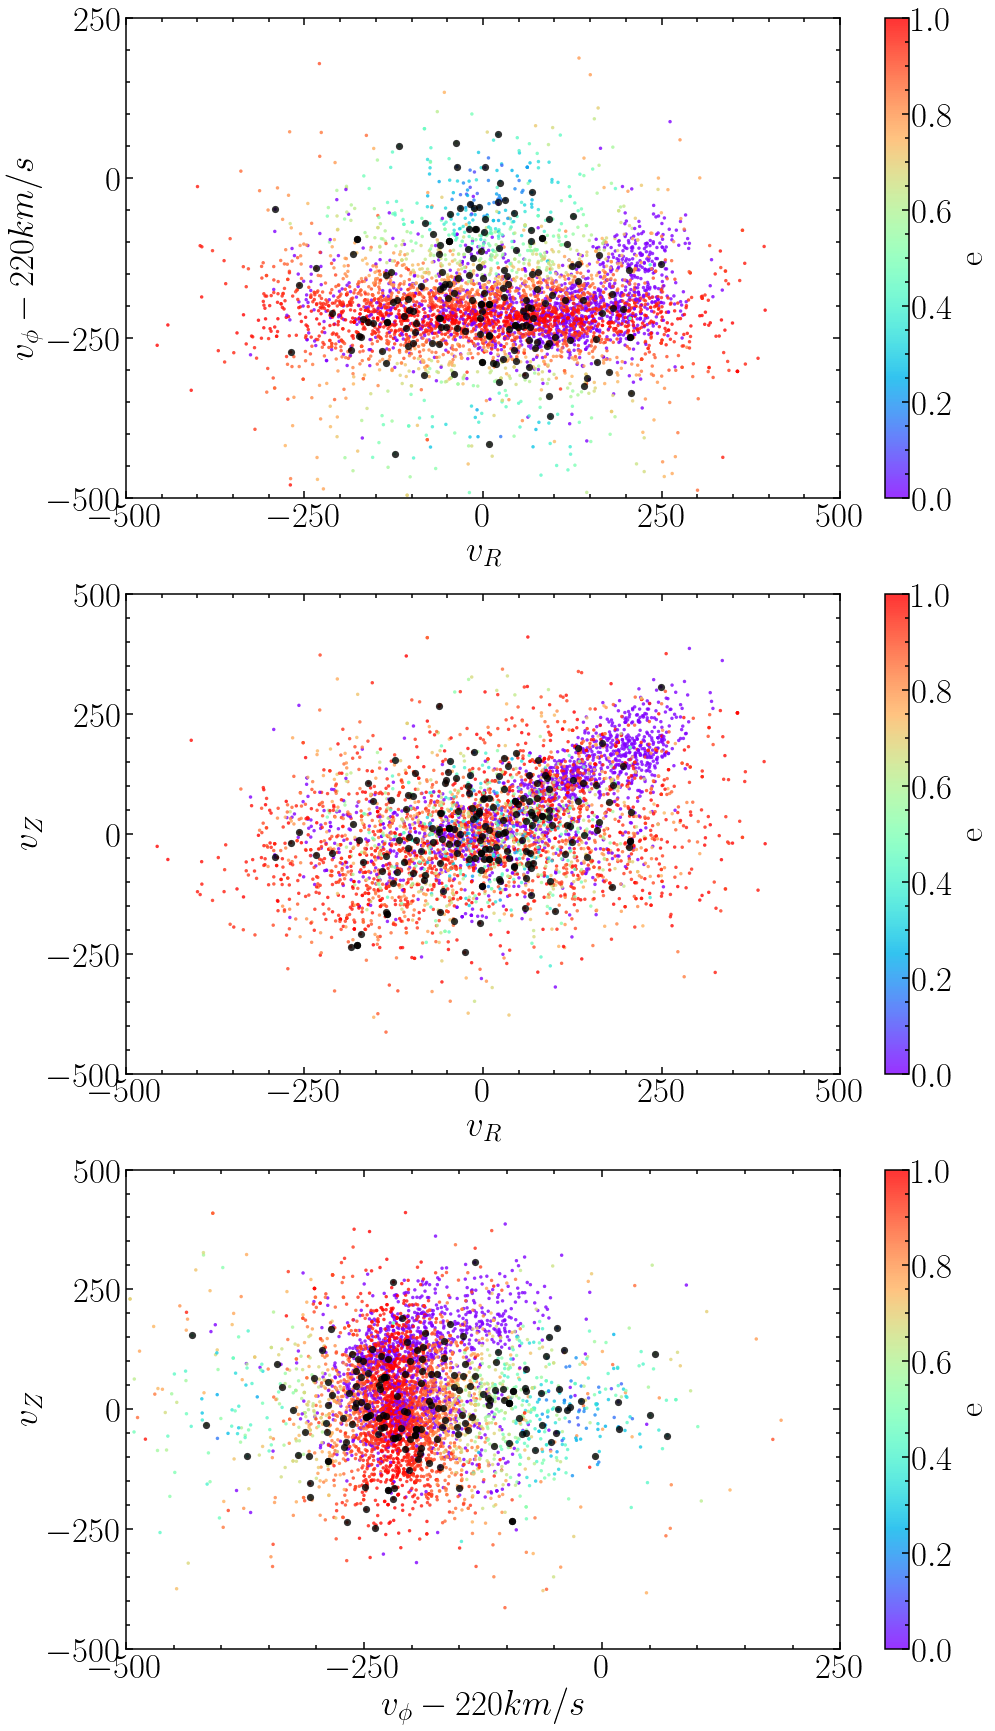

In [26]:
# Mackereth et al. 2019 kinematic plots

# Set figure width to 16 and height to 12
fig_size[0] = 16
fig_size[1] = 30

avr = a[1].data['vR']*220.
avphi = a[1].data['vT']*220.
avz = a[1].data['vZ']*220.
aphi = a[1].data['phi']

vr = avr[mask]
vz = avz[mask]
vphi = avphi[mask]
phi_rad = aphi[mask]*np.pi/180.

vr_acc = vr[newmask]
vz_acc = vz[newmask]
vphi_acc = vphi[newmask]
phi_rad_acc = phi_rad[newmask]

vrr_acc = vr_acc[mask_acc_nrich]
vzr_acc = vz_acc[mask_acc_nrich]
vphir_acc = vphi_acc[mask_acc_nrich]
phir_rad_acc = phi_rad_acc[mask_acc_nrich]





plt.subplot(311)
#plt.scatter(vr_acc,vphi_acc-220,c=ecc_acc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.scatter(vr_acc,vphi_acc-220,c=ecc_acc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
#Figure settings (labels, log scale, limits, legend position)    
cb=plt.colorbar()
cb.set_label('e',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xlabel('$v_R$',size=labs)
plt.ylabel('$v_\phi-220km/s$',size=labs)
plt.xticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
plt.yticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-500,500)
plt.ylim(-500,250)
plt.scatter(vrr_acc,vphir_acc-220,c='black', alpha=0.8,s=52,lw=0)

#Count the number of normal and N-rich stars within the sausage to check whether the ratios are the same.

ntot_acc = len(vr_acc)
ntot_nrich = len(vrr_acc)

mask_getot = ( (vr_acc > -250) & (vr_acc < 250) & (vphi_acc > -55) & (vphi_acc < 70))
mask_genri = ( (vrr_acc > -250) & (vrr_acc < 250) & (vphir_acc > -55) & (vphir_acc < 70))

vr_ge = vr_acc[mask_getot]
vr_nr = vrr_acc[mask_genri]
nge_acc = len(vr_ge)
nge_nrich = len(vr_nr)
print((nge_acc/ntot_acc),(nge_nrich/ntot_nrich))
error_acc = np.sqrt(nge_acc)/ntot_acc + (nge_acc/ntot_acc**2.)*np.sqrt(ntot_acc)
error_nrich = np.sqrt(nge_nrich)/ntot_nrich + (nge_nrich/ntot_nrich**2.)*np.sqrt(ntot_nrich)
print(error_acc,error_nrich)
print(nge_acc,ntot_acc,nge_nrich,ntot_nrich)


plt.subplot(312)
plt.scatter(vr_acc,vz_acc,c=ecc_acc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)

cb= plt.colorbar()
cb.set_label('e',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xlabel('$v_R$',size=labs)
plt.ylabel('$v_Z$',size=labs)
plt.xticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
plt.yticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.scatter(vrr_acc,vzr_acc,c='black', alpha=0.8,s=52,lw=0)
#plt.errorbar(vrr_acc2,vzr_acc2,xerr=vrr_err_acc2,yerr=vzr_err_acc2,ecolor='black',linestyle='None')
#plt.scatter(vrr_acc2,vzr_acc2,c=eccr_acc2, alpha=2,s=52,cmap='rainbow',lw=0,vmin=0,vmax=1)

#plt.plot([200,260,260,200,200],[110,110,230,230,110], 'k', c='black')
mask_thang = ( (vr_acc > 200) & (vr_acc < 260) & (vz_acc > 110) & (vz_acc < 230))
ids_thang = ids_acc[mask_thang]

#Save thang star IDs to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
col1 = fits.Column(name='APOGEE ID', array=ids_thang, format='30A')
cols = fits.ColDefs([col1])
hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('Thang_IDs.fits')


plt.subplot(313)
plt.scatter(vphi_acc-220,vz_acc,c=ecc_acc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
#plt.scatter(cfer_acc2,nfer_acc2,c='red', alpha=0.8,s=30,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('e',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xlabel('$v_\phi-220km/s$',size=labs)
plt.ylabel('$v_Z$',size=labs)
plt.xticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
plt.yticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-500,250)
plt.ylim(-500,500)
plt.scatter(vphir_acc-220,vzr_acc,c='black', alpha=0.8,s=52,lw=0)
#plt.errorbar(vphir_acc2-220,vzr_acc2,xerr=vphir_err_acc2,yerr=vzr_err_acc2,ecolor='black',linestyle='None')
#plt.scatter(vphir_acc2-220,vzr_acc2,c=eccr_acc2, alpha=2,s=52,cmap='rainbow',lw=0,vmin=0,vmax=1)

plt.savefig('Kinematics_detailed_sig2.5.png',format='png',bbox_inches='tight')



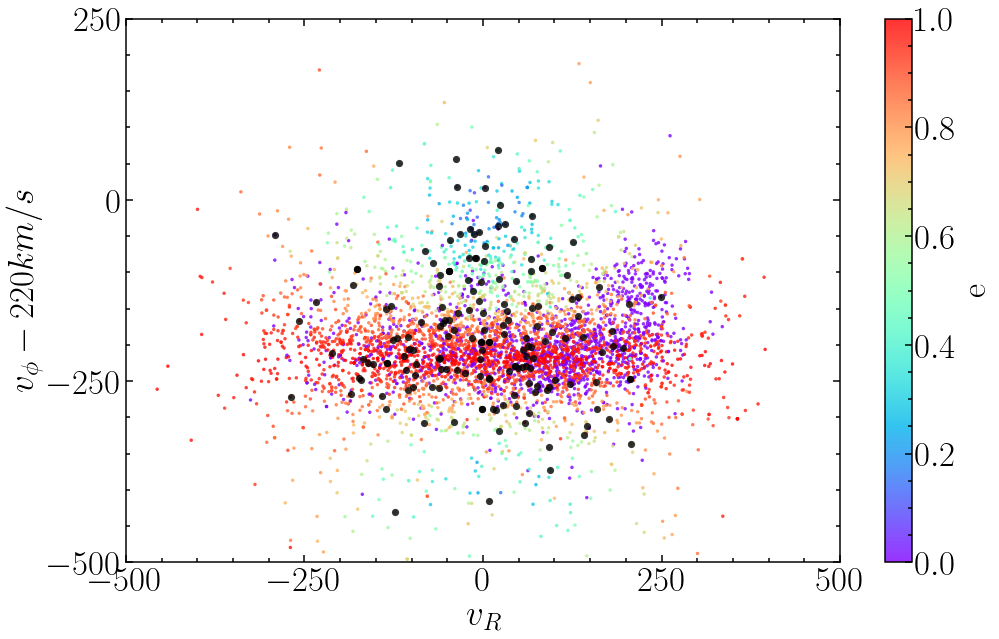

In [27]:
# Mackereth et al. 2019 kinematic plots

# Set figure width to 16 and height to 12
fig_size[0] = 16
fig_size[1] = 10


#plt.scatter(vr_acc,vphi_acc-220,c=ecc_acc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.scatter(vr_acc,vphi_acc-220,c=ecc_acc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
#Figure settings (labels, log scale, limits, legend position)    
cb=plt.colorbar()
cb.set_label('e',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xlabel('$v_R$',size=labs)
plt.ylabel('$v_\phi-220km/s$',size=labs)
plt.xticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
plt.yticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-500,500)
plt.ylim(-500,250)
plt.scatter(vrr_acc,vphir_acc-220,c='black', alpha=0.8,s=52,lw=0)

plt.savefig('Kinematics_Nrich.png',format='png',bbox_inches='tight')


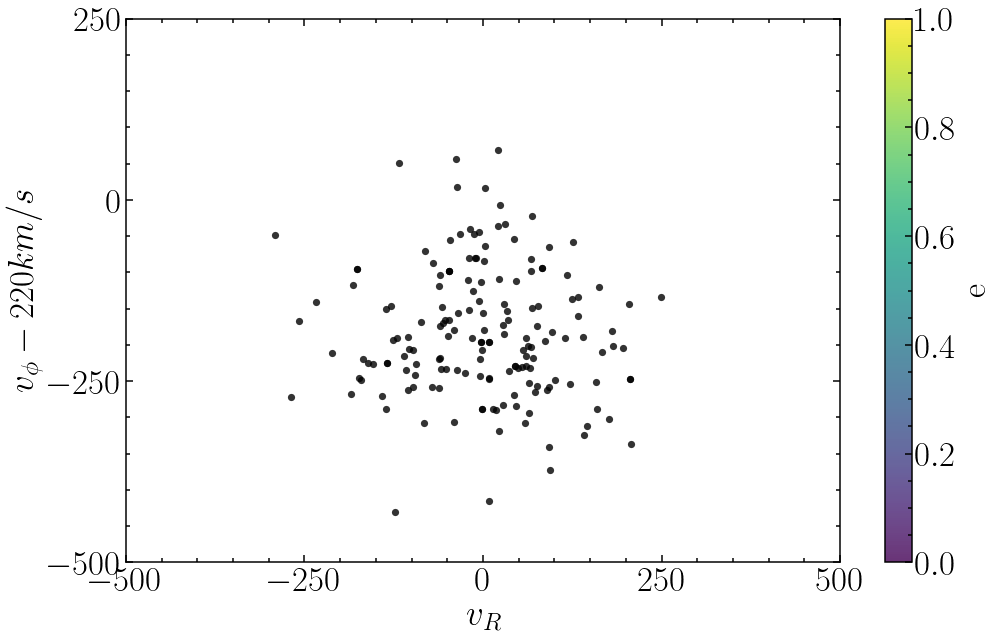

In [28]:
# Mackereth et al. 2019 kinematic plots

# Set figure width to 16 and height to 12
fig_size[0] = 16
fig_size[1] = 10


#plt.scatter(vr_acc,vphi_acc-220,c=ecc_acc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
#plt.scatter(vr_acc,vphi_acc-220,c=ecc_acc, alpha=0.8,s=12,cmap='rainbow',lw=0,vmin=0,vmax=1)
plt.scatter(vrr_acc,vphir_acc-220,c='black', alpha=0.8,s=52,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
cb=plt.colorbar()
cb.set_label('e',size=labs)
cb.ax.tick_params(labelsize=tcks)
plt.xlabel('$v_R$',size=labs)
plt.ylabel('$v_\phi-220km/s$',size=labs)
plt.xticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
plt.yticks((np.arange(-1000,1000,step=250)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-500,500)
plt.ylim(-500,250)

plt.savefig('Kinematics_Nrich_only.png',format='png',bbox_inches='tight')


-2.1728702 -2.2822 0
-1.9931239 -2.015825 0
-1.7807868 -1.78596 0
-1.5864131 -1.608065 1
-1.3934036 -1.3882725 1
-1.2053993 -1.1941178 1
-1.0121448 -1.0015707 2
-0.8232556 -0.8093045 2
-0.62211496 -0.5816371 2


/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


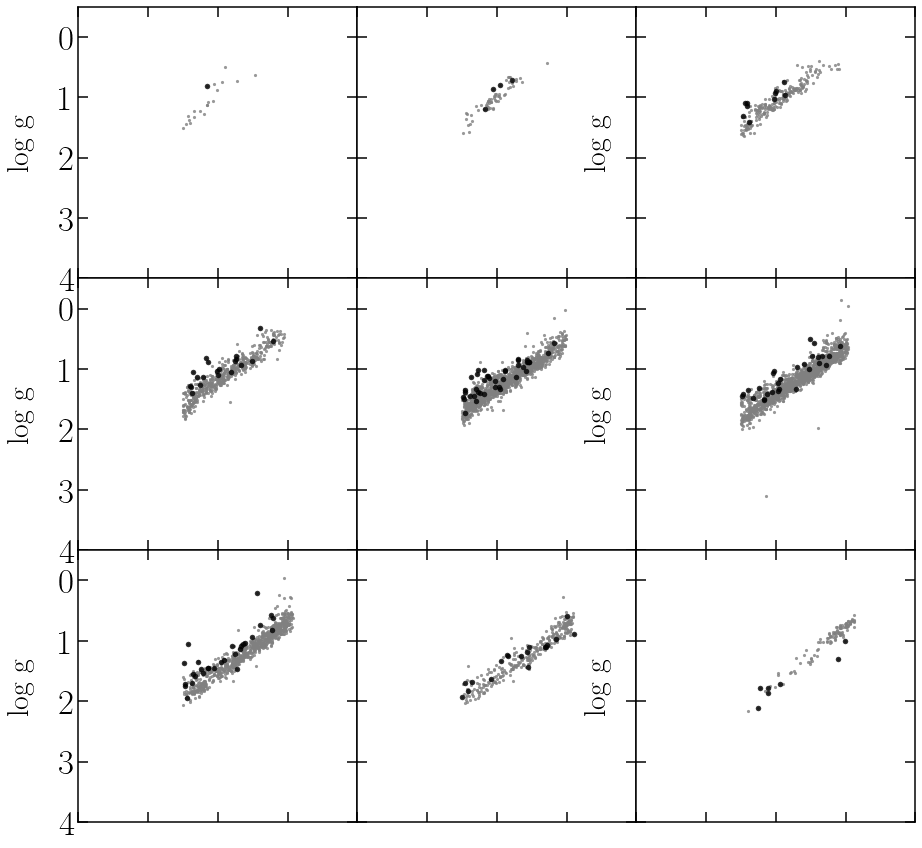

In [29]:
import matplotlib.gridspec as gridspec


# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 10

#Figure settings (font sizes of ticks and labels)
labs=30
tcks=35

fig= plt.figure(figsize=(15,15),constrained_layout=True)

gs = gridspec.GridSpec(3,3)
gs.update(wspace=0, hspace=0) # set the spacing between axes. 

fehin = -2.3
fehst = 0.2

for i in range (0,3):
    k=0+3*i
    plt.subplot(gs[k])
    maskb = ( (feh_acc > fehin + k*fehst) & (feh_acc < fehin + (k+1)*fehst) )
    maskbn = ( (feh_acc_nrich > fehin + k*fehst) & (feh_acc_nrich < fehin + (k+1)*fehst)) 
    plt.scatter(teff_acc[maskb],logg_acc[maskb],c='gray', alpha=0.8,s=10,lw=0)
    plt.scatter(teff_acc_nrich[maskbn],logg_acc_nrich[maskbn],c='black', alpha=0.8,s=30,lw=0)
    print(np.mean(feh_acc[maskb]),np.mean(feh_acc_nrich[maskbn]),i)
    #plt.title('Low-$\\alpha$ Disk',fontsize=labs)
    plt.xticks((np.arange(6000,2500,step=-500)),fontsize=tcks)
    plt.yticks((np.arange(4.0,-2,step=-1)),fontsize=tcks)
    plt.ylabel('log g',size=labs,labelpad=25)
    plt.xlim(5500,3500)
    plt.ylim(4,-0.5)
    plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False)

    k=1+3*i
    ax = plt.subplot(gs[k])
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position("both")
    maskb = ( (feh_acc > fehin + k*fehst) & (feh_acc < fehin + (k+1)*fehst) )
    maskbn = ( (feh_acc_nrich > fehin + k*fehst) & (feh_acc_nrich < fehin + (k+1)*fehst)) 
    plt.scatter(teff_acc[maskb],logg_acc[maskb],c='gray', alpha=0.8,s=10,lw=0)
    plt.scatter(teff_acc_nrich[maskbn],logg_acc_nrich[maskbn],c='black', alpha=0.8,s=30,lw=0)
    print(np.mean(feh_acc[maskb]),np.mean(feh_acc_nrich[maskbn]),i)
    #plt.title('High-$\\alpha$ Disk',fontsize=labs)
    plt.xticks((np.arange(6000,2500,step=-500)),fontsize=tcks)
    plt.yticks((np.arange(4.0,-2,step=-1)),fontsize=tcks)
    plt.ylabel('log g',size=labs,labelpad=25)
    plt.xlim(5500,3500)
    plt.ylim(4,-0.5)
    plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=False)

    k=2+3*i
    plt.subplot(gs[k])
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position("both")
    maskb = ( (feh_acc > fehin + k*fehst) & (feh_acc < fehin + (k+1)*fehst) )
    maskbn = ( (feh_acc_nrich > fehin + k*fehst) & (feh_acc_nrich < fehin + (k+1)*fehst)) 
    plt.scatter(teff_acc[maskb],logg_acc[maskb],c='gray', alpha=0.8,s=10,lw=0)
    plt.scatter(teff_acc_nrich[maskbn],logg_acc_nrich[maskbn],c='black', alpha=0.8,s=30,lw=0)
    print(np.mean(feh_acc[maskb]),np.mean(feh_acc_nrich[maskbn]),i)
    #plt.title('Accreted',fontsize=labs)
    plt.xticks((np.arange(6000,2500,step=-500)),fontsize=tcks)
    plt.yticks((np.arange(4.0,-2,step=-1)),fontsize=tcks)
    plt.ylabel('log g',size=labs,labelpad=25)
    plt.xlim(5500,3500)
    plt.ylim(4,-0.5)
    plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=False,labelright=False,labelleft=False)


plt.savefig('TeffLogg.png',format='png',bbox_inches='tight')

#cbar_ax = fig.add_axes([0.1, 0.95, 0.8,0.05])
#cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
#cbar.set_label('[Fe/H]',fontsize=14)
#




In [30]:
m5 = fits.open('../GCs/M5_members.fits')
mteff = m5[1].data['TEFF']
mlogg = m5[1].data['LOGG']
msn = m5[1].data['SNR']

mfe = m5[1].data['Fe_H']
mmg = m5[1].data['Mg_Fe']
mc = m5[1].data['C_Fe']
mo = m5[1].data['O_Fe']
mn = m5[1].data['N_Fe']


/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


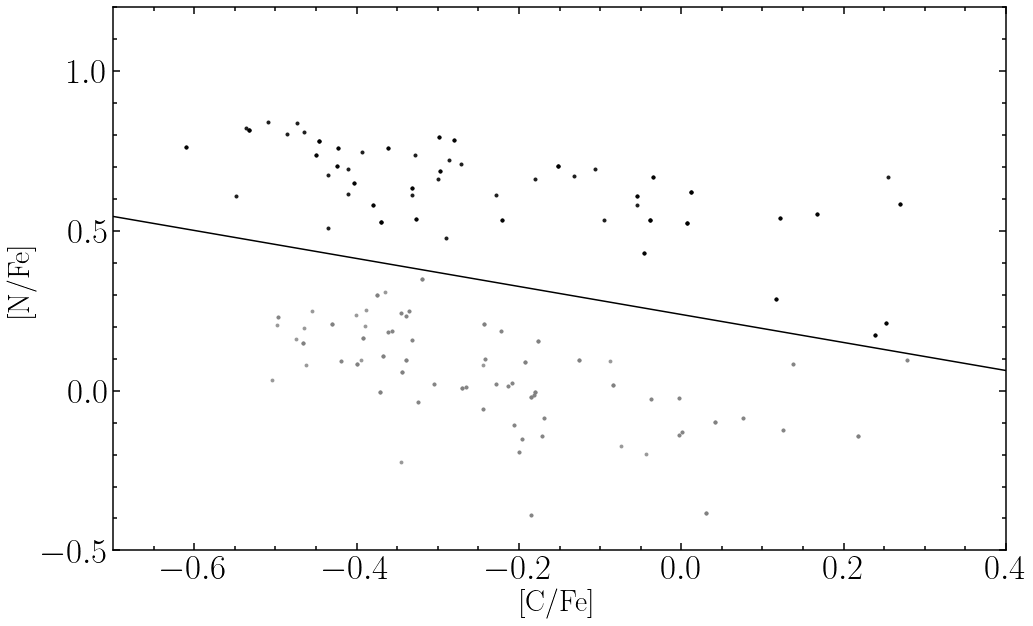

In [31]:
#HIGHALPHA HALO N-RICH STARS IN C-N PLANE

fig_size[0] = 16
fig_size[1] = 10

plt.scatter(mc,mn,c='gray', alpha=0.8,s=15,lw=0)
#plt.scatter(mgfe_stream,alfe_stream,c='orange', alpha=0.8,s=60,lw=0)
#plt.scatter(gc_mgfe,gc_alfe,c='orange', alpha=0.8,s=30,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
#plt.yscale('log')
plt.xlabel('[C/Fe]',size=labs)
plt.ylabel('[N/Fe]',size=labs)
plt.xticks((np.arange(-1,0.6,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-1.5,2.5,step=0.5)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-0.7,0.4)
plt.ylim(-0.5,1.2)


#Attention to different selection here!!!
x = np.arange(-0.7,0.5,0.01)
plt.plot(x,-0.438*x + 0.238, 'k', c='black')



mask_m5r = ( mn > -0.438*mc + 0.238 )
plt.scatter(mc[mask_m5r],mn[mask_m5r],c='black', alpha=0.8,s=15,lw=0)




/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


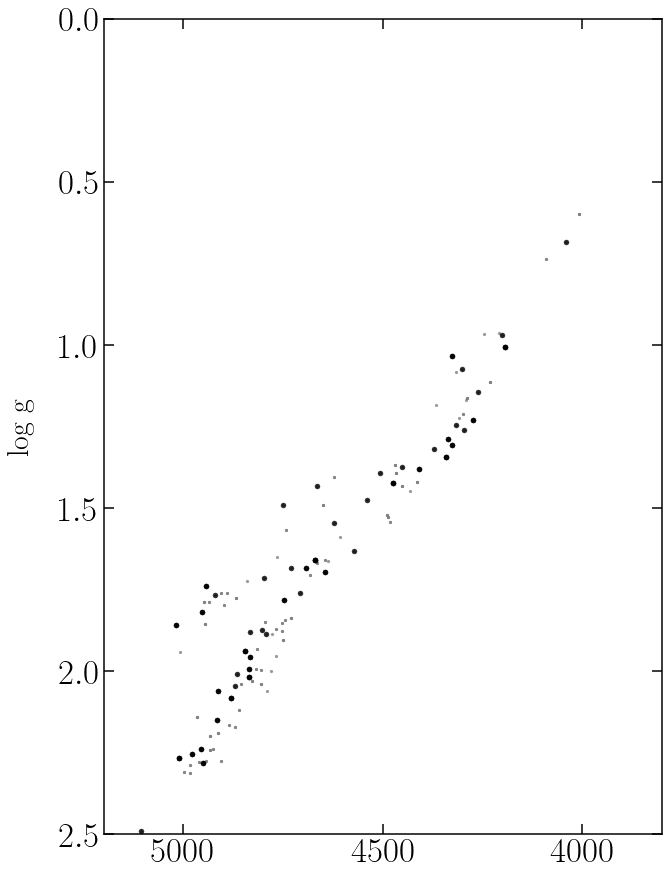

In [32]:
#HIGHALPHA HALO N-RICH STARS IN C-N PLANE

fig_size[0] = 10
fig_size[1] = 15

plt.scatter(mteff,mlogg,c='gray', alpha=0.8,s=10,lw=0)
plt.scatter(mteff[mask_m5r],mlogg[mask_m5r],c='black', alpha=0.8,s=30,lw=0)
#plt.title('Low-$\\alpha$ Disk',fontsize=labs)
plt.xticks((np.arange(6000,2500,step=-500)),fontsize=tcks)
plt.yticks((np.arange(4.0,-2,step=-0.5)),fontsize=tcks)
plt.ylabel('log g',size=labs,labelpad=25)
plt.xlim(5200,3800)
plt.ylim(2.5,0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True)


/Users/ripisc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


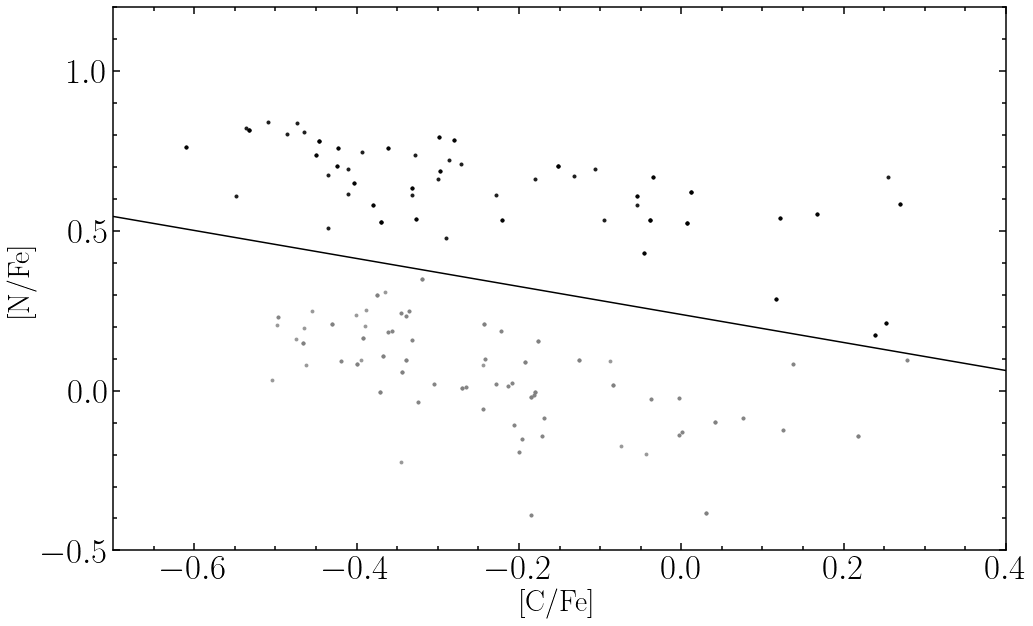

In [33]:
#HIGHALPHA HALO N-RICH STARS IN C-N PLANE

fig_size[0] = 16
fig_size[1] = 10

tt = fits.open('../GCs/M5_members.fits')
tteff = tt[1].data['TEFF']
tlogg = tt[1].data['LOGG']
tsn = tt[1].data['SNR']

tfe = tt[1].data['Fe_H']
tmg = tt[1].data['Mg_Fe']
tc = tt[1].data['C_Fe']
to = tt[1].data['O_Fe']
tn = tt[1].data['N_Fe']


plt.scatter(tc,tn,c='gray', alpha=0.8,s=15,lw=0)
#plt.scatter(mgfe_stream,alfe_stream,c='orange', alpha=0.8,s=60,lw=0)
#plt.scatter(gc_mgfe,gc_alfe,c='orange', alpha=0.8,s=30,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
#plt.yscale('log')
plt.xlabel('[C/Fe]',size=labs)
plt.ylabel('[N/Fe]',size=labs)
plt.xticks((np.arange(-1,0.6,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-1.5,2.5,step=0.5)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-0.7,0.4)
plt.ylim(-0.5,1.2)


#Attention to different selection here!!!
x = np.arange(-0.7,0.5,0.01)
plt.plot(x,-0.438*x + 0.238, 'k', c='black')



mask_ttr = ( mn > -0.438*mc + 0.238 )
plt.scatter(mc[mask_ttr],mn[mask_ttr],c='black', alpha=0.8,s=15,lw=0)




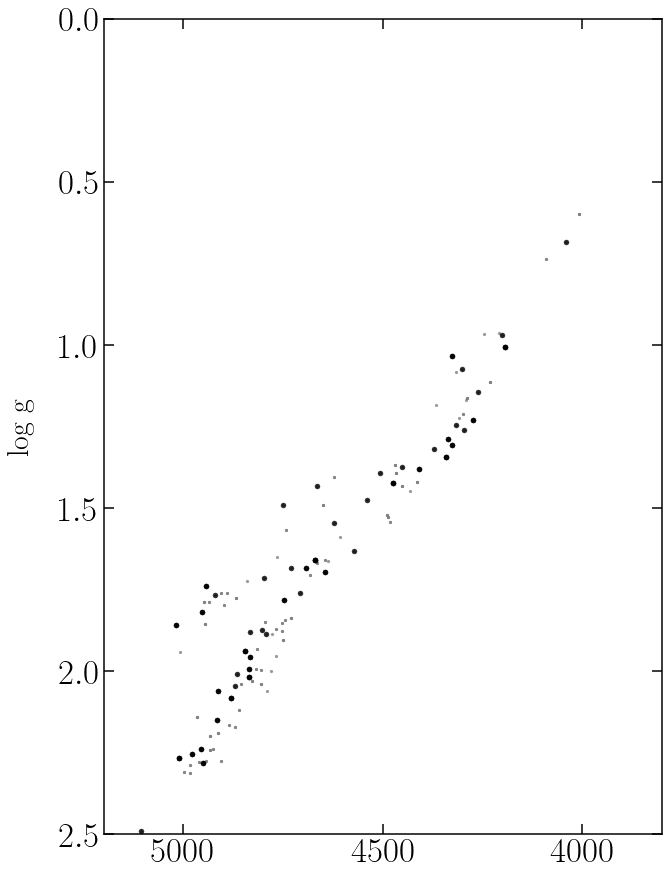

In [32]:
#HIGHALPHA HALO N-RICH STARS IN C-N PLANE

fig_size[0] = 10
fig_size[1] = 15

plt.scatter(tteff,tlogg,c='gray', alpha=0.8,s=10,lw=0)
plt.scatter(tteff[mask_ttr],tlogg[mask_ttr],c='black', alpha=0.8,s=30,lw=0)
#plt.title('Low-$\\alpha$ Disk',fontsize=labs)
plt.xticks((np.arange(6000,2500,step=-500)),fontsize=tcks)
plt.yticks((np.arange(4.0,-2,step=-0.5)),fontsize=tcks)
plt.ylabel('log g',size=labs,labelpad=25)
plt.xlim(5200,3800)
plt.ylim(2.5,0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True)


In [33]:
#LOW ALPHA DISK N-RICH STARS IN AL-FE PLANE

fig_size[0] = 10
fig_size[1] = 10

flo = -1.1
fup = -1.0

mask_f = ( (feh_acc < fup) & ((feh_acc > flo)) )
mask_n = ( (feh_acc_nrich < fup) & ((feh_acc_nrich > flo)) )

mask_go = ( (gsn > 120) & (gteff < 5000) & (gteff > 3500) & (gfe < fup) & (gfe > flo) )


plt.scatter(gteff[mask_go],glogg[mask_go],c='gray', alpha=0.8,s=15,lw=0)
#plt.scatter(teff_acc[mask_f],logg_acc[mask_f],c='black',alpha=0.8,s=15,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
#plt.scatter(teff_acc_nrich[mask_n],logg_acc_nrich[mask_n],c='red', alpha=0.8,s=30,lw=0)
#plt.errorbar(teff_acc_nrich[mask_n],logg_acc_nrich[mask_n],xerr=teff_e_acc_nrich[mask_n],\
#             yerr=logg_e_acc_nrich[mask_n])
plt.xlabel('Teff',size=labs)
plt.ylabel('log g',size=labs)
plt.xticks((np.arange(6000,2500,step=-500)),fontsize=tcks)
plt.yticks((np.arange(4.0,-2,step=-0.5)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(5500,3500)
plt.ylim(4,0)

it = fits.open('parsec_11gyr_m10_noAGB.fits')
iteff = it[1].data['LogTe']
ilogg = it[1].data['logg']
#plt.plot(10.**iteff, ilogg, 'k', c='red', linewidth=3.0)

it = fits.open('parsec_11gyr_m10_AGB.fits')
iteff = it[1].data['LogTe']
ilogg = it[1].data['logg']
#plt.plot(10.**iteff, ilogg, 'k', c='red', linewidth=3.0)



#plt.plot([-0.3,0.25,0.25],[-0.1,-0.1,1.0], 'k', c='black')

plt.savefig('Al_Fe_lowalpa.png',format='png',bbox_inches='tight')

#plt.scatter(teff_load_bin,logg_load_bin, alpha=0.7,s=10,c='orange')


print(logg_acc_nrich[mask_n])
print(logg_e_acc_nrich[mask_n])



NameError: name 'gsn' is not defined

In [ ]:
#HIGHALPHA HALO N-RICH STARS IN C-N PLANE

fig_size[0] = 16
fig_size[1] = 10

g = fits.open('../GCs/GC_DR17.fits')
gteff = g[1].data['TEFF']
glogg = g[1].data['LOGG']
gsn = g[1].data['SNR']
gfe = g[1].data['Fe_H']
gmg = g[1].data['Mg_Fe']
gc = g[1].data['C_Fe']
go = g[1].data['O_Fe']
gn = g[1].data['N_Fe']


gfup = -0.9
gflo = -1.1

mask_go = ( (gsn > 120) & (gteff < 5000) & (gteff > 3500) & (gfe < gfup) & (gfe > gflo) )


plt.scatter(gc[mask_go],gn[mask_go],c='gray', alpha=0.8,s=15,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
#plt.yscale('log')
plt.xlabel('[C/Fe]',size=labs)
plt.ylabel('[N/Fe]',size=labs)
plt.xticks((np.arange(-1,0.6,step=0.2)),fontsize=tcks)
plt.yticks((np.arange(-1.5,2.5,step=0.5)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-0.7,0.4)
plt.ylim(-0.5,1.2)


#Attention to different selection here!!!
x = np.arange(-0.7,0.5,0.01)
plt.plot(x,-0.438*x + 0.238, 'k', c='black')



mask_gr = ( ( gn > -0.438*gc + 0.238 ) & mask_go) 
plt.scatter(gc[mask_gr],gn[mask_gr],c='black', alpha=0.8,s=15,lw=0)




In [ ]:
#HIGHALPHA HALO N-RICH STARS IN C-N PLANE

fig_size[0] = 10
fig_size[1] = 10


g = fits.open('../GCs/GC_DR17.fits')
gteff = g[1].data['TEFF']
glogg = g[1].data['LOGG']
gsn = g[1].data['SNR']
gfe = g[1].data['Fe_H']
gmg = g[1].data['Mg_Fe']
gc = g[1].data['C_Fe']
go = g[1].data['O_Fe']
gn = g[1].data['N_Fe']


gfup = -0.9
gflo = -1.1

mask_go = ( (gsn > 120) & (gteff < 5000) & (gteff > 3500) & (gfe < gfup) & (gfe > gflo) )

gcf = gc[mask_go]
gnf = gn[mask_go]
gcfr = gc[mask_gr]
gnfr = gn[mask_gr]


#plt.scatter(gteff[mask_go],glogg[mask_go],c='gray', alpha=0.8,s=15,lw=0)
plt.scatter(glogg[mask_go],gcf-gnf,c='gray',alpha=0.8,s=15,lw=0)
plt.scatter(glogg[mask_gr],gcfr-gnfr,c='black',alpha=0.8,s=30,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
#plt.scatter(teff_acc_nrich[mask_n],logg_acc_nrich[mask_n],c='red', alpha=0.8,s=30,lw=0)
#plt.errorbar(teff_acc_nrich[mask_n],logg_acc_nrich[mask_n],xerr=teff_e_acc_nrich[mask_n],\
#             yerr=logg_e_acc_nrich[mask_n])
plt.xlabel('log g',size=labs)
plt.ylabel('[C/N]',size=labs)
plt.xticks((np.arange(4,-2,step=-0.5)),fontsize=tcks)
plt.yticks((np.arange(-3,3,step=0.5)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(4,-1)
plt.ylim(-2,1)


##CHECK WHERE GC AGBs are in this plot



In [ ]:
#HIGHALPHA HALO N-RICH STARS IN C-N PLANE

fig_size[0] = 10
fig_size[1] = 10

plt.scatter(gteff[mask_go],glogg[mask_go],c='gray', alpha=0.8,s=10,lw=0)
plt.scatter(gteff[mask_gr],glogg[mask_gr],c='black', alpha=0.8,s=30,lw=0)
#plt.title('Low-$\\alpha$ Disk',fontsize=labs)
plt.xticks((np.arange(6000,2500,step=-500)),fontsize=tcks)
plt.yticks((np.arange(4.0,-2,step=-0.5)),fontsize=tcks)
plt.ylabel('log g',size=labs,labelpad=25)
plt.xlim(5500,3500)
plt.ylim(4,0)
plt.tick_params(direction='in',right=True,top=True,length=10,labelbottom=True)


In [ ]:
mask_bulge = Rgc < 4.0

In [ ]:

# "BULGE"

ids_bulge = ids[mask_bulge] 
nvis_bulge = nvis[mask_bulge]
vscat_bulge = vscat[mask_bulge]
ra_bulge = ra[mask_bulge]
dec_bulge = dec[mask_bulge]
glon_bulge = glon[mask_bulge]
glat_bulge = glat[mask_bulge]
teff_bulge = teff[mask_bulge]
logg_bulge = logg[mask_bulge]
teff_e_bulge = teff_e[mask_bulge]
logg_e_bulge = logg_e[mask_bulge]
mgfe_bulge = mgfe[mask_bulge]
nfe_bulge = nfe[mask_bulge]
nife_bulge = nife[mask_bulge]
feh_bulge = feh[mask_bulge]
cafe_bulge = cafe[mask_bulge]
cfe_bulge = cfe[mask_bulge]
ofe_bulge = ofe[mask_bulge]
sife_bulge = sife[mask_bulge]
nife_bulge = nife[mask_bulge]
nafe_bulge = nafe[mask_bulge]
alfe_bulge = alfe[mask_bulge]
tife_bulge = tife[mask_bulge]
kfe_bulge = kfe[mask_bulge]
vfe_bulge = vfe[mask_bulge]
tife_bulge = tife[mask_bulge]
mnfe_bulge = mnfe[mask_bulge]
crfe_bulge = crfe[mask_bulge]
cufe_bulge = cufe[mask_bulge]
cefe_bulge = cefe[mask_bulge]
cofe_bulge = cofe[mask_bulge]
pfe_bulge = pfe[mask_bulge]
sfe_bulge = sfe[mask_bulge]
mgmn_bulge = mgmn[mask_bulge] 
alfe_err_bulge = alfe_err[mask_bulge]
mgmn_err_bulge = mgmn_err[mask_bulge] 

dist_bulge = dist[mask_bulge]
dist_err_bulge = dist_err[mask_bulge]
Rgc_bulge = Rgc[mask_bulge]
xx_bulge = xx[mask_bulge]
yy_bulge = yy[mask_bulge]
zz_bulge = zz[mask_bulge]

ecc_bulge = ecc[mask_bulge]
zmax_bulge = zmax[mask_bulge]
ener_bulge = ener[mask_bulge]
jr_bulge = jr[mask_bulge]
lz_bulge = lz[mask_bulge]
jz_bulge = jz[mask_bulge]


In [ ]:
#NOW, RATHER THAN ADOPTING A BLANK [C/FE]<+0.15 CUT, WE FIT THE C/FE VS FE/H RELATION AND KEEP
#ONLY STARS THAT DO NOT DEPART FROM IT BY MORE THAN 4 SIGMA.  MAY WANT TO CHANGE THAT THRESHOLD
#GET MORE N-RICH STARS THAT WAY -- 25 March 2021

fig_size[0] = 16
fig_size[1] = 10


#SELECT HALO STARS

plt.scatter(feh_bulge,cfe_bulge,c=nfe_bulge, alpha=0.8,s=15,cmap='rainbow',lw=0,vmin=-0.5,vmax=1.5)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('[N/Fe]',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[C/Fe]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.5,0.7)
plt.ylim(-1.7,1.7)


########  Polynomial fit to the relation between Fe/H and C/Fe
import numpy.polynomial.polynomial as poly
coefs_c = np.polynomial.polynomial.polyfit(feh_bulge,cfe_bulge,4)
ffnit_c = poly.Polynomial(coefs_c)

#fet = np.linspace(feh_l[0], feh_l[-1], num=len(feh_l)*10)
fet = np.arange(-3.0,0.7,0.01)
plt.plot(fet,ffnit_c(fet),'k',c='black')

#print(fet,ffit(fet))

sclip_c=3.0  #size of sigma clipping (only one iteration)
estim_c = ffnit_c(feh_bulge)
res_c = cfe_bulge - estim_c
resq_c = res_c**2.
numtot = len(feh_bulge)
print(numtot)
var_c = np.sum(resq_c)/(numtot-1)
sigma_c = math.sqrt(var_c)
print(sigma_c)

#mask_bulge_nrich = ( (res > (sclip*sigma)) & (alfe_dwh > -0.1) ) 
mask_bulge_crich = res_c > (sclip_c*sigma_c) 


#idr_bulge_nrich = ids_bulge[mask_bulge_nrich]
#teff_bulge_nrich = teff_bulge[mask_bulge_nrich]
#logg_bulge_nrich = logg_bulge[mask_bulge_nrich]

nfe_bulge_crich = nfe_bulge[mask_bulge_crich]
ofe_bulge_crich = ofe_bulge[mask_bulge_crich]
cfe_bulge_crich = cfe_bulge[mask_bulge_crich]
feh_bulge_crich = feh_bulge[mask_bulge_crich]
mgfe_bulge_crich = mgfe_bulge[mask_bulge_crich]
alfe_bulge_crich = alfe_bulge[mask_bulge_crich]
sife_bulge_crich = sife_bulge[mask_bulge_crich]
nvis_bulge_crich = nvis_bulge[mask_bulge_crich]
vscat_bulge_crich = vscat_bulge[mask_bulge_crich]


lz_bulge_crich = lz_bulge[mask_bulge_crich]
ener_bulge_crich = ener_bulge[mask_bulge_crich]
ecc_bulge_crich = ecc_bulge[mask_bulge_crich]




#lzr_halo = lz_halo[mask_bulge_nrich]
#energyr_halo = energy_halo[mask_bulge_nrich]
#eccr_halo = ecc_halo[mask_bulge_nrich]
#jtotr_halo = jtot_halo[mask_bulge_nrich]
#jzr_halo = jz_halo[mask_bulge_nrich]
#jrr_halo = jr_halo[mask_bulge_nrich]

#np.savetxt('Halo_Nrich_ids.txt',idr_halo,fmt='%s')


plt.scatter(feh_bulge_crich,cfe_bulge_crich, alpha=0.8,s=15,c='black')
print(len(feh_bulge_crich))

#Save N-rich star IDs to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
#col1 = fits.Column(name='APOGEE ID', array=idr_bulge, format='30A')
#cols = fits.ColDefs([col1])
#hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('Lowalpha_Nrich_IDs_21oct2019.fits')

plt.savefig('Hialpha_Nrich.png',format='png',bbox_inches='tight')

#plt.scatter(feh_bulge_bin,cfe_bulge_bin, alpha=0.8,s=15,c='blue')



In [ ]:
#Identify High-alpha metal-rich halo N-rich stars

fig_size[0] = 16
fig_size[1] = 10

#SELECT HALO STARS

plt.scatter(feh_bulge,nfe_bulge,c=mgfe_bulge, alpha=0.8,s=15,cmap='rainbow',lw=0,vmin=-0.5,vmax=0.5)
#Figure settings (labels, log scale, limits, legend position)    
cb= plt.colorbar()
cb.set_label('[Mg/Fe]',size=labs)
cb.ax.tick_params(labelsize=tcks)
#plt.yscale('log')
plt.xlabel('[Fe/H]',size=labs)
plt.ylabel('[N/Fe]',size=labs)
plt.xticks(fontsize=tcks)
plt.yticks(fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(-2.5,0.7)
plt.ylim(-1,2.5)


########  Polynomial fit to the relation between Fe/H and C/Fe
import numpy.polynomial.polynomial as poly
coefs = np.polynomial.polynomial.polyfit(feh_bulge,nfe_bulge,3)
ffnit = poly.Polynomial(coefs)

#fet = np.linspace(feh_l[0], feh_l[-1], num=len(feh_l)*10)
fet = np.arange(-3.0,0.7,0.01)
plt.plot(fet,ffnit(fet),'k',c='black')

#print(fet,ffit(fet))

sclip=5.0  #size of sigma clipping (only one iteration)
estim = ffnit(feh_bulge)
res = nfe_bulge - estim
resq = res**2.
numtot = len(feh_bulge)
print(numtot)
var = np.sum(resq)/(numtot-1)
sigma = math.sqrt(var)
print(sigma)

#mask_bulge_nrich = ( (res > (sclip*sigma)) & (alfe_dwh > -0.1) ) 
mask_bulge_nrich = (  (res > (sclip*sigma)) & (res_c < (sclip_c*sigma_c)) )


#idr_bulge_nrich = ids_bulge[mask_bulge_nrich]
#teff_bulge_nrich = teff_bulge[mask_bulge_nrich]
#logg_bulge_nrich = logg_bulge[mask_bulge_nrich]

nfe_bulge_nrich = nfe_bulge[mask_bulge_nrich]
teff_bulge_nrich = teff_bulge[mask_bulge_nrich]
logg_bulge_nrich = logg_bulge[mask_bulge_nrich]
teff_e_bulge_nrich = teff_e_bulge[mask_bulge_nrich]
logg_e_bulge_nrich = logg_e_bulge[mask_bulge_nrich]
ofe_bulge_nrich = ofe_bulge[mask_bulge_nrich]
cfe_bulge_nrich = cfe_bulge[mask_bulge_nrich]
feh_bulge_nrich = feh_bulge[mask_bulge_nrich]
mgfe_bulge_nrich = mgfe_bulge[mask_bulge_nrich]
alfe_bulge_nrich = alfe_bulge[mask_bulge_nrich]
sife_bulge_nrich = sife_bulge[mask_bulge_nrich]
nife_bulge_nrich = nife_bulge[mask_bulge_nrich]
mnfe_bulge_nrich = mnfe_bulge[mask_bulge_nrich]
nvis_bulge_nrich = nvis_bulge[mask_bulge_nrich]
vscat_bulge_nrich = vscat_bulge[mask_bulge_nrich]


lz_bulge_nrich = lz_bulge[mask_bulge_nrich]
ener_bulge_nrich = ener_bulge[mask_bulge_nrich]
ecc_bulge_nrich = ecc_bulge[mask_bulge_nrich]




#lzr_halo = lz_halo[mask_bulge_nrich]
#energyr_halo = energy_halo[mask_bulge_nrich]
#eccr_halo = ecc_halo[mask_bulge_nrich]
#jtotr_halo = jtot_halo[mask_bulge_nrich]
#jzr_halo = jz_halo[mask_bulge_nrich]
#jrr_halo = jr_halo[mask_bulge_nrich]

#np.savetxt('Halo_Nrich_ids.txt',idr_halo,fmt='%s')


plt.scatter(feh_bulge_nrich,nfe_bulge_nrich, alpha=0.8,s=15,c='black')
print(len(feh_bulge_nrich))

#Save N-rich star IDs to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
#col1 = fits.Column(name='APOGEE ID', array=idr_bulge, format='30A')
#cols = fits.ColDefs([col1])
#hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('Lowalpha_Nrich_IDs_21oct2019.fits')

plt.savefig('Hialpha_Nrich.png',format='png',bbox_inches='tight')

#plt.scatter(feh_bulge_bin,nfe_bulge_bin, alpha=0.8,s=15,c='blue')



In [ ]:
#LOW ALPHA DISK N-RICH STARS IN AL-FE PLANE

fig_size[0] = 10
fig_size[1] = 10

flo = -1.1
fup = -1.0

mask_f = ( (feh_bulge < fup) & ((feh_bulge > flo)) )
mask_n = ( (feh_bulge_nrich < fup) & ((feh_bulge_nrich > flo)) )

plt.scatter(teff_bulge[mask_f],logg_bulge[mask_f],c='gray',alpha=0.8,s=15,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
plt.scatter(teff_bulge_nrich[mask_n],logg_bulge_nrich[mask_n],c='black', alpha=0.8,s=30,lw=0)
#plt.errorbar(teff_bulge_nrich[mask_n],logg_bulge_nrich[mask_n],xerr=teff_e_bulge_nrich[mask_n],\
#             yerr=logg_e_bulge_nrich[mask_n])
plt.xlabel('Teff',size=labs)
plt.ylabel('log g',size=labs)
plt.xticks((np.arange(6000,2500,step=-500)),fontsize=tcks)
plt.yticks((np.arange(4.0,-2,step=-0.5)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(5500,3500)
plt.ylim(4,0)

it = fits.open('parsec_11gyr_m10_noAGB.fits')
iteff = it[1].data['LogTe']
ilogg = it[1].data['logg']
#plt.plot(10.**iteff, ilogg, 'k', c='red', linewidth=3.0)

it = fits.open('parsec_11gyr_m10_AGB.fits')
iteff = it[1].data['LogTe']
ilogg = it[1].data['logg']
#plt.plot(10.**iteff, ilogg, 'k', c='red', linewidth=3.0)



#plt.plot([-0.3,0.25,0.25],[-0.1,-0.1,1.0], 'k', c='black')

plt.savefig('Al_Fe_lowalpa.png',format='png',bbox_inches='tight')

#plt.scatter(teff_load_bin,logg_load_bin, alpha=0.7,s=10,c='orange')


print(len(logg_bulge_nrich[mask_n]))
print(len(logg_bulge[mask_f]))



In [ ]:
#LOW ALPHA DISK N-RICH STARS IN AL-FE PLANE

fig_size[0] = 10
fig_size[1] = 10

flo = -1.2
fup = -1

xkmag_acc = kmag_acc - a_k_acc
xjmag_acc = jmag_acc - a_j_acc
xkmag_acc_nrich = kmag_acc_nrich - a_k_acc_nrich
xjmag_acc_nrich = jmag_acc_nrich - a_j_acc_nrich

mkmag_acc = xkmag_acc - 5.*np.log10(dist_acc*1.e3) + 5
mkmag_acc_nrich = xkmag_acc_nrich - 5.*np.log10(dist_acc_nrich*1.e3) + 5

mask_f = ( (feh_acc < fup) & ((feh_acc > flo)) & (mkmag_acc > -10) & (mkmag_acc < 10) & (a_k_acc < 0.1) & \
          (a_k_acc > 0) & (dist_acc < 15) & (dist_err_acc/dist_acc < 0.1) )
mask_n = ( (feh_acc_nrich < fup) & ((feh_acc_nrich > flo)) & (mkmag_acc_nrich > -10) & (mkmag_acc_nrich < 10)  \
         & (a_k_acc_nrich < 0.1) & (a_k_acc_nrich >0) & (dist_acc_nrich < 15)  &  \
          (dist_err_acc_nrich/dist_acc_nrich < 0.1) )



plt.scatter(jmag_acc[mask_f]-kmag_acc[mask_f],mkmag_acc[mask_f],c='gray',alpha=0.8,s=15,lw=0)
#Figure settings (labels, log scale, limits, legend position)    
#plt.scatter(teff_acc_nrich[mask_n],logg_acc_nrich[mask_n],c='red', alpha=0.8,s=30,lw=0)
#plt.errorbar(teff_acc_nrich[mask_n],logg_acc_nrich[mask_n],xerr=teff_e_acc_nrich[mask_n],\
#             yerr=logg_e_acc_nrich[mask_n])
plt.xlabel('$J-K$',size=labs)
plt.ylabel('$M_K$',size=labs)
plt.xticks((np.arange(0,1.5,step=0.3)),fontsize=tcks)
plt.yticks((np.arange(4.0,-8,step=-1)),fontsize=tcks)
#plt.legend(loc='lower right',frameon=False)
plt.xlim(0,1.5)
plt.ylim(0,-6)

it = fits.open('parsec_11gyr_m10_noAGB.fits')
iteff = it[1].data['LogTe']
ilogg = it[1].data['logg']
#plt.plot(10.**iteff, ilogg, 'k', c='red', linewidth=3.0)

it = fits.open('parsec_11gyr_m10_AGB.fits')
iteff = it[1].data['LogTe']
ilogg = it[1].data['logg']
#plt.plot(10.**iteff, ilogg, 'k', c='red', linewidth=3.0)
plt.scatter(jmag_acc_nrich[mask_n]-kmag_acc_nrich[mask_n],mkmag_acc_nrich[mask_n],c='black',alpha=0.8,s=30,lw=0)



#plt.plot([-0.3,0.25,0.25],[-0.1,-0.1,1.0], 'k', c='black')

plt.savefig('Al_Fe_lowalpa.png',format='png',bbox_inches='tight')

#plt.scatter(teff_load_bin,logg_load_bin, alpha=0.7,s=10,c='orange')

print(np.mean(dist_acc),np.log10(10.))